In [3]:
# Import psutil to check system resources
import psutil

# Get system memory info
total_ram = psutil.virtual_memory().total / (1024 * 1024 * 1024)  # in GB
available_ram = psutil.virtual_memory().available / (1024 * 1024 * 1024)  # in GB

print(f"Total RAM: {total_ram:.2f} GB")
print(f"Available RAM: {available_ram:.2f} GB")



Total RAM: 12.67 GB
Available RAM: 11.29 GB


# Load Libraries

In [4]:
import os
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from pyspark.sql.functions import rand
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from typing import List
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from typing import List
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

In [5]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName('Advanced ML Pipeline') \
    .config('spark.driver.memory', '32g') \
    .config('spark.executor.memory', '8g') \
    .config('spark.memory.offHeap.enabled', 'true') \
    .config('spark.memory.offHeap.size', '10g') \
    .config('spark.driver.maxResultSize', '4g') \
    .config('spark.sql.adaptive.enabled', 'true') \
    .config('spark.sql.shuffle.partitions', '200') \
    .config('spark.default.parallelism', '100') \
    .config('spark.executor.cores', '4') \
    .config('spark.driver.cores', '8') \
    .config('spark.sql.execution.arrow.pyspark.enabled', 'true') \
    .config('spark.sql.adaptive.coalescePartitions.enabled', 'true') \
    .config('spark.databricks.io.cache.enabled', 'true') \
    .getOrCreate()

spark.sparkContext.setLogLevel('WARN')

spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', 'true')

from pyspark.sql import SparkSession
from google.colab import output
output.serve_kernel_port_as_window(8265)

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [6]:
!gdown 1-f7DsPwgsyqyTxw1cgvaGxIgvF7otMHW -O BDA_Data_v3.csv

Downloading...
From: https://drive.google.com/uc?id=1-f7DsPwgsyqyTxw1cgvaGxIgvF7otMHW
To: /content/BDA_Data_v3.csv
100% 37.9M/37.9M [00:00<00:00, 145MB/s]


In [7]:
raw_df = spark.read.csv("BDA_Data_v3.csv", header=True, inferSchema=True)


print("DataFrame Schema:")
raw_df.printSchema()

print("\nFirst few rows of data:")
raw_df.show(5)

print("\nDataFrame Information:")
print(f"Number of rows: {raw_df.count()}")
print(f"Number of columns: {len(raw_df.columns)}")

DataFrame Schema:
root
 |-- DATE_COLUMN: date (nullable = true)
 |-- YEAR_COLUMN: integer (nullable = true)
 |-- SS_ITEM_SK: integer (nullable = true)
 |-- SS_SOLD_TIME_SK: integer (nullable = true)
 |-- SS_SOLD_DATE_SK: integer (nullable = true)
 |-- SS_QUANTITY: integer (nullable = true)
 |-- SS_WHOLESALE_COST: double (nullable = true)
 |-- SS_LIST_PRICE: double (nullable = true)
 |-- SS_SALES_PRICE: double (nullable = true)
 |-- SS_COUPON_AMT: double (nullable = true)
 |-- SS_NET_PAID: double (nullable = true)
 |-- SS_NET_PROFIT: double (nullable = true)
 |-- S_STORE_SK: integer (nullable = true)
 |-- S_STORE_ID: string (nullable = true)
 |-- S_STATE: string (nullable = true)
 |-- CD_DEMO_SK: integer (nullable = true)
 |-- CD_GENDER: string (nullable = true)
 |-- CD_MARITAL_STATUS: string (nullable = true)
 |-- CD_EDUCATION_STATUS: string (nullable = true)
 |-- CD_PURCHASE_ESTIMATE: integer (nullable = true)
 |-- HD_DEMO_SK: integer (nullable = true)
 |-- HD_INCOME_BAND_SK: integer 

In [8]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd

def analyze_and_clean_data(spark_df):
    """
    Function to analyze data types, check null values and clean the dataset
    """
    schema_info = []
    for field in spark_df.schema.fields:
        schema_info.append({
            'column_name': field.name,
            'data_type': str(field.dataType)
        })

    schema_df = pd.DataFrame(schema_info)
    print("\n=== Data Types for Each Column ===")
    print(schema_df)

    null_counts = []
    total_rows = spark_df.count()

    for column in spark_df.columns:
        null_count = spark_df.filter(F.col(column).isNull()).count()
        null_percentage = (null_count / total_rows) * 100

        null_counts.append({
            'column_name': column,
            'null_count': null_count,
            'null_percentage': round(null_percentage, 2)
        })

    null_df = pd.DataFrame(null_counts)
    print("\n=== Null Values Analysis ===")
    print(null_df)

    cleaned_df = spark_df

    initial_count = cleaned_df.count()

    for column in cleaned_df.columns:
        cleaned_df = cleaned_df.filter(F.col(column).isNotNull())

    final_count = cleaned_df.count()

    print(f"\n=== Cleaning Summary ===")
    print(f"Initial number of rows: {initial_count}")
    print(f"Final number of rows: {final_count}")
    print(f"Removed rows: {initial_count - final_count}")
    print(f"Percentage of data retained: {round((final_count/initial_count)*100, 2)}%")

    numeric_columns = [field.name for field in spark_df.schema.fields
                      if isinstance(field.dataType, (IntegerType, DoubleType, FloatType, LongType))]

    if numeric_columns:
        print("\n=== Summary Statistics for Numeric Columns ===")
        cleaned_df.select(numeric_columns).summary().show()

    return cleaned_df, null_df

cleaned_df, null_analysis = analyze_and_clean_data(raw_df)


=== Data Types for Each Column ===
             column_name      data_type
0            DATE_COLUMN     DateType()
1            YEAR_COLUMN  IntegerType()
2             SS_ITEM_SK  IntegerType()
3        SS_SOLD_TIME_SK  IntegerType()
4        SS_SOLD_DATE_SK  IntegerType()
5            SS_QUANTITY  IntegerType()
6      SS_WHOLESALE_COST   DoubleType()
7          SS_LIST_PRICE   DoubleType()
8         SS_SALES_PRICE   DoubleType()
9          SS_COUPON_AMT   DoubleType()
10           SS_NET_PAID   DoubleType()
11         SS_NET_PROFIT   DoubleType()
12            S_STORE_SK  IntegerType()
13            S_STORE_ID   StringType()
14               S_STATE   StringType()
15            CD_DEMO_SK  IntegerType()
16             CD_GENDER   StringType()
17     CD_MARITAL_STATUS   StringType()
18   CD_EDUCATION_STATUS   StringType()
19  CD_PURCHASE_ESTIMATE  IntegerType()
20            HD_DEMO_SK  IntegerType()
21     HD_INCOME_BAND_SK  IntegerType()
22      HD_BUY_POTENTIAL   StringType()
23  

Comment: In the above code chunk, we start off by calculating nulls in each column, and also using calculating summary statistics for the numerical columns.

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window_spec = Window.orderBy(F.lit(1))
cleaned_df = cleaned_df.withColumn('SS_TICKET_NUMBER', F.row_number().over(window_spec))
cleaned_df.show()


+-----------+-----------+----------+---------------+---------------+-----------+-----------------+-------------+--------------+-------------+-----------+-------------+----------+----------------+-------+----------+---------+-----------------+-------------------+--------------------+----------+-----------------+----------------+---------+----------+----------------+-------------+--------------+--------------------+-----------------+-------------+----------------+
|DATE_COLUMN|YEAR_COLUMN|SS_ITEM_SK|SS_SOLD_TIME_SK|SS_SOLD_DATE_SK|SS_QUANTITY|SS_WHOLESALE_COST|SS_LIST_PRICE|SS_SALES_PRICE|SS_COUPON_AMT|SS_NET_PAID|SS_NET_PROFIT|S_STORE_SK|      S_STORE_ID|S_STATE|CD_DEMO_SK|CD_GENDER|CD_MARITAL_STATUS|CD_EDUCATION_STATUS|CD_PURCHASE_ESTIMATE|HD_DEMO_SK|HD_INCOME_BAND_SK|HD_BUY_POTENTIAL|I_ITEM_SK|I_BRAND_ID|         I_BRAND|I_MANUFACT_ID|    I_MANUFACT|      I_PRODUCT_NAME|P_DISCOUNT_ACTIVE|   I_CATEGORY|SS_TICKET_NUMBER|
+-----------+-----------+----------+---------------+--------------

Comment: In this line of code, we add a new column called SS_Ticket_number, which acts like a surrogate key for the data.

In [10]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import *

def price_elasticity_eda(df):
    """
    Comprehensive EDA for Price Elasticity Analysis
    """
    print("=== Price Elasticity and Demand Analysis ===\n")

    # 1. Basic Price-Demand Relationship
    print("1. Basic Price-Demand Metrics")
    price_demand = df.groupBy("I_MANUFACT_ID").agg(
        F.sum("SS_QUANTITY").alias("total_demand"),
        F.count("*").alias("transaction_count"),
        F.avg("SS_NET_PROFIT").alias("avg_profit"),
    ).orderBy("I_MANUFACT_ID")

    print("\nPrice-Demand Distribution:")
    price_demand.show()

    # 2. Price Variation Analysis
    print("\n2. Price Variation Analysis")
    price_stats = df.groupBy("I_MANUFACT_ID", "I_PRODUCT_NAME").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.stddev("SS_SALES_PRICE"), 2).alias("price_std"),
        F.round(F.min("SS_SALES_PRICE"), 2).alias("min_price"),
        F.round(F.max("SS_SALES_PRICE"), 2).alias("max_price"),
        F.round((F.max("SS_SALES_PRICE") - F.min("SS_SALES_PRICE")) / F.avg("SS_SALES_PRICE"), 2).alias("price_range_ratio")
    ).orderBy("I_MANUFACT_ID", F.desc("price_range_ratio"))

    print("\nPrice Variation by Category and Brand:")
    price_stats.show()

    # 3. Demographic Impact Analysis
    print("\n3. Demographic Impact on Purchase Behavior")
    demo_impact = df.groupBy("CD_GENDER", "CD_MARITAL_STATUS", "CD_EDUCATION_STATUS").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_purchase_price"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.count("*").alias("transaction_count"),
        F.round(F.avg("SS_NET_PROFIT"), 2).alias("avg_profit")
    ).orderBy(F.desc("transaction_count"))

    print("\nDemographic Purchase Patterns:")
    demo_impact.show()

    # 4. Income Band Analysis
    print("\n4. Income Band Impact Analysis")
    income_impact = df.groupBy("HD_INCOME_BAND_SK").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.round(F.sum("SS_NET_PROFIT"), 2).alias("total_profit"),
        F.count("*").alias("transaction_count")
    ).orderBy("HD_INCOME_BAND_SK")

    print("\nPurchase Behavior by Income Band:")
    income_impact.show()

    # 5. Seasonal and Time Analysis
    print("\n5. Temporal Analysis")
    temporal_analysis = df.groupBy("YEAR_COLUMN").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.count("*").alias("transaction_count"),
        F.round(F.sum("SS_NET_PROFIT"), 2).alias("total_profit")
    ).orderBy("YEAR_COLUMN")

    print("\nYearly Trends:")
    temporal_analysis.show()

    # 6. Regional Price Sensitivity
    print("\n6. Regional Price Sensitivity Analysis")
    regional_sensitivity = df.groupBy("S_STATE").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.stddev("SS_SALES_PRICE"), 2).alias("price_std"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.count("*").alias("transaction_count"),
        F.countDistinct("I_MANUFACT_ID").alias("unique_brands")
    ).orderBy(F.desc("transaction_count"))

    print("\nRegional Market Characteristics:")
    regional_sensitivity.show()

    # 7. Promotion Impact Analysis
    print("\n7. Promotional Impact Analysis")
    promo_impact = df.groupBy("I_MANUFACT_ID","P_DISCOUNT_ACTIVE").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.round(F.avg("SS_NET_PROFIT"), 2).alias("avg_profit"),
        F.round(F.avg("SS_COUPON_AMT"), 2).alias("avg_discount"),
        F.count("*").alias("transaction_count")
    )

    print("\nPromotional Impact Metrics:")
    promo_impact.show()

    # 8. Price-Cost-Margin Analysis
    print("\n8. Price-Cost-Margin Analysis")
    margin_analysis = df.withColumn(
        "margin_ratio",
        (F.col("SS_SALES_PRICE") - F.col("SS_WHOLESALE_COST")) / F.col("SS_SALES_PRICE")
    ).groupBy("I_MANUFACT_ID").agg(
        F.round(F.avg("margin_ratio"), 3).alias("avg_margin_ratio"),
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.avg("SS_WHOLESALE_COST"), 2).alias("avg_cost"),
        F.round(F.avg("SS_NET_PROFIT"), 2).alias("avg_profit")
    ).orderBy(F.desc("avg_margin_ratio"))

    print("\nMargin Analysis by Category:")
    margin_analysis.show()

    # 9. Brand Impact Analysis
    print("\n9. Brand Impact Analysis")
    brand_impact = df.groupBy("SS_ITEM_SK").agg(
        F.round(F.avg("SS_SALES_PRICE"), 2).alias("avg_price"),
        F.round(F.stddev("SS_SALES_PRICE"), 2).alias("price_std"),
        F.round(F.avg("SS_QUANTITY"), 2).alias("avg_quantity"),
        F.count("*").alias("transaction_count"),
        F.round(F.avg("SS_NET_PROFIT"), 2).alias("avg_profit")
    ).orderBy(F.desc("transaction_count"))

    print("\nBrand Performance Metrics:")
    brand_impact.show()

    return {
        'price_demand': price_demand,
        'price_stats': price_stats,
        'demo_impact': demo_impact,
        'income_impact': income_impact,
        'temporal_analysis': temporal_analysis,
        'regional_sensitivity': regional_sensitivity,
        'promo_impact': promo_impact,
        'margin_analysis': margin_analysis,
        'brand_impact': brand_impact
    }



In [11]:
eda_results = price_elasticity_eda(cleaned_df)

=== Price Elasticity and Demand Analysis ===

1. Basic Price-Demand Metrics

Price-Demand Distribution:
+-------------+------------+-----------------+------------------+
|I_MANUFACT_ID|total_demand|transaction_count|        avg_profit|
+-------------+------------+-----------------+------------------+
|           27|      506558|            18054| 20.37290351168717|
|           53|      482898|            16710|  20.1492788749252|
|          107|      619075|            21716|19.958431571191763|
|          112|      325484|            11200|19.461635714285705|
|          114|      447591|            15564| 20.69123361603701|
|          118|      285311|            10175|19.299949877149874|
|          121|      549506|            19324|19.529656903332658|
|          215|      487489|            17064|20.252089779653094|
|          227|      429722|            15462|  18.9971187427241|
|          320|      575823|            20236|20.190337023127086|
+-------------+------------+----------

Comment: The above chunk of code conducts an extensive EDA to understand price elasticity and its relationship with various factors in the dataset.

1. First, the **Basic Price-Demand Metrics** examine the relationship between price and demand by grouping data by manufacturers to calculate total demand, transaction counts, and average profits. This helps identify key players or segments sensitive to price changes. The **Price Variation Analysis** then explores how prices fluctuate within product categories or brands, providing insights into market competitiveness and consumer preferences. Additionally, **Demographic Impact Analysis** evaluates purchasing behavior across gender, marital status, and education, offering a deeper understanding of consumer price sensitivity and segmentation opportunities.

2. The **Income Band Analysis** investigates how purchasing behavior varies across income levels, highlighting the differing price sensitivities of high- and low-income groups, which can inform optimal pricing for various market segments. **Temporal Analysis** focuses on seasonal or yearly trends, enabling businesses to optimize prices during peak seasons or promotional periods by identifying periods of high or low demand. Furthermore, **Regional Price Sensitivity** assesses how price variations and demand differ across regions, guiding localized pricing strategies based on purchasing power and regional preferences.

3. The **Promotional Impact Analysis** evaluates how discounts and promotions influence demand, average prices, and profitability, providing insights into how promotions affect elasticity by stimulating demand. The **Price-Cost-Margin Analysis** examines profit margins by comparing sales prices to wholesale costs, identifying products or categories with higher profitability and their sensitivity to price changes. Finally, the **Brand Impact Analysis** aggregates brand-level data to measure performance in terms of price, demand, and profit, shedding light on how branding influences consumer behavior and price elasticity.



In [12]:
def analyze_product_manufacturer_performance(df):
    """Analyze performance of product-manufacturer combinations during holidays"""

    # 1. Overall Product-Manufacturer Performance during Holidays
    print("\n=== Product-Manufacturer Performance During Holidays ===")
    prod_manuf_holiday = df.filter(
        (F.col("is_christmas_and_newyear") == 1) |
        (F.col("is_thanksgiving") == 1) |
        (F.col("is_july_4") == 1)
    ).groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID",
        F.when(F.col("is_christmas_and_newyear") == 1, "Christmas/NY")
         .when(F.col("is_thanksgiving") == 1, "Thanksgiving")
         .when(F.col("is_july_4") == 1, "July 4th")
         .alias("holiday_period")
    ).agg(
        F.sum("SS_QUANTITY").alias("total_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count"),
        F.avg("SS_NET_PROFIT").alias("avg_profit_per_transaction")
    ).orderBy("holiday_period", F.desc("total_profit"))

    print("\nTop Performing Product-Manufacturer Combinations by Holiday:")
    prod_manuf_holiday.show()

    # 2. Compare Holiday vs Non-Holiday Performance
    print("\n=== Holiday vs Non-Holiday Performance by Product-Manufacturer ===")
    holiday_vs_regular = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID",
        F.when(
            (F.col("is_christmas_and_newyear") == 1) |
            (F.col("is_thanksgiving") == 1) |
            (F.col("is_july_4") == 1),
            "Holiday"
        ).otherwise("Regular").alias("period_type")
    ).agg(
        F.avg("SS_QUANTITY").alias("avg_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count")
    ).orderBy(F.desc("total_profit"))

    print("\nPerformance Comparison:")
    holiday_vs_regular.show()

    # 3. Price Sensitivity Analysis
    print("\n=== Price Sensitivity by Product-Manufacturer ===")
    price_sensitivity = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID"
    ).agg(
        F.corr("SS_SALES_PRICE", "SS_QUANTITY").alias("price_quantity_correlation"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.stddev("SS_SALES_PRICE").alias("price_stddev"),
        F.avg("SS_QUANTITY").alias("avg_quantity"),
        F.sum("SS_NET_PROFIT").alias("total_profit")
    ).orderBy(F.abs(F.col("price_quantity_correlation")).desc())

    print("\nPrice Sensitivity Metrics:")
    price_sensitivity.show()

    # 4. Moving Average Analysis by Product-Manufacturer
    print("\n=== Moving Average Trends by Product-Manufacturer ===")
    moving_avg_trends = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID"
    ).agg(
        F.avg("qty_ma_7d").alias("avg_7d_quantity"),
        F.avg("qty_ma_30d").alias("avg_30d_quantity"),
        F.avg("qty_ma_60d").alias("avg_60d_quantity"),
        F.avg("price_ma_7d").alias("avg_7d_price"),
        F.avg("price_ma_30d").alias("avg_30d_price"),
        F.avg("price_ma_60d").alias("avg_60d_price")
    ).orderBy("SS_ITEM_SK", "I_MANUFACT_ID")

    print("\nMoving Average Metrics:")
    moving_avg_trends.show()

    # 5. Discount Response Analysis
    print("\n=== Discount Response by Product-Manufacturer ===")
    discount_response = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID",
        "P_DISCOUNT_ACTIVE"
    ).agg(
        F.avg("SS_QUANTITY").alias("avg_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count")
    ).orderBy("SS_ITEM_SK", "I_MANUFACT_ID", "P_DISCOUNT_ACTIVE")

    print("\nDiscount Impact Metrics:")
    discount_response.show()

    # 6. State-wise Performance
    print("\n=== State-wise Performance by Product-Manufacturer ===")
    state_performance = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID",
        "S_STATE"
    ).agg(
        F.sum("SS_QUANTITY").alias("total_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count")
    ).orderBy("SS_ITEM_SK", "I_MANUFACT_ID", F.desc("total_profit"))

    print("\nState-level Performance Metrics:")
    state_performance.show()

    return {
        'prod_manuf_holiday': prod_manuf_holiday,
        'holiday_vs_regular': holiday_vs_regular,
        'price_sensitivity': price_sensitivity,
        'moving_avg_trends': moving_avg_trends,
        'discount_response': discount_response,
        'state_performance': state_performance
    }



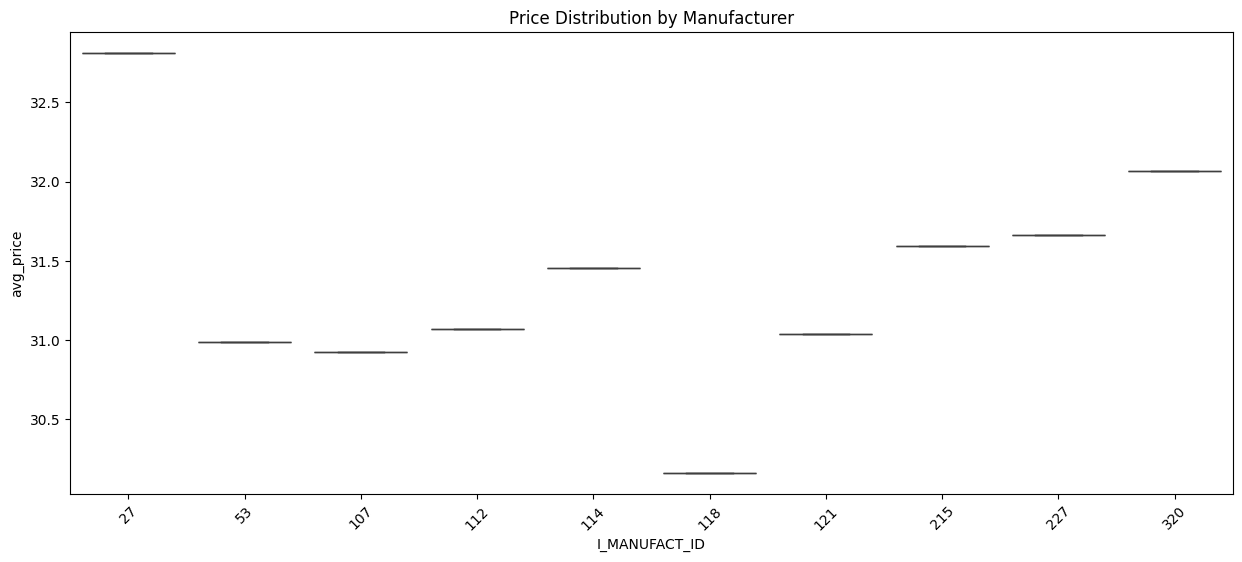

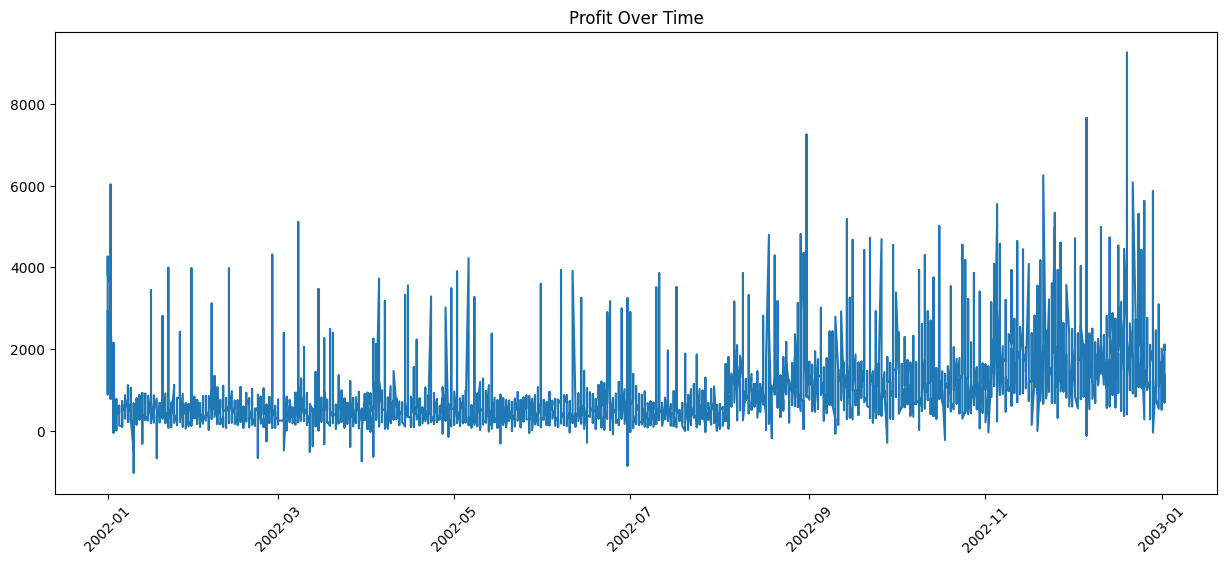

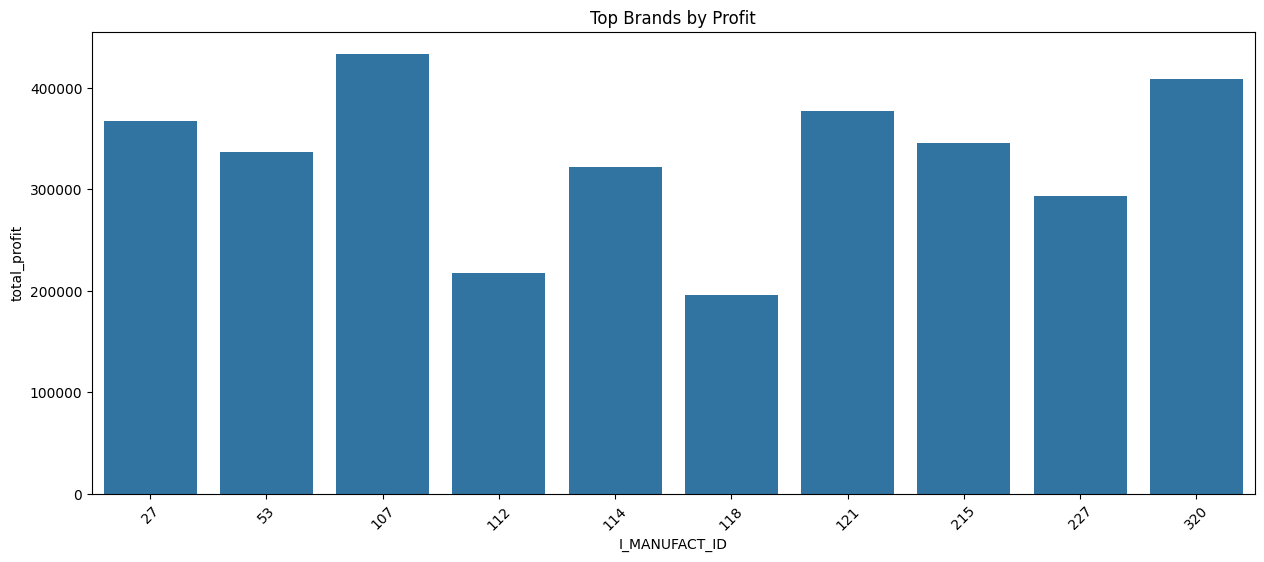

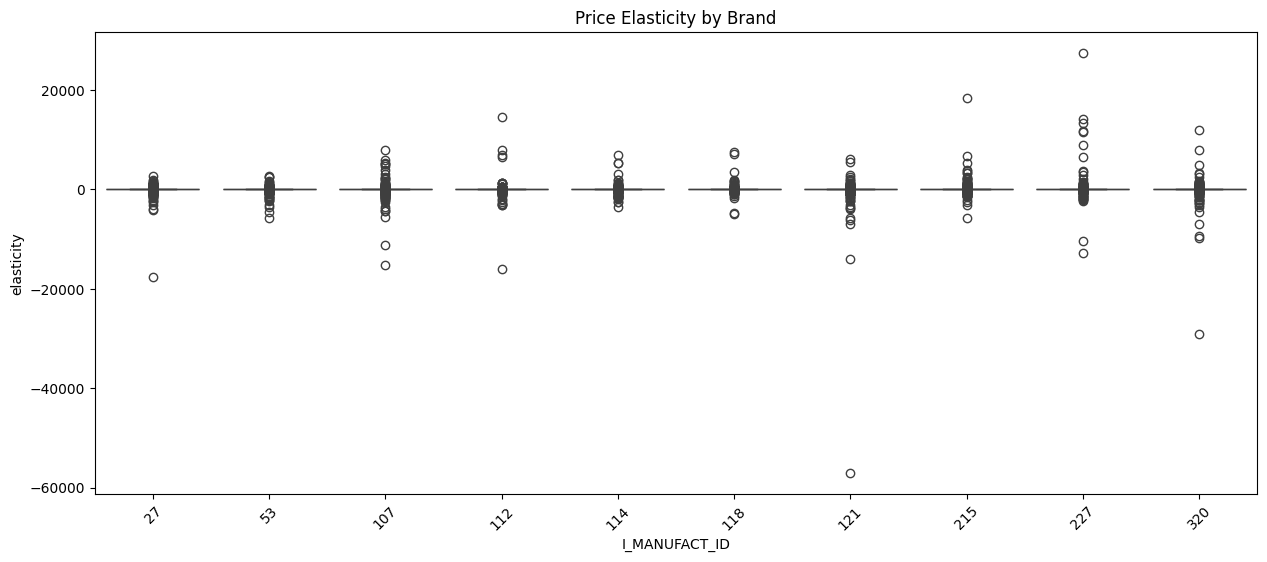

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, avg, sum, count, stddev, year, month,
                                 dayofweek, when, lag, expr)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Price Analysis
def analyze_prices(df):
    """Analyze pricing patterns"""
    price_stats = df.groupBy('I_MANUFACT_ID').agg(
        avg('SS_SALES_PRICE').alias('avg_price'),
        stddev('SS_SALES_PRICE').alias('price_std'),
        avg('SS_WHOLESALE_COST').alias('avg_cost'),
        avg('SS_LIST_PRICE').alias('avg_list_price'),
        avg('SS_NET_PROFIT').alias('avg_profit')
    )

    return price_stats

# Step 3: Time-based Analysis
def analyze_time_patterns(df):
    """Analyze sales patterns over time"""
    time_patterns = df.groupBy('DATE_COLUMN','I_MANUFACT_ID').agg(
        count('SS_TICKET_NUMBER').alias('num_transactions'),
        sum('SS_NET_PROFIT').alias('total_profit'),
        avg('SS_SALES_PRICE').alias('avg_price'),
        sum('SS_QUANTITY').alias('total_quantity')
    ).orderBy('DATE_COLUMN')

    return time_patterns

# Step 4: Brand Analysis
def analyze_brands(df):
    """Analyze performance by brand"""
    brand_metrics = df.groupBy('I_MANUFACT_ID').agg(
        sum('SS_NET_PROFIT').alias('total_profit'),
        avg('SS_SALES_PRICE').alias('avg_price'),
        sum('SS_QUANTITY').alias('total_quantity'),
        count('SS_TICKET_NUMBER').alias('num_transactions')
    ).orderBy('total_profit', ascending=False)

    return brand_metrics

# Step 5: Customer Segment Analysis
def analyze_customer_segments(df):
    """Analyze customer segment behavior"""
    customer_metrics = df.groupBy(
        'CD_EDUCATION_STATUS',
        #'CD_CREDIT_RATING',
        'HD_BUY_POTENTIAL'
    ).agg(
        avg('SS_SALES_PRICE').alias('avg_purchase'),
        sum('SS_QUANTITY').alias('total_quantity'),
        count('SS_TICKET_NUMBER').alias('num_transactions'),
        sum('SS_NET_PROFIT').alias('total_profit')
    )

    return customer_metrics

# Step 6: Price Elasticity Analysis
def calculate_elasticity(df):
    """Calculate price elasticity"""
    window_spec = Window.partitionBy('SS_ITEM_SK').orderBy('DATE_COLUMN')

    elasticity_df = df.select(
        'SS_ITEM_SK',
        'I_MANUFACT_ID',
        'DATE_COLUMN',
        'SS_SALES_PRICE',
        'SS_QUANTITY'
    ).withColumn(
        'prev_price',
        lag('SS_SALES_PRICE').over(window_spec)
    ).withColumn(
        'prev_quantity',
        lag('SS_QUANTITY').over(window_spec)
    ).withColumn(
        'price_change',
        when(col('prev_price').isNotNull(),
             (col('SS_SALES_PRICE') - col('prev_price')) / col('prev_price'))
        .otherwise(None)
    ).withColumn(
        'quantity_change',
        when(col('prev_quantity').isNotNull(),
             (col('SS_QUANTITY') - col('prev_quantity')) / col('prev_quantity'))
        .otherwise(None)
    ).withColumn(
        'elasticity',
        when(col('price_change') != 0,
             col('quantity_change') / col('price_change'))
        .otherwise(None)
    )

    return elasticity_df

def plot_results(price_stats_pdf, time_patterns_pdf, brand_metrics_pdf, elasticity_pdf):
    """Create visualizations"""
    # Price Distribution by Brand
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=price_stats_pdf, x='I_MANUFACT_ID', y='avg_price')
    plt.xticks(rotation=45)
    plt.title('Price Distribution by Manufacturer')
    plt.show()

    # Time Series Plot
    plt.figure(figsize=(15, 6))
    plt.plot(time_patterns_pdf['DATE_COLUMN'], time_patterns_pdf['total_profit'])
    plt.title('Profit Over Time')
    plt.xticks(rotation=45)
    plt.show()

    # Brand Performance
    plt.figure(figsize=(15, 6))
    sns.barplot(data=brand_metrics_pdf.head(10), x='I_MANUFACT_ID', y='total_profit')
    plt.xticks(rotation=45)
    plt.title('Top Brands by Profit')
    plt.show()

    # Elasticity Distribution
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=elasticity_pdf, x='I_MANUFACT_ID', y='elasticity')
    plt.xticks(rotation=45)
    plt.title('Price Elasticity by Brand')
    plt.show()

def main(df):
    """Main analysis pipeline"""
    # Run analyses
    #numeric_stats = analyze_data_quality(df)
    price_stats = analyze_prices(df)
    time_patterns = analyze_time_patterns(df)
    brand_metrics = analyze_brands(df)
    customer_metrics = analyze_customer_segments(df)
    elasticity_df = calculate_elasticity(df)

    # Convert to Pandas for visualization
    plot_results(
        price_stats.toPandas(),
        time_patterns.toPandas(),
        brand_metrics.toPandas(),
        elasticity_df.toPandas()
    )

    return {
        #'numeric_stats': numeric_stats,
        'price_stats': price_stats,
        'time_patterns': time_patterns,
        'brand_metrics': brand_metrics,
        'customer_metrics': customer_metrics,
        'elasticity_df': elasticity_df
    }

results = main(cleaned_df)



Comment: The above code analyzes sales, pricing, and customer behavior to derive insights into price elasticity and market dynamics. The pipeline focuses on identifying pricing patterns, temporal trends, brand performance, customer segment behavior, and calculating price elasticity.

1. **Price Analysis**: Aggregates pricing metrics average price, cost, and profit by manufacturer to uncover pricing patterns and profitability.
2. **Time-Based Analysis**: Analyzes sales trends over time (e.g., daily, monthly) to identify seasonal and temporal patterns in profitability and demand.
3. **Brand Analysis**: Evaluates brand performance using metrics total profit, transactions, and demand to rank top-performing brands.
4. **Customer Segment Analysis**: Studies customer behavior across education levels and buying potential to understand how customer demographics influence purchasing patterns.
5. **Price Elasticity Calculation**: Uses lag features to calculate price and quantity changes over time, estimating elasticity (the sensitivity of demand to price changes).
6. **Visualization**: Plots key results, including price distributions, temporal trends, brand profitability, and elasticity by manufacturer, for actionable insights.



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_enhanced_visualizations(price_stats_pdf, time_patterns_pdf, brand_metrics_pdf, elasticity_pdf):
    """Create enhanced visualizations for price elasticity analysis"""

    # Set the style
    #plt.style.use('seaborn')
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    # 1. Price Analysis Dashboard
    fig = plt.figure(figsize=(20, 15))

    # Price Distribution by Manufacturer
    plt.subplot(2, 2, 1)
    sns.boxplot(data=price_stats_pdf,
                x='I_MANUFACT_ID',
                y='avg_price',
                whis=1.5)
    plt.title('Price Distribution by Manufacturer', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Manufacturer ID', fontsize=10)
    plt.ylabel('Average Price ($)', fontsize=10)

    # Price vs Cost Analysis
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=price_stats_pdf,
                   x='avg_cost',
                   y='avg_price',
                   size='avg_profit',
                   sizes=(50, 400),
                   alpha=0.6)
    plt.title('Price vs Cost Analysis', fontsize=12, pad=20)
    plt.xlabel('Average Cost ($)', fontsize=10)
    plt.ylabel('Average Price ($)', fontsize=10)

    # Margin Analysis
    plt.subplot(2, 2, 3)
    price_stats_pdf['margin_ratio'] = (price_stats_pdf['avg_price'] - price_stats_pdf['avg_cost']) / price_stats_pdf['avg_price']
    sns.barplot(data=price_stats_pdf.sort_values('margin_ratio', ascending=False).head(10),
                x='I_MANUFACT_ID',
                y='margin_ratio')
    plt.title('Top 10 Manufacturers by Margin Ratio', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Manufacturer ID', fontsize=10)
    plt.ylabel('Margin Ratio', fontsize=10)

    # Profit Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(data=price_stats_pdf,
                 x='avg_profit',
                 bins=30,
                 kde=True)
    plt.title('Distribution of Average Profit', fontsize=12, pad=20)
    plt.xlabel('Average Profit ($)', fontsize=10)
    plt.ylabel('Count', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 2. Time Series Analysis Dashboard
    fig = plt.figure(figsize=(20, 15))

    # Daily Profit Trends
    plt.subplot(2, 2, 1)
    sns.lineplot(data=time_patterns_pdf,
                x='DATE_COLUMN',
                y='total_profit',
                ci=None)
    plt.title('Daily Profit Trends', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Total Profit ($)', fontsize=10)

    # Daily Transaction Volume
    plt.subplot(2, 2, 2)
    sns.lineplot(data=time_patterns_pdf,
                x='DATE_COLUMN',
                y='num_transactions',
                ci=None)
    plt.title('Daily Transaction Volume', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Number of Transactions', fontsize=10)

    # Average Price Trends
    plt.subplot(2, 2, 3)
    sns.lineplot(data=time_patterns_pdf,
                x='DATE_COLUMN',
                y='avg_price',
                ci=None)
    plt.title('Average Price Trends', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Average Price ($)', fontsize=10)

    # Quantity Trends
    plt.subplot(2, 2, 4)
    sns.lineplot(data=time_patterns_pdf,
                x='DATE_COLUMN',
                y='total_quantity',
                ci=None)
    plt.title('Daily Sales Volume', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Total Quantity Sold', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 3. Elasticity Analysis Dashboard
    fig = plt.figure(figsize=(20, 15))

    # Elasticity Distribution by Manufacturer
    plt.subplot(2, 2, 1)
    sns.boxplot(data=elasticity_pdf,
                x='I_MANUFACT_ID',
                y='elasticity',
                whis=1.5)
    plt.title('Price Elasticity by Manufacturer', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Manufacturer ID', fontsize=10)
    plt.ylabel('Price Elasticity', fontsize=10)

    # Price Change vs Quantity Change
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=elasticity_pdf,
                    x='price_change',
                    y='quantity_change',
                    alpha=0.5)
    plt.title('Price Change vs Quantity Change', fontsize=12, pad=20)
    plt.xlabel('Price Change (%)', fontsize=10)
    plt.ylabel('Quantity Change (%)', fontsize=10)

    # Elasticity Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(data=elasticity_pdf,
                 x='elasticity',
                 bins=50,
                 kde=True)
    plt.title('Distribution of Price Elasticity', fontsize=12, pad=20)
    plt.xlabel('Price Elasticity', fontsize=10)
    plt.ylabel('Count', fontsize=10)

    # Average Elasticity Over Time
    plt.subplot(2, 2, 4)
    elasticity_time = elasticity_pdf.groupby('DATE_COLUMN')['elasticity'].mean().reset_index()
    sns.lineplot(data=elasticity_time,
                x='DATE_COLUMN',
                y='elasticity',
                ci=None)
    plt.title('Average Elasticity Over Time', fontsize=12, pad=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Average Elasticity', fontsize=10)

    plt.tight_layout()
    plt.show()



In [15]:
    price_stats = analyze_prices(cleaned_df)
    time_patterns = analyze_time_patterns(cleaned_df)
    brand_metrics = analyze_brands(cleaned_df)
    customer_metrics = analyze_customer_segments(cleaned_df)
    elasticity_df = calculate_elasticity(cleaned_df)

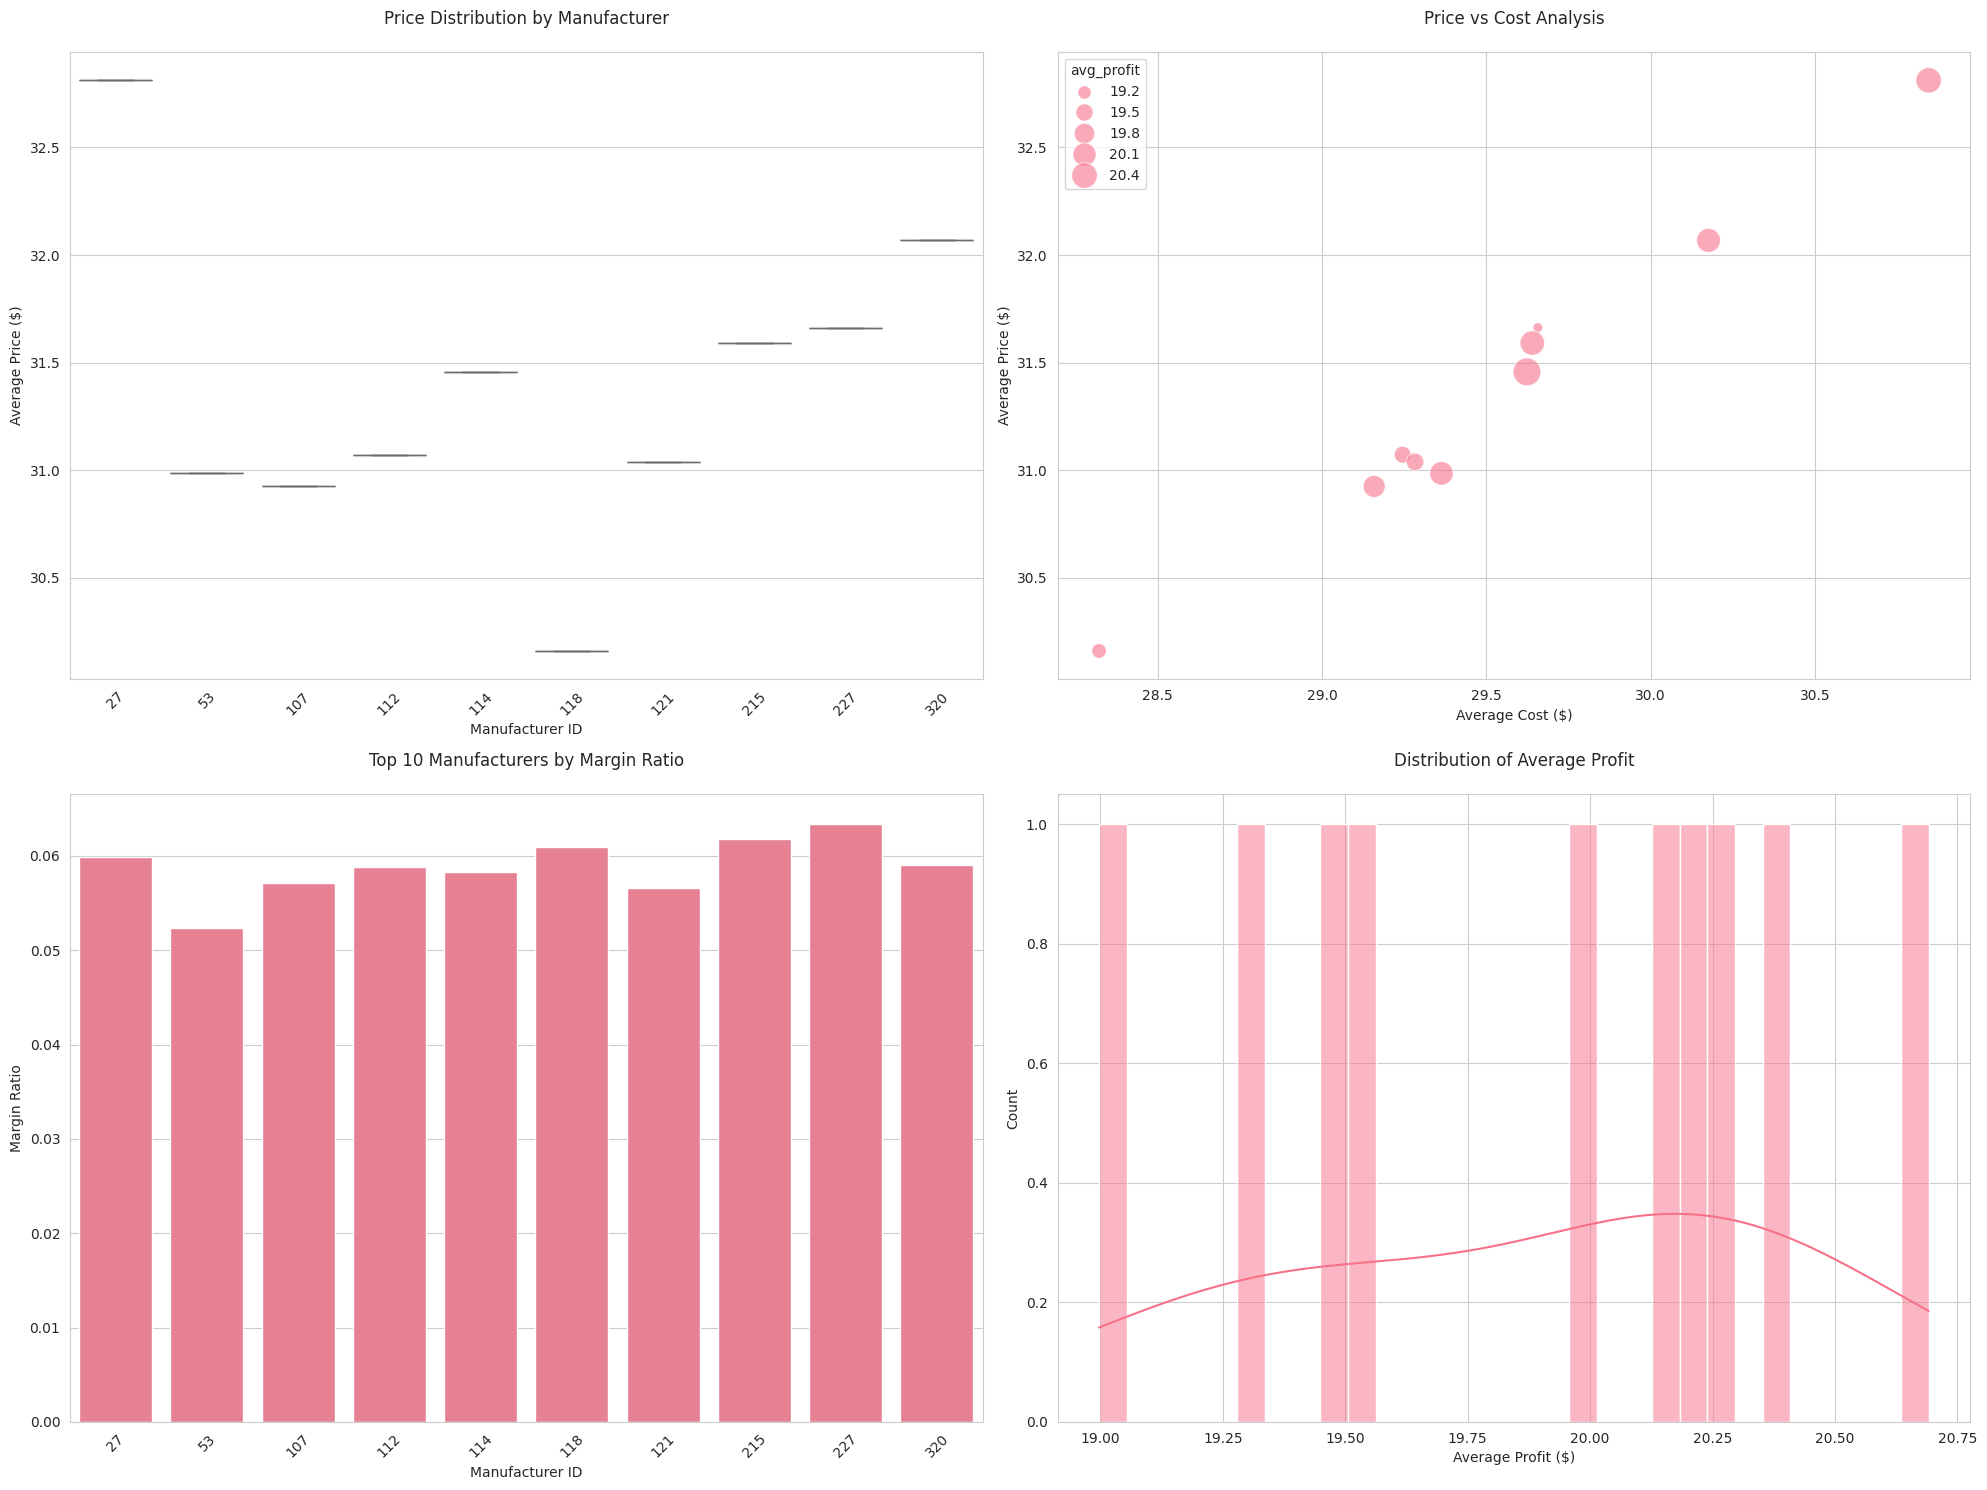

<ipython-input-14-4b2a4a293dbe>:69: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=time_patterns_pdf,
<ipython-input-14-4b2a4a293dbe>:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=time_patterns_pdf,
<ipython-input-14-4b2a4a293dbe>:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=time_patterns_pdf,
<ipython-input-14-4b2a4a293dbe>:102: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=time_patterns_pdf,


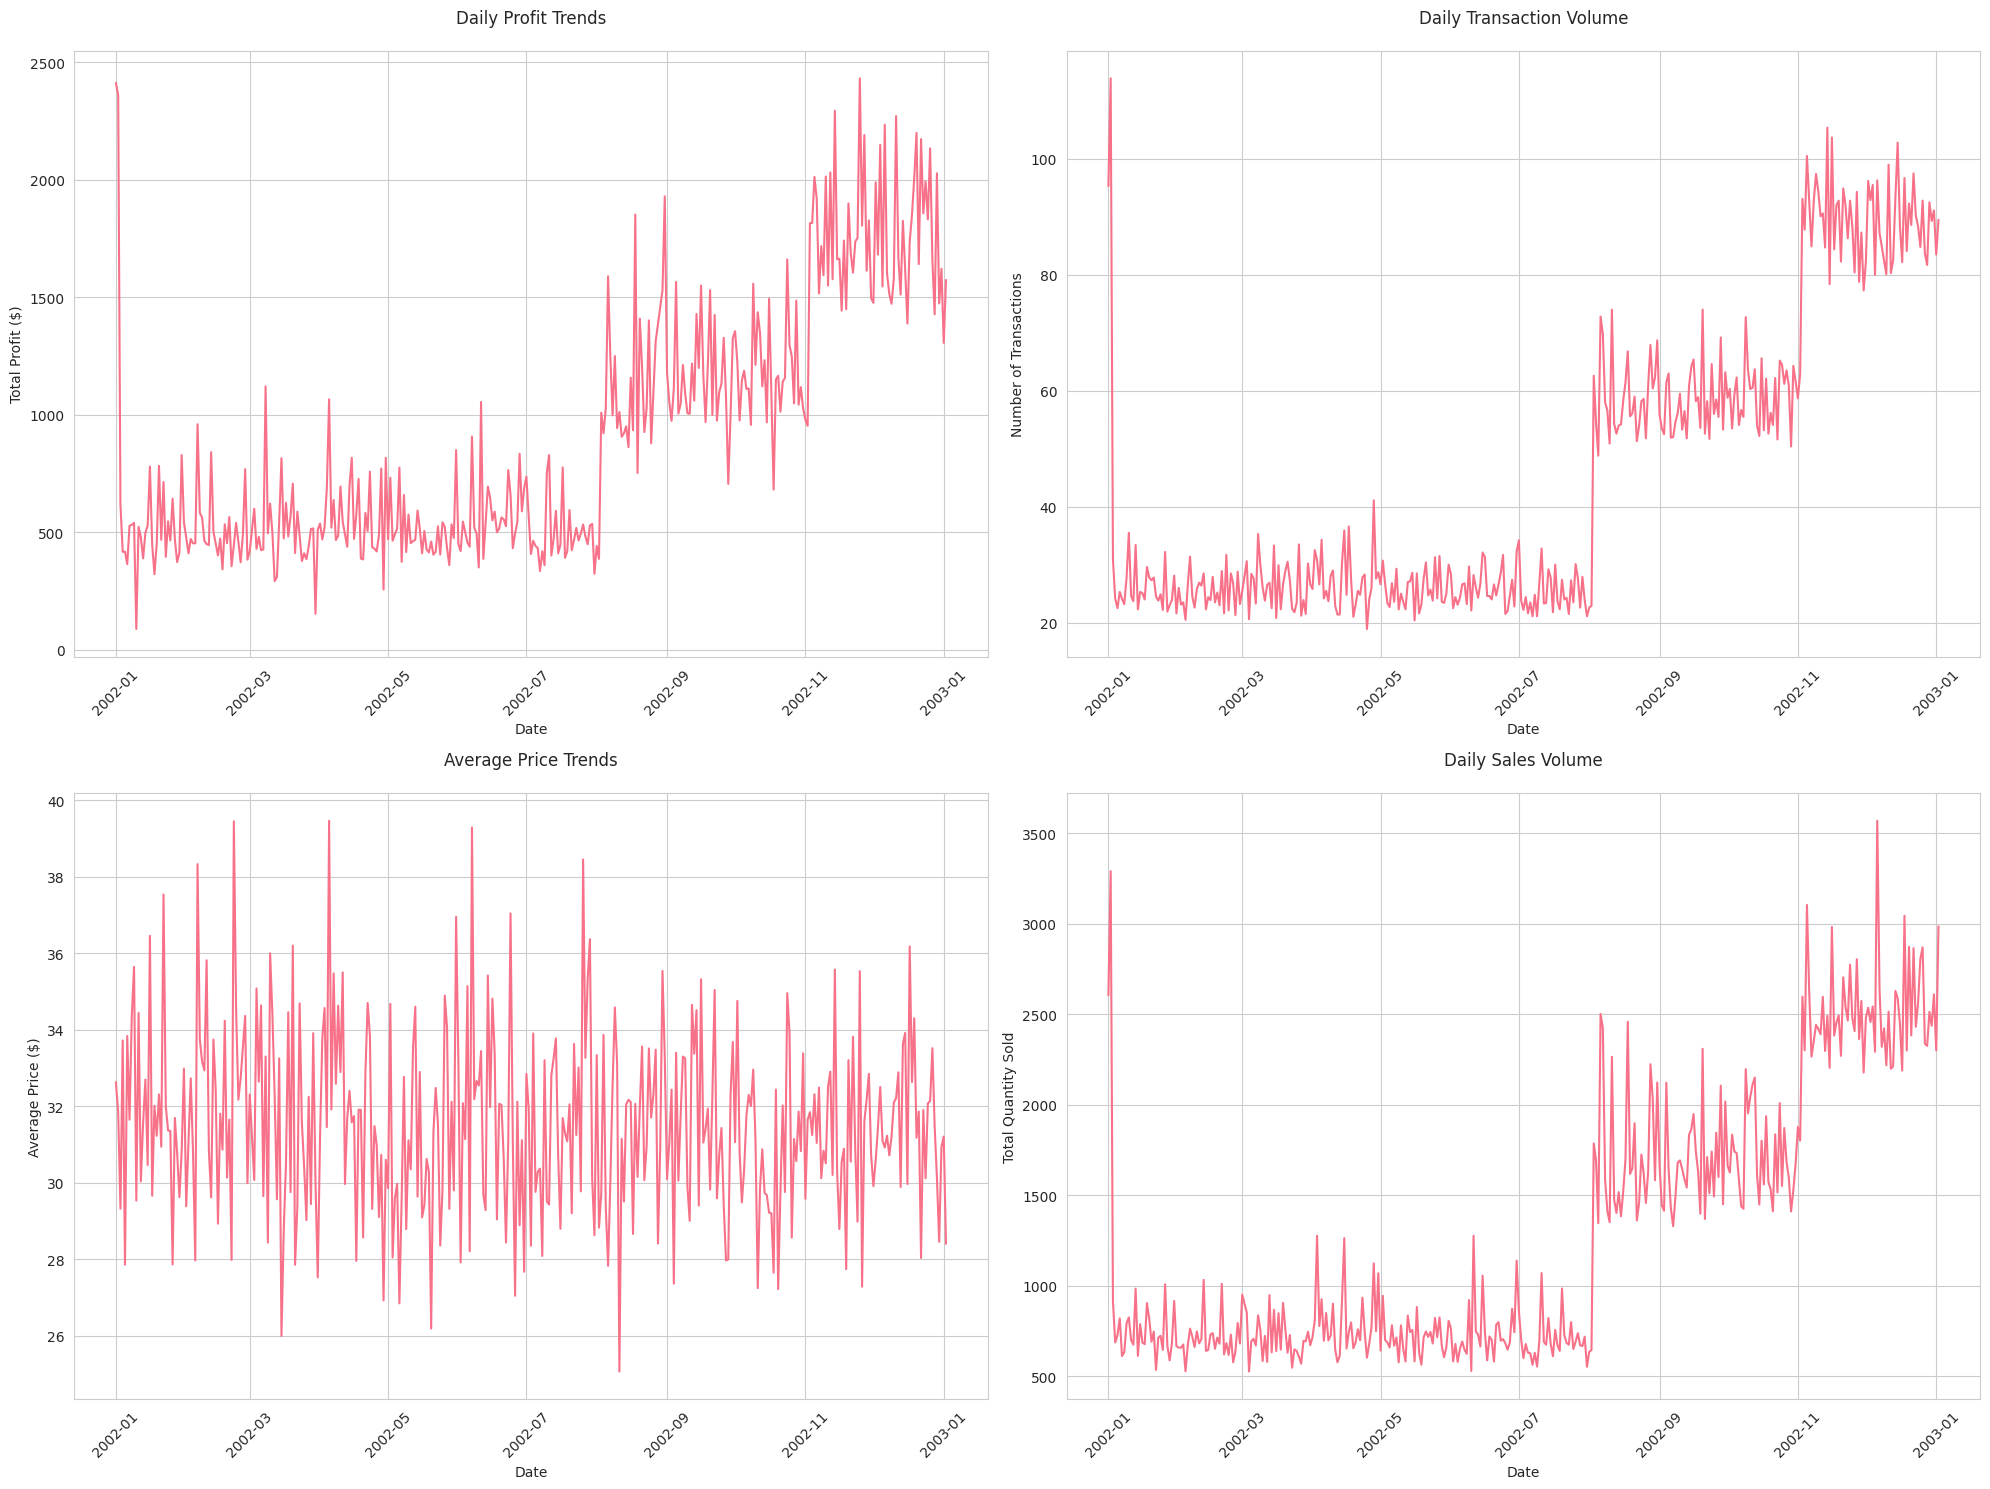

<ipython-input-14-4b2a4a293dbe>:151: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=elasticity_time,


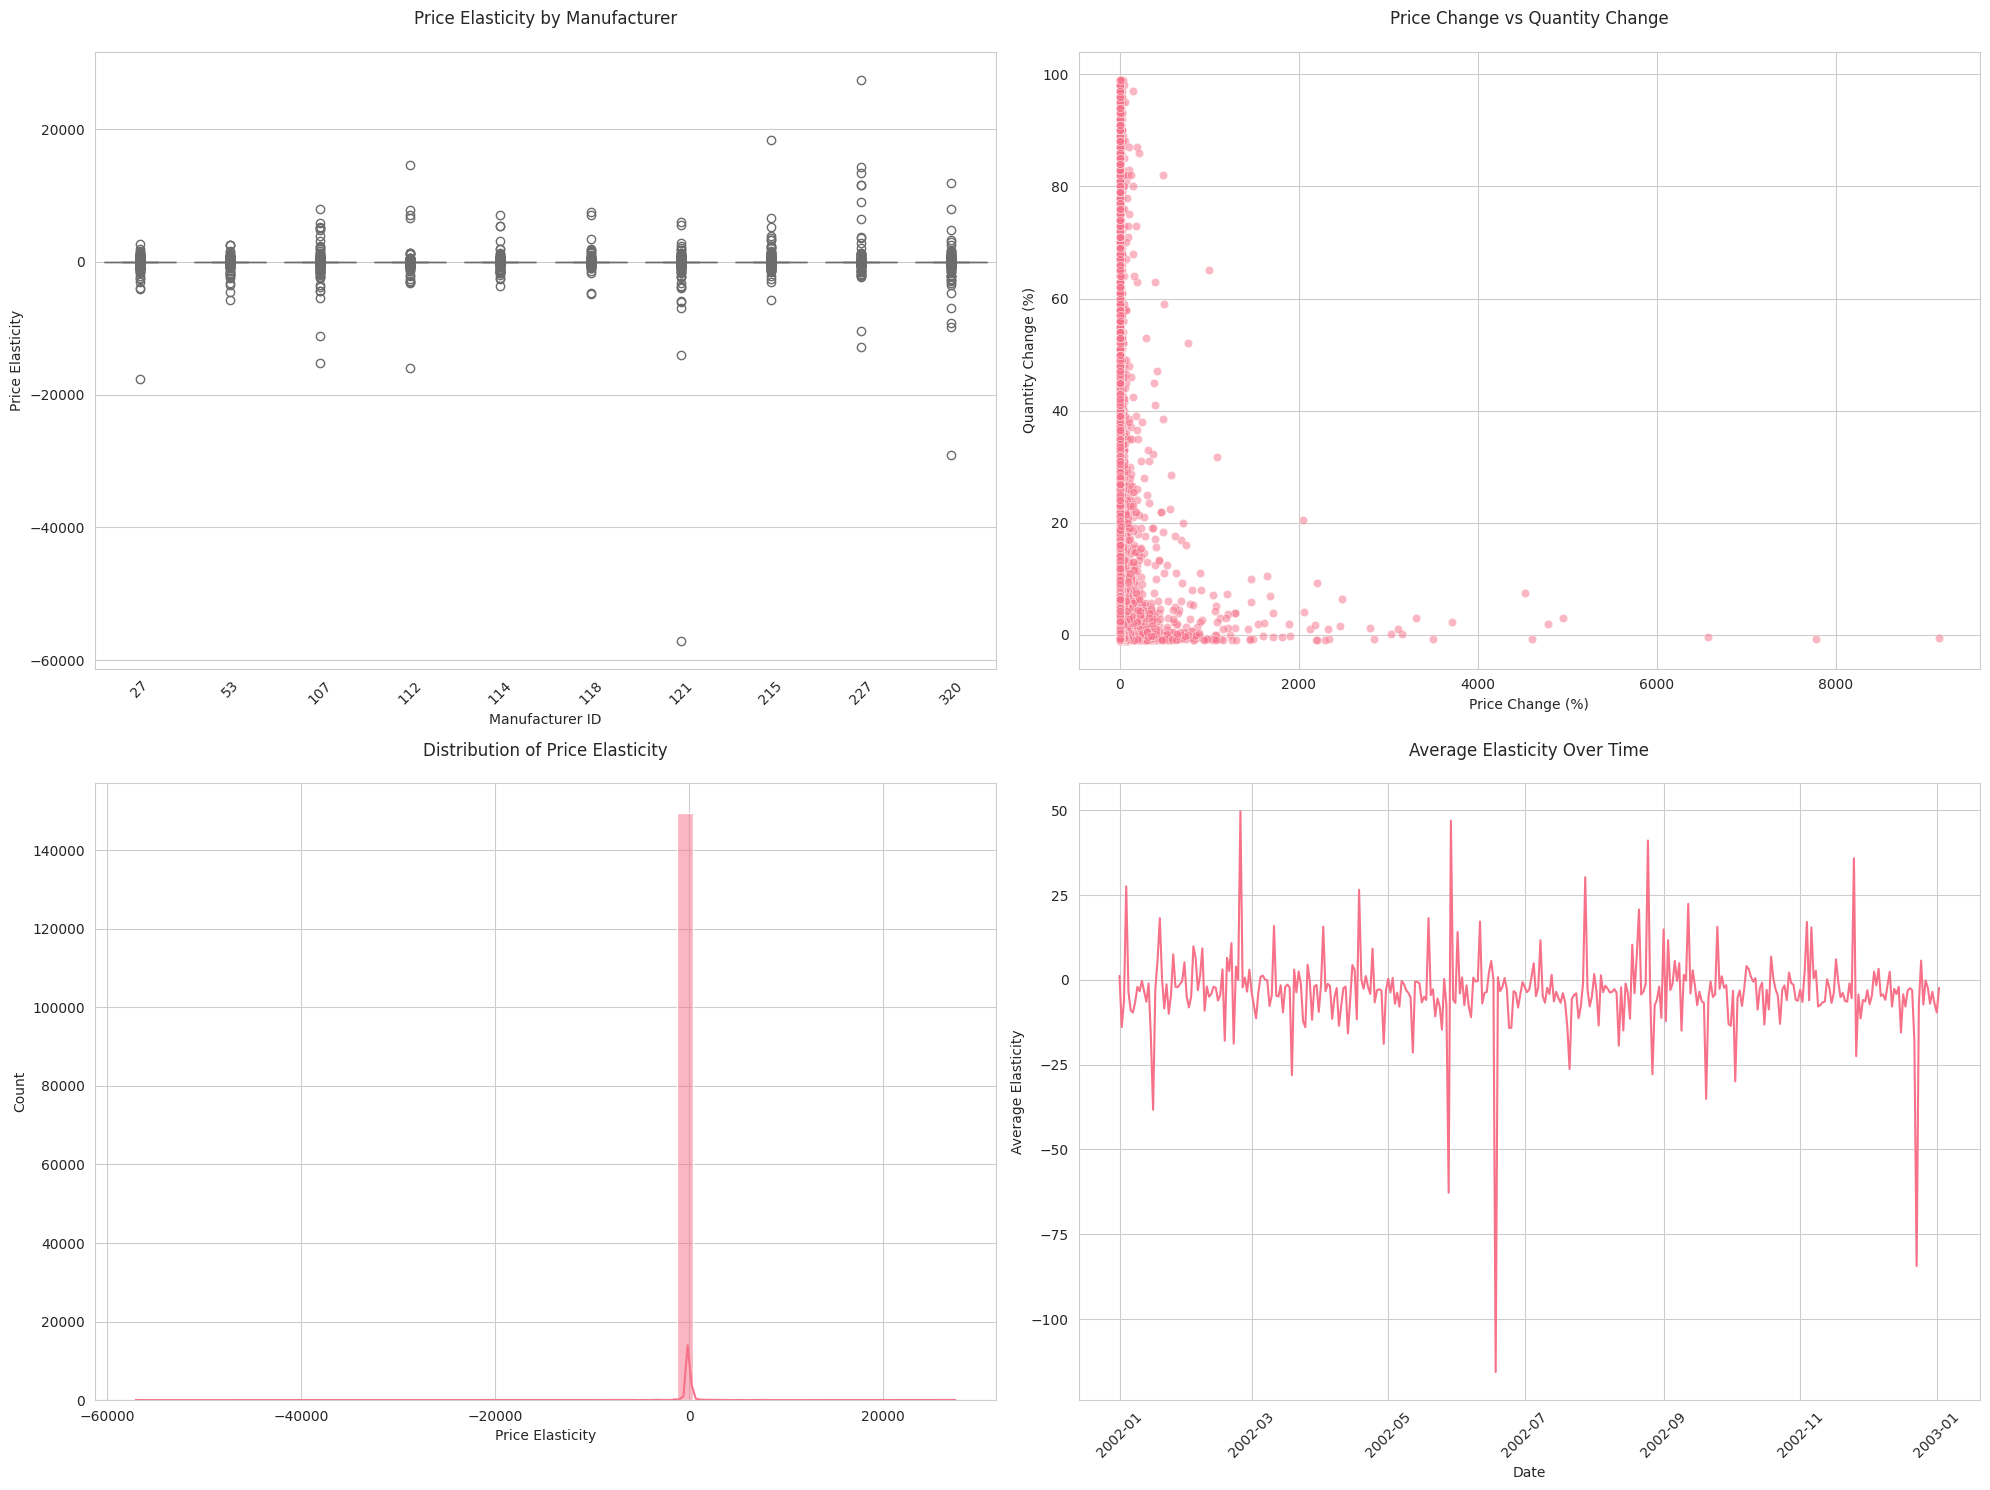

In [16]:
create_enhanced_visualizations(
    price_stats.toPandas(),
    time_patterns.toPandas(),
    brand_metrics.toPandas(),
    elasticity_df.toPandas()
)

Comment:
The above code generates visualizations to support price elasticity analysis and sales performance insights. The visualizations are designed to make patterns in pricing, profitability, sales trends, and elasticity across manufacturers and time more interpretable for stakeholders.


1. Price Analysis:
   - Price Distribution by Manufacturer: Visualizes the spread of prices for each manufacturer to identify variability and pricing strategies.
   - Price vs Cost Analysis: Plots the relationship between average cost and price while highlighting profitabilityy.
   - Margin Analysis: Identifies manufacturers with the highest margin ratios, highlighting products or brands with superior profitability.
   - Profit Distribution: Displays the distribution of average profit to understand overall financial performance.

2. Time Series Analysis:
   - Daily Profit Trends: Tracks profit fluctuations over time to identify seasonal or daily profit patterns.
   - Transaction Volume: Visualizes daily transaction counts, in our time period.
   - Average Price Trends: Displays price changes over time to identify patterns or anomalies in pricing.
   - Daily Sales Volume: Analyzes daily quantities sold, providing insights into demand patterns.

3. Elasticity Analysis:
   - Price Elasticity by Manufacturer: Examines the variability of price elasticity across manufacturers to identify products sensitive to pricing changes.
   - Price Change vs Quantity Change: Shows how percentage changes in price impact demand, offering direct elasticity insights.
   - Elasticity Distribution**: Visualizes the distribution of elasticity values to understand the overall market's responsiveness to pricing.
   - Average Elasticity Over Time: Tracks how elasticity evolves over time, identifying trends that may influence pricing decisions.



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

def currency_formatter(x, p):
    return f'${x:,.0f}'

# Set enhanced style parameters
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.style.use('seaborn-v0_8-whitegrid')

def plot_analysis(price_stats, time_patterns, brand_metrics, customer_metrics, elasticity_df):
    price_stats_pd = price_stats.toPandas() if hasattr(price_stats, 'toPandas') else price_stats
    time_patterns_pd = time_patterns.toPandas() if hasattr(time_patterns, 'toPandas') else time_patterns
    brand_metrics_pd = brand_metrics.toPandas() if hasattr(brand_metrics, 'toPandas') else brand_metrics
    customer_metrics_pd = customer_metrics.toPandas() if hasattr(customer_metrics, 'toPandas') else customer_metrics

    # 1. Enhanced Price-Profit Relationship
    plt.figure(figsize=(15, 10))
    scatter = sns.scatterplot(data=brand_metrics_pd,
                            x='avg_price',
                            y='total_profit',
                            size='num_transactions',
                            hue='I_MANUFACT_ID',
                            alpha=0.7,
                            sizes=(100, 1000))

    corr = brand_metrics_pd['avg_price'].corr(brand_metrics_pd['total_profit'])
    plt.text(0.05, 0.95,
             f'Price-Profit Correlation: {corr:.2f}\nTotal Manufacturers: {len(brand_metrics_pd)}',
             transform=scatter.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.title('Price vs Profit Relationship by Manufacturer', pad=20, fontsize=14)
    plt.xlabel('Average Price ($)', labelpad=10)
    plt.ylabel('Total Profit ($)', labelpad=10)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_formatter))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Manufacturer ID')
    plt.tight_layout()
    plt.show()



    # Enhanced Customer Segment Analysis
    plt.figure(figsize=(15, 10))
    pivot_table = customer_metrics_pd.pivot_table(
        values='avg_purchase',
        index='CD_EDUCATION_STATUS',
        columns='HD_BUY_POTENTIAL',
        aggfunc='mean'
    )

    mask = np.zeros_like(pivot_table)
    mask[np.tril_indices_from(mask)] = True

    sns.heatmap(pivot_table,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                center=pivot_table.mean().mean(),
                cbar_kws={'label': 'Average Purchase Amount ($)'},
                square=True,
                linewidths=0.5)

    plt.title('Customer Segment Analysis: Purchase Patterns', pad=20, fontsize=14)
    plt.xlabel('Buying Potential', labelpad=10)
    plt.ylabel('Education Status', labelpad=10)

    for i in range(pivot_table.shape[0]):
        for j in range(pivot_table.shape[1]):
            text = plt.gca().texts[i * pivot_table.shape[1] + j]
            text.set_text(f'${float(text.get_text()):,.2f}')

    row_means = pivot_table.mean(axis=1)
    for idx, val in enumerate(row_means):
        plt.text(pivot_table.shape[1] + 0.5, idx + 0.5, f'Avg=${val:,.2f}',
                va='center', ha='left', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


    # Time Series Analysis
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Transaction Volume
    time_patterns_pd['rolling_transactions'] = time_patterns_pd['num_transactions'].rolling(7).mean()
    axes[0].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['num_transactions'],
                'b-', alpha=0.3, label='Daily')
    axes[0].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['rolling_transactions'],
                'r-', linewidth=2, label='7-day Moving Average')

    mean_trans = time_patterns_pd['num_transactions'].mean()
    std_trans = time_patterns_pd['num_transactions'].std()
    axes[0].fill_between(time_patterns_pd['DATE_COLUMN'],
                        mean_trans - std_trans,
                        mean_trans + std_trans,
                        alpha=0.2, color='gray', label='±1 SD')
    axes[0].set_title('Daily Transaction Volume', fontsize=12, pad=15)
    axes[0].legend(loc='upper right', frameon=True)
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # Average Price Trends
    time_patterns_pd['rolling_price'] = time_patterns_pd['avg_price'].rolling(7).mean()
    axes[1].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['avg_price'],
                'g-', alpha=0.3, label='Daily')
    axes[1].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['rolling_price'],
                'r-', linewidth=2, label='7-day Moving Average')

    mean_price = time_patterns_pd['avg_price'].mean()
    std_price = time_patterns_pd['avg_price'].std()
    axes[1].fill_between(time_patterns_pd['DATE_COLUMN'],
                        mean_price - std_price,
                        mean_price + std_price,
                        alpha=0.2, color='gray', label='±1 SD')
    axes[1].set_title('Daily Average Price', fontsize=12, pad=15)
    axes[1].legend(loc='upper right', frameon=True)
    axes[1].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    # Profit Trends
    time_patterns_pd['rolling_profit'] = time_patterns_pd['total_profit'].rolling(7).mean()
    axes[2].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['total_profit'],
                'c-', alpha=0.3, label='Daily')
    axes[2].plot(time_patterns_pd['DATE_COLUMN'], time_patterns_pd['rolling_profit'],
                'r-', linewidth=2, label='7-day Moving Average')

    mean_profit = time_patterns_pd['total_profit'].mean()
    std_profit = time_patterns_pd['total_profit'].std()
    axes[2].fill_between(time_patterns_pd['DATE_COLUMN'],
                        mean_profit - std_profit,
                        mean_profit + std_profit,
                        alpha=0.2, color='gray', label='±1 SD')
    axes[2].set_title('Daily Profit Trends', fontsize=12, pad=15)
    axes[2].legend(loc='upper right', frameon=True)
    axes[2].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    plt.tight_layout()
    plt.show()

   #Enhanced Manufacturer Performance Analysis
    brand_summary = brand_metrics_pd.groupby('I_MANUFACT_ID').agg({
        'total_profit': 'sum',
        'total_quantity': 'sum'
    }).reset_index().sort_values('total_profit', ascending=False)

    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()

    bars1 = ax1.bar(np.arange(len(brand_summary)), brand_summary['total_profit'],
                    width=0.4, color='#2ecc71', alpha=0.7, label='Total Profit')
    bars2 = ax2.bar(np.arange(len(brand_summary)) + 0.4, brand_summary['total_quantity'],
                    width=0.4, color='#3498db', alpha=0.7, label='Total Quantity')

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', rotation=0,
                fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', rotation=0,
                fontsize=8)

    mean_profit = brand_summary['total_profit'].mean()
    mean_quantity = brand_summary['total_quantity'].mean()
    ax1.axhline(y=mean_profit, color='#27ae60', linestyle='--', alpha=0.5,
                label=f'Mean Profit (${mean_profit:,.0f})')
    ax2.axhline(y=mean_quantity, color='#2980b9', linestyle='--', alpha=0.5,
                label=f'Mean Quantity ({mean_quantity:,.0f})')

    ax1.set_xlabel('Manufacturer ID', labelpad=10)
    ax1.set_ylabel('Total Profit ($)', labelpad=10)
    ax2.set_ylabel('Total Quantity', labelpad=10)

    ax1.set_xticks(np.arange(len(brand_summary)) + 0.4)
    ax1.set_xticklabels(brand_summary['I_MANUFACT_ID'], rotation=45)

    ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Manufacturer Performance Analysis', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()


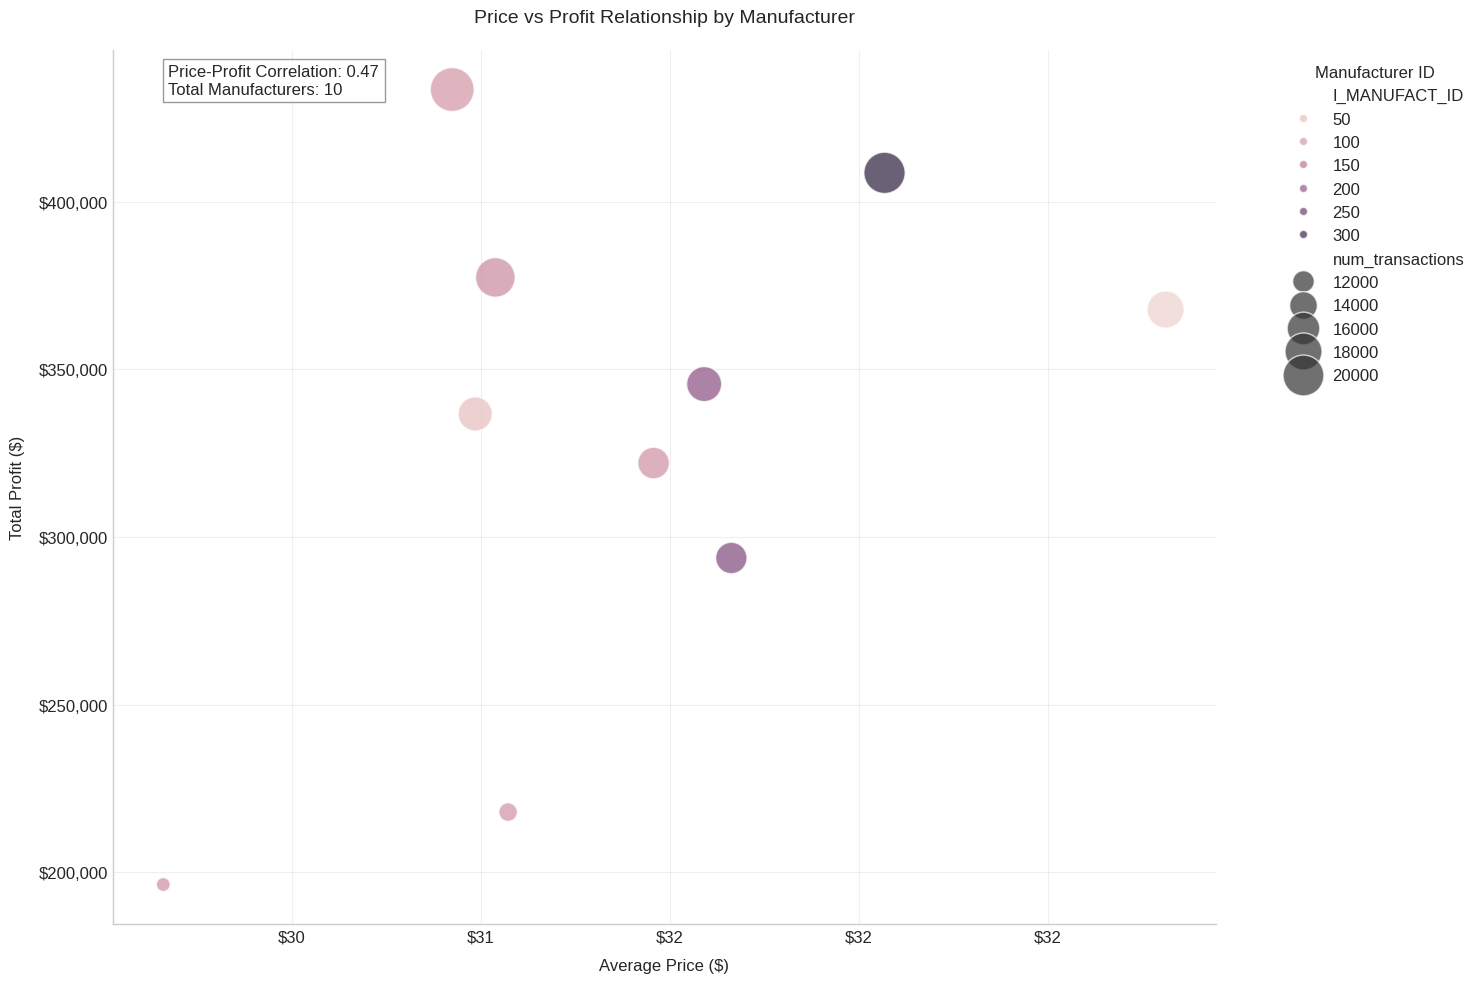

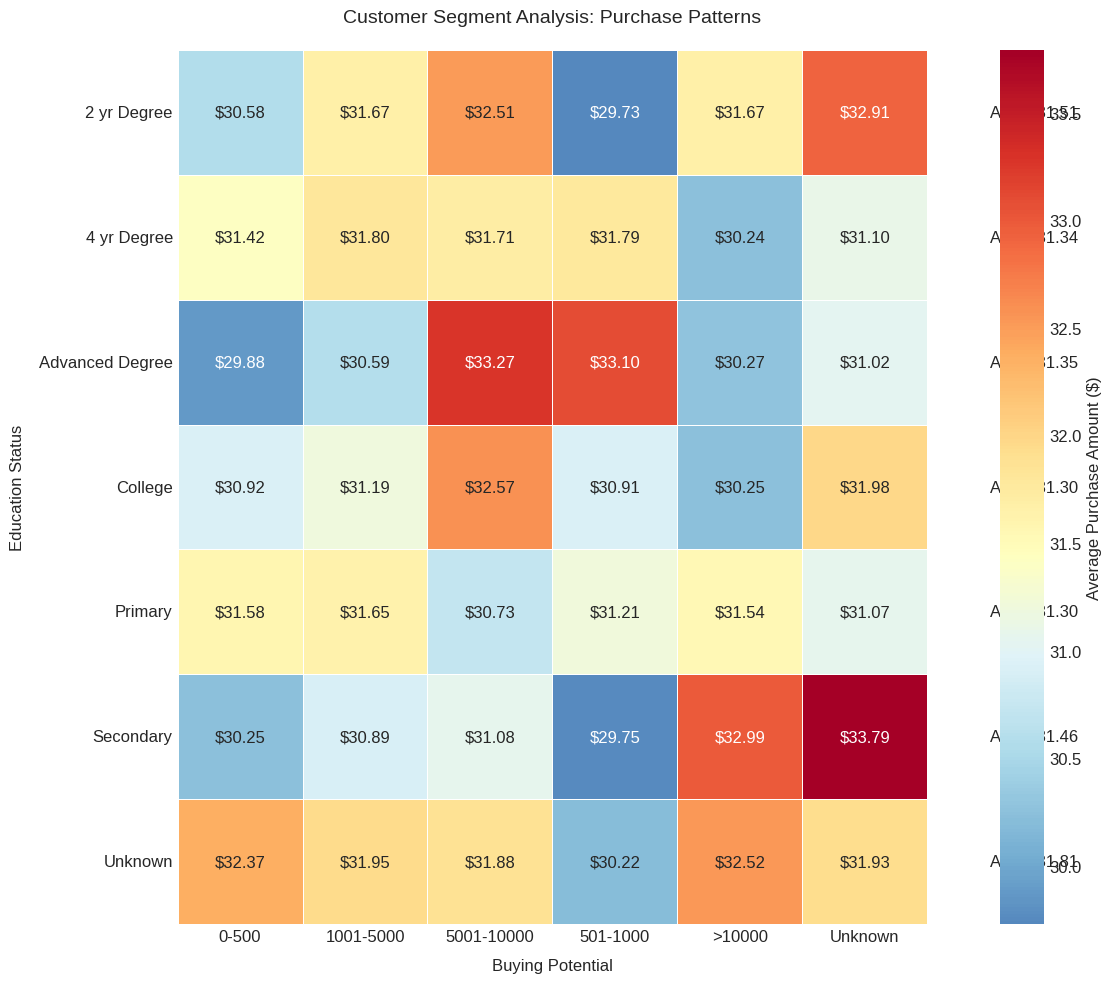

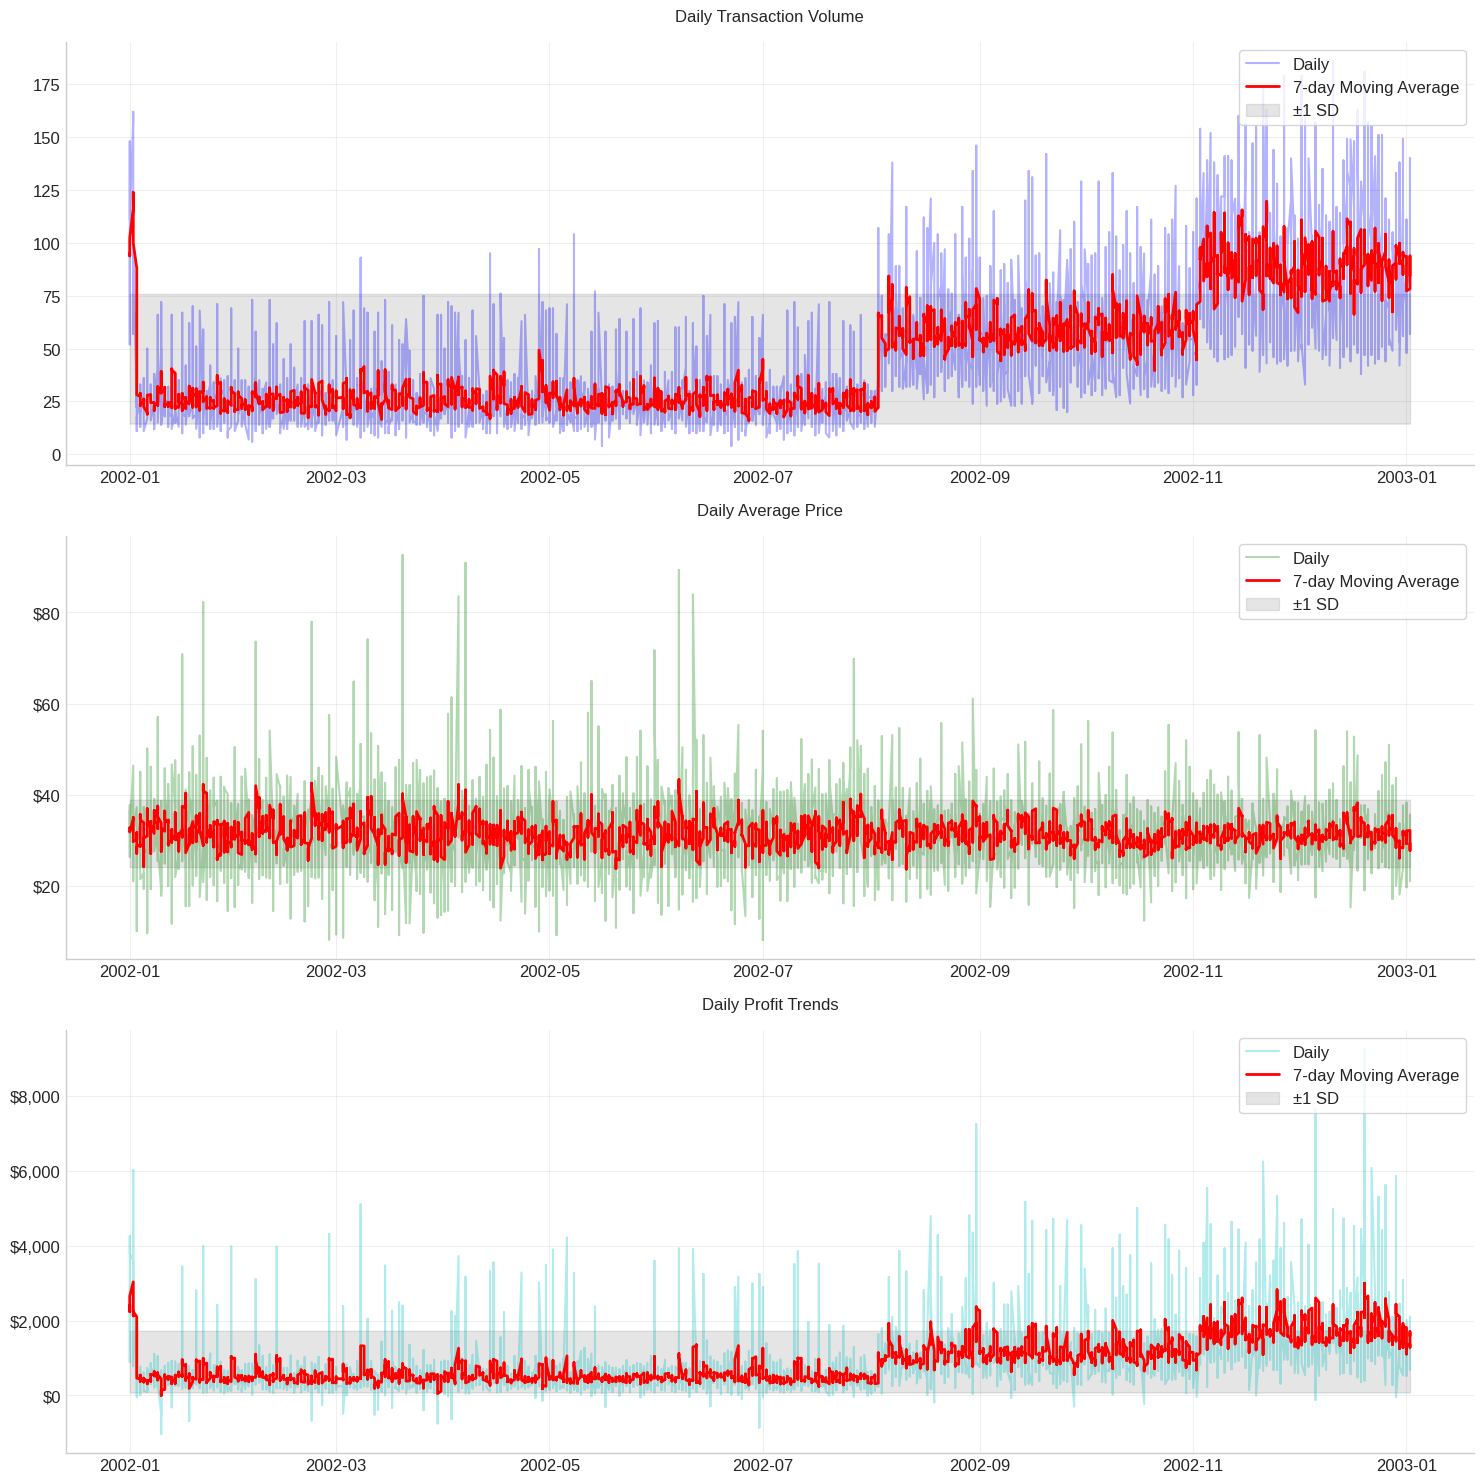

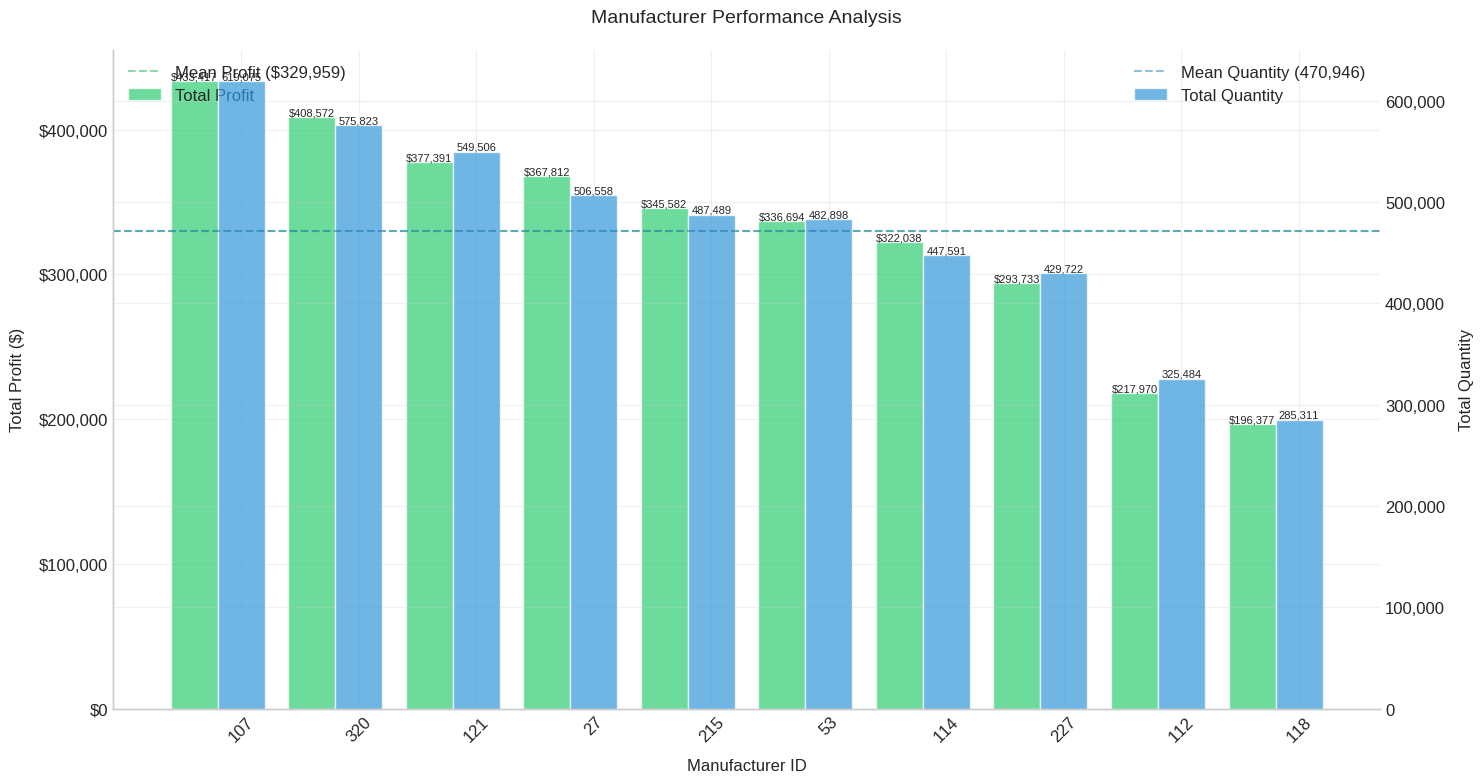

In [18]:
plot_analysis(
    price_stats,
    time_patterns,
    brand_metrics,
    customer_metrics,
    elasticity_df
)

Comment:
ThE above code chunk creates enhanced visualizations to analyze price, profit, customer behavior, time patterns, and manufacturer performance. The visualizations explore the relationship between price and profit by manufacturer, with transaction volume as a size indicator. Heatmaps are used to analyze customer purchase patterns across education levels and buying potential, providing insights into how different segments contribute to revenue. Time series plots with rolling averages for transaction volume, average price, and total profit reveal temporal trends and highlight seasonal effects. Manufacturer performance is analyzed through bar charts comparing total profit and total quantity sold for each manufacturer.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

def format_currency(x, p):
    return f'${x:,.0f}'

def visualize_product_manufacturer_analysis(analysis_results):
    """Create visualizations for product-manufacturer analysis results"""


    prod_manuf_holiday = analysis_results['prod_manuf_holiday'].toPandas()
    holiday_vs_regular = analysis_results['holiday_vs_regular'].toPandas()
    price_sensitivity = analysis_results['price_sensitivity'].toPandas()
    moving_avg_trends = analysis_results['moving_avg_trends'].toPandas()
    discount_response = analysis_results['discount_response'].toPandas()
    state_performance = analysis_results['state_performance'].toPandas()

    # Set style parameters
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 12

    # 1. Holiday Period Performance
    plt.figure(figsize=(15, 10))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Profit by Holiday Period
    holiday_summary = prod_manuf_holiday.groupby('holiday_period').agg({
        'total_profit': 'sum',
        'total_quantity': 'sum'
    }).reset_index()

    sns.barplot(data=holiday_summary, x='holiday_period', y='total_profit', ax=ax1)
    ax1.set_title('Total Profit by Holiday Period', pad=15)
    ax1.set_ylabel('Total Profit')
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency))

    # Average Quantity by Holiday Period
    sns.barplot(data=holiday_summary, x='holiday_period', y='total_quantity', ax=ax2)
    ax2.set_title('Total Quantity Sold by Holiday Period', pad=15)
    ax2.set_ylabel('Total Quantity')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

    plt.tight_layout()
    plt.show()

    # 2. Price Sensitivity Analysis
    plt.figure(figsize=(15, 8))

    sns.scatterplot(data=price_sensitivity,
                    x='avg_price',
                    y='price_quantity_correlation',
                    size='total_profit',
                    hue='avg_quantity',
                    sizes=(50, 500),
                    alpha=0.6)

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.title('Price Sensitivity vs Average Price', pad=15)
    plt.xlabel('Average Price')
    plt.ylabel('Price-Quantity Correlation')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))

    plt.tight_layout()
    plt.show()

    # 3. State Performance Analysis
    plt.figure(figsize=(15, 10))

    # Create pivot table for state performance
    state_pivot = state_performance.pivot_table(
        values='total_profit',
        index='S_STATE',
        columns='I_MANUFACT_ID',
        aggfunc='sum'
    )

    sns.heatmap(state_pivot,
                cmap='RdYlBu_r',
                center=0,
                annot=True,
                fmt=',.0f',
                cbar_kws={'label': 'Total Profit ($)'})

    plt.title('Profit by State and Manufacturer', pad=15)
    plt.xlabel('Manufacturer ID')
    plt.ylabel('State')

    plt.tight_layout()
    plt.show()

    # 4. Discount Impact Analysis
    plt.figure(figsize=(15, 8))

    discount_summary = discount_response.groupby('P_DISCOUNT_ACTIVE').agg({
        'avg_quantity': 'mean',
        'avg_price': 'mean',
        'total_profit': 'sum'
    }).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Quantity comparison
    sns.barplot(data=discount_summary,
                x='P_DISCOUNT_ACTIVE',
                y='avg_quantity',
                ax=ax1)
    ax1.set_title('Average Quantity by Discount Status')
    ax1.set_xlabel('Discount Active')
    ax1.set_ylabel('Average Quantity')

    # Profit comparison
    sns.barplot(data=discount_summary,
                x='P_DISCOUNT_ACTIVE',
                y='total_profit',
                ax=ax2)
    ax2.set_title('Total Profit by Discount Status')
    ax2.set_xlabel('Discount Active')
    ax2.set_ylabel('Total Profit')
    ax2.yaxis.set_major_formatter(FuncFormatter(format_currency))

    plt.tight_layout()
    plt.show()

    # 5. Moving Average Trends
    plt.figure(figsize=(15, 10))


    top_manufacturers = moving_avg_trends.groupby('I_MANUFACT_ID')['avg_7d_price'].mean()\
                                        .sort_values(ascending=False)\
                                        .head(5).index

    moving_avg_filtered = moving_avg_trends[
        moving_avg_trends['I_MANUFACT_ID'].isin(top_manufacturers)
    ]


    sns.lineplot(data=moving_avg_filtered,
                x='I_MANUFACT_ID',
                y='avg_7d_price',
                label='7-day MA')
    sns.lineplot(data=moving_avg_filtered,
                x='I_MANUFACT_ID',
                y='avg_30d_price',
                label='30-day MA')
    sns.lineplot(data=moving_avg_filtered,
                x='I_MANUFACT_ID',
                y='avg_60d_price',
                label='60-day MA')

    plt.title('Price Moving Averages by Manufacturer', pad=15)
    plt.xlabel('Manufacturer ID')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))

    plt.tight_layout()
    plt.show()


In [20]:
def add_temporal_features(df):
    """Add temporal and holiday features to dataframe"""

    # Add weekend indicator
    df = df.withColumn(
        "is_weekend",
        F.dayofweek("DATE_COLUMN").isin([1, 7]).cast("int")
    )

    # Define holiday periods
    df = df.withColumn(
        "holiday_period",
        F.when(
            ((F.month("DATE_COLUMN") == 12) & (F.dayofmonth("DATE_COLUMN") >= 15)) |
            ((F.month("DATE_COLUMN") == 1) & (F.dayofmonth("DATE_COLUMN") <= 1)),
            "Christmas/NY"
        ).when(
            ((F.month("DATE_COLUMN") == 11) & (F.dayofmonth("DATE_COLUMN") >= 15)) |
            ((F.month("DATE_COLUMN") == 12) & (F.dayofmonth("DATE_COLUMN") <= 3)),
            "Thanksgiving"
        ).when(
            (F.month("DATE_COLUMN") == 7) & (F.dayofmonth("DATE_COLUMN") == 4),
            "July 4th"
        ).otherwise("Regular")
    )

    # Add holiday indicators
    df = df.withColumn(
        "is_christmas_and_newyear",
        (F.col("holiday_period") == "Christmas/NY").cast("int")
    )

    df = df.withColumn(
        "is_thanksgiving",
        (F.col("holiday_period") == "Thanksgiving").cast("int")
    )

    df = df.withColumn(
        "is_july_4",
        (F.col("holiday_period") == "July 4th").cast("int")
    )

    # Modified window specs using RANGE
    window_specs = {
        '7d': Window.partitionBy("SS_ITEM_SK", "I_MANUFACT_ID")
                    .orderBy("DATE_COLUMN")
                    .rowsBetween(-7, 0),
        '30d': Window.partitionBy("SS_ITEM_SK", "I_MANUFACT_ID")
                    .orderBy("DATE_COLUMN")
                    .rowsBetween(-30, 0),
        '60d': Window.partitionBy("SS_ITEM_SK", "I_MANUFACT_ID")
                    .orderBy("DATE_COLUMN")
                    .rowsBetween(-60, 0)
    }

    # Add moving averages
    for period, window in window_specs.items():
        df = df.withColumn(
            f"qty_ma_{period}",
            F.avg("SS_QUANTITY").over(window)
        )
        df = df.withColumn(
            f"price_ma_{period}",
            F.avg("SS_SALES_PRICE").over(window)
        )

    return df

def analyze_product_manufacturer_performance(df):
    """Analyze performance of product-manufacturer combinations"""

    # 1. Holiday Period Performance
    prod_manuf_holiday = df.filter(
        F.col("holiday_period") != "Regular"
    ).groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID",
        "holiday_period"
    ).agg(
        F.sum("SS_QUANTITY").alias("total_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count"),
        F.avg("SS_NET_PROFIT").alias("avg_profit_per_transaction")
    ).orderBy("holiday_period", F.desc("total_profit"))

    # 2. Price Sensitivity Analysis
    price_sensitivity = df.groupBy(
        "SS_ITEM_SK",
        "I_MANUFACT_ID"
    ).agg(
        F.corr("SS_SALES_PRICE", "SS_QUANTITY").alias("price_quantity_correlation"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.stddev("SS_SALES_PRICE").alias("price_stddev"),
        F.avg("SS_QUANTITY").alias("avg_quantity"),
        F.sum("SS_NET_PROFIT").alias("total_profit")
    ).orderBy(F.abs(F.col("price_quantity_correlation")).desc())

    # 3. State Performance Analysis
    state_performance = df.groupBy(
        "S_STATE",
        "I_MANUFACT_ID"
    ).agg(
        F.sum("SS_QUANTITY").alias("total_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count")
    ).orderBy("S_STATE", F.desc("total_profit"))

    # 4. Discount Analysis
    discount_analysis = df.groupBy(
        "I_MANUFACT_ID",
        "P_DISCOUNT_ACTIVE"
    ).agg(
        F.avg("SS_QUANTITY").alias("avg_quantity"),
        F.avg("SS_SALES_PRICE").alias("avg_price"),
        F.sum("SS_NET_PROFIT").alias("total_profit"),
        F.count("*").alias("transaction_count")
    )

    return {
        'prod_manuf_holiday': prod_manuf_holiday,
        'price_sensitivity': price_sensitivity,
        'state_performance': state_performance,
        'discount_analysis': discount_analysis
    }

def visualize_product_manufacturer_analysis(analysis_results):
    """Create visualizations for product-manufacturer analysis results"""

    # Convert Spark DataFrames to pandas
    prod_manuf_holiday = analysis_results['prod_manuf_holiday'].toPandas()
    price_sensitivity = analysis_results['price_sensitivity'].toPandas()
    state_performance = analysis_results['state_performance'].toPandas()
    discount_analysis = analysis_results['discount_analysis'].toPandas()

    # Set style parameters
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 12

    # 1. Holiday Period Performance
    plt.figure(figsize=(15, 10))

    holiday_summary = prod_manuf_holiday.groupby('holiday_period').agg({
        'total_profit': 'sum',
        'total_quantity': 'sum'
    }).reset_index()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Profit by Holiday
    sns.barplot(data=holiday_summary, x='holiday_period', y='total_profit', ax=ax1)
    ax1.set_title('Total Profit by Holiday Period', pad=15)
    ax1.set_ylabel('Total Profit ($)')
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency))
    ax1.tick_params(axis='x', rotation=45)

    # Quantity by Holiday
    sns.barplot(data=holiday_summary, x='holiday_period', y='total_quantity', ax=ax2)
    ax2.set_title('Total Quantity Sold by Holiday Period', pad=15)
    ax2.set_ylabel('Total Quantity')
    ax2.yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 2. Price Sensitivity
    plt.figure(figsize=(15, 8))

    sns.scatterplot(data=price_sensitivity,
                    x='avg_price',
                    y='price_quantity_correlation',
                    size='total_profit',
                    hue='avg_quantity',
                    sizes=(50, 500),
                    alpha=0.6)

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.title('Price Sensitivity Analysis', pad=15)
    plt.xlabel('Average Price ($)')
    plt.ylabel('Price-Quantity Correlation')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))

    plt.tight_layout()
    plt.show()

    # 3. State Performance
    plt.figure(figsize=(15, 10))

    state_pivot = state_performance.pivot_table(
        values='total_profit',
        index='S_STATE',
        columns='I_MANUFACT_ID',
        aggfunc='sum'
    )

    sns.heatmap(state_pivot,
                cmap='RdYlBu_r',
                center=0,
                annot=True,
                fmt=',.0f',
                cbar_kws={'label': 'Total Profit ($)'})

    plt.title('Profit by State and Manufacturer', pad=15)
    plt.xlabel('Manufacturer ID')
    plt.ylabel('State')

    plt.tight_layout()
    plt.show()

    # 4. Discount Impact
    plt.figure(figsize=(15, 8))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Average Quantity by Discount Status
    sns.boxplot(data=discount_analysis,
                x='P_DISCOUNT_ACTIVE',
                y='avg_quantity',
                ax=ax1)
    ax1.set_title('Quantity Distribution by Discount Status')
    ax1.set_xlabel('Discount Active')
    ax1.set_ylabel('Average Quantity')

    # Total Profit by Discount Status
    sns.boxplot(data=discount_analysis,
                x='P_DISCOUNT_ACTIVE',
                y='total_profit',
                ax=ax2)
    ax2.set_title('Profit Distribution by Discount Status')
    ax2.set_xlabel('Discount Active')
    ax2.set_ylabel('Total Profit ($)')
    ax2.yaxis.set_major_formatter(FuncFormatter(format_currency))

    plt.tight_layout()
    plt.show()


<Figure size 1500x1000 with 0 Axes>

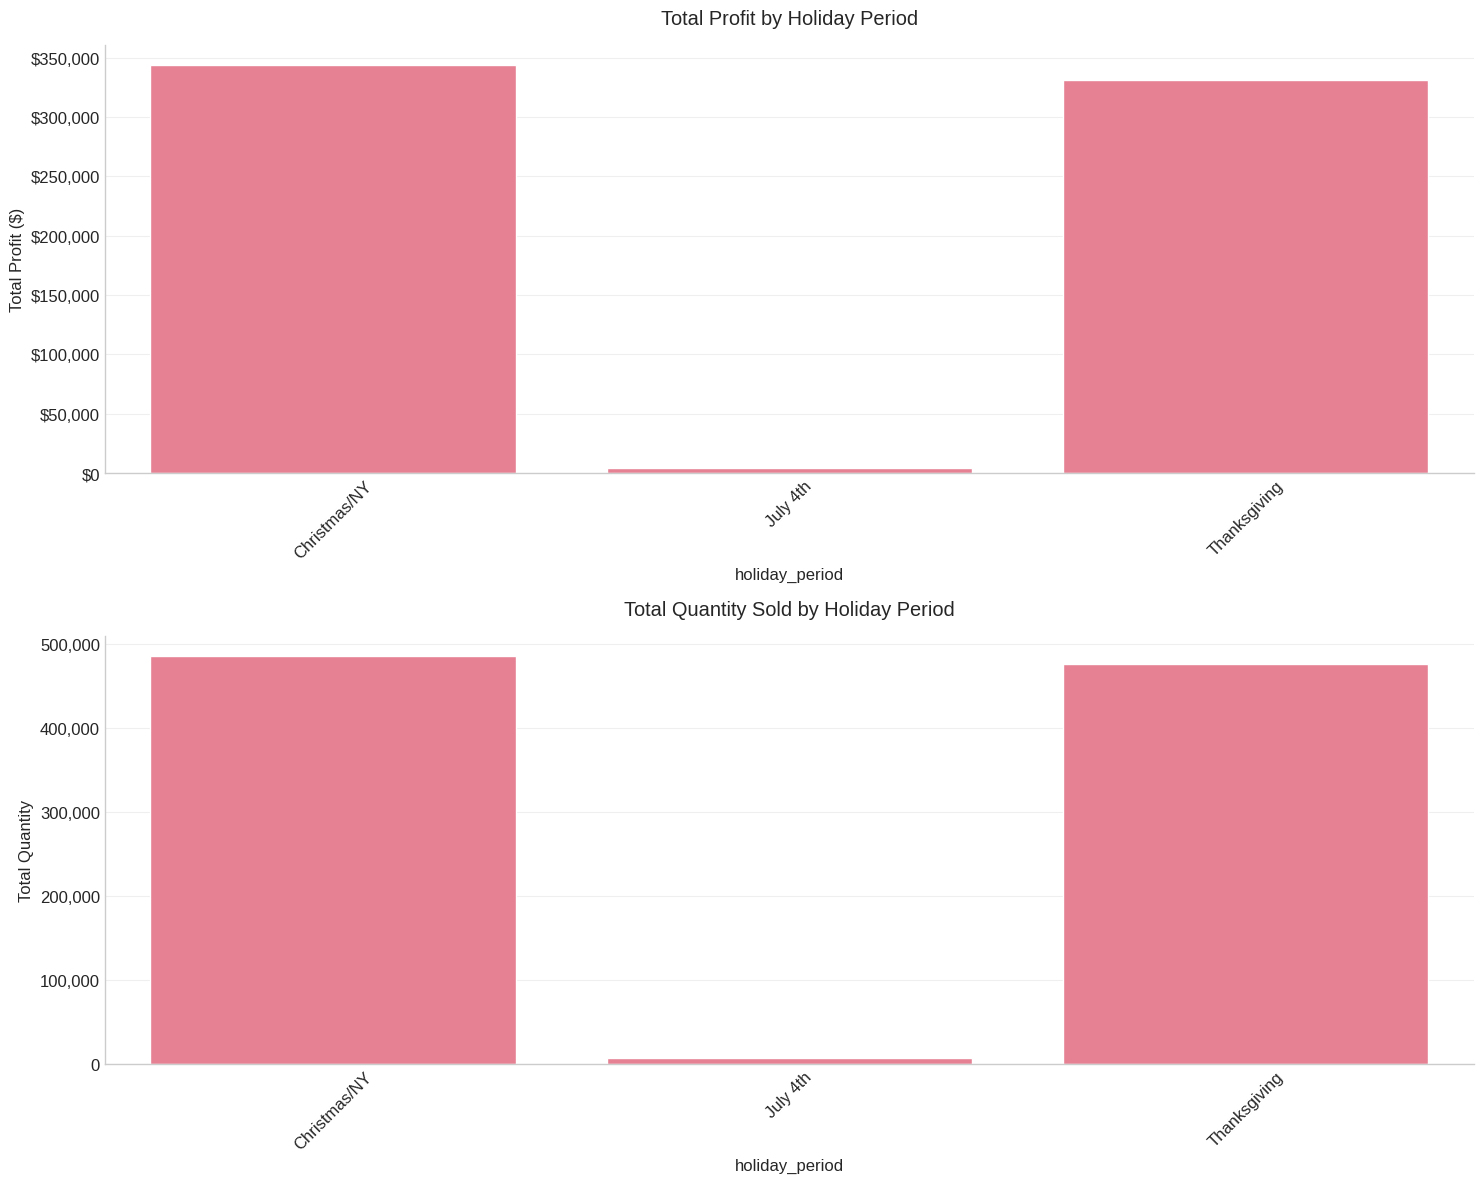

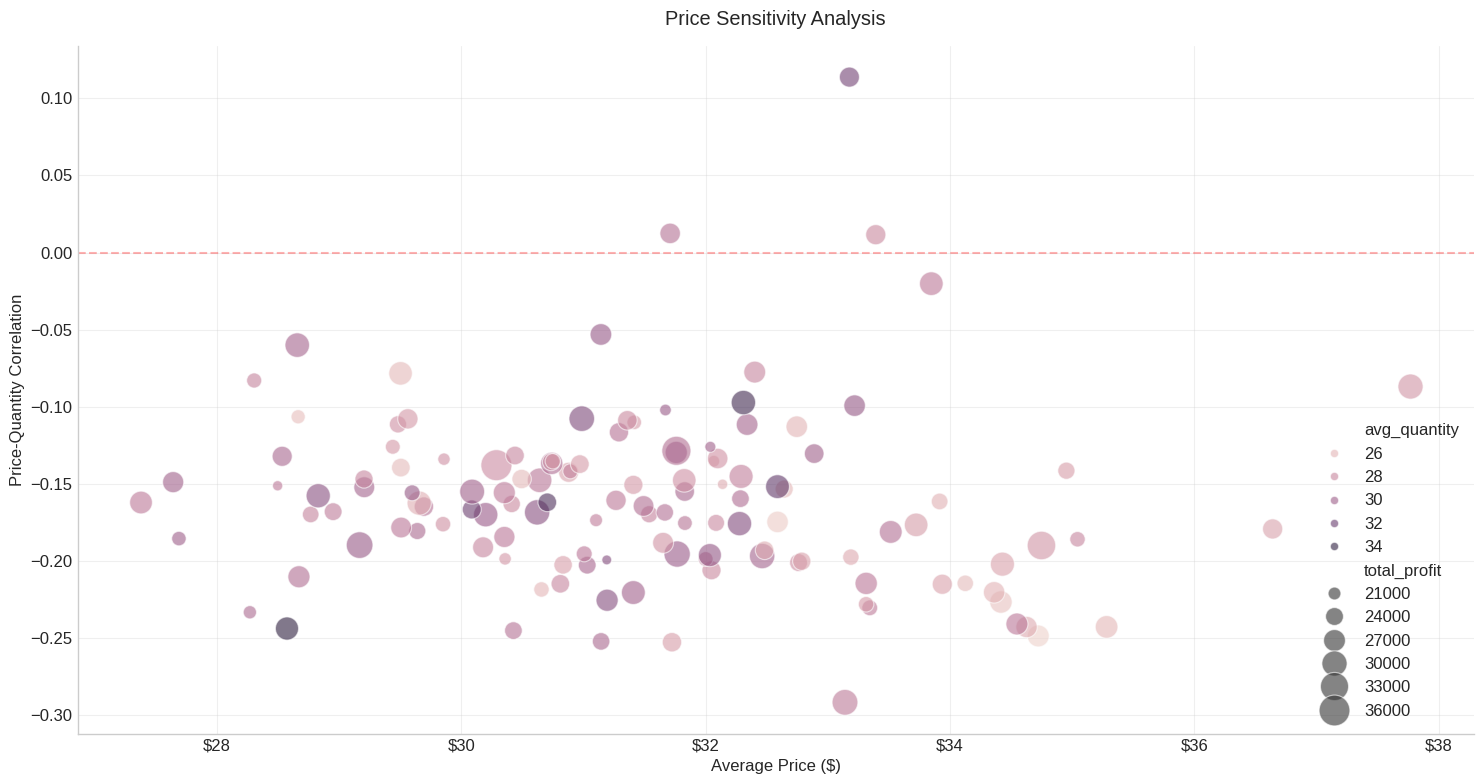

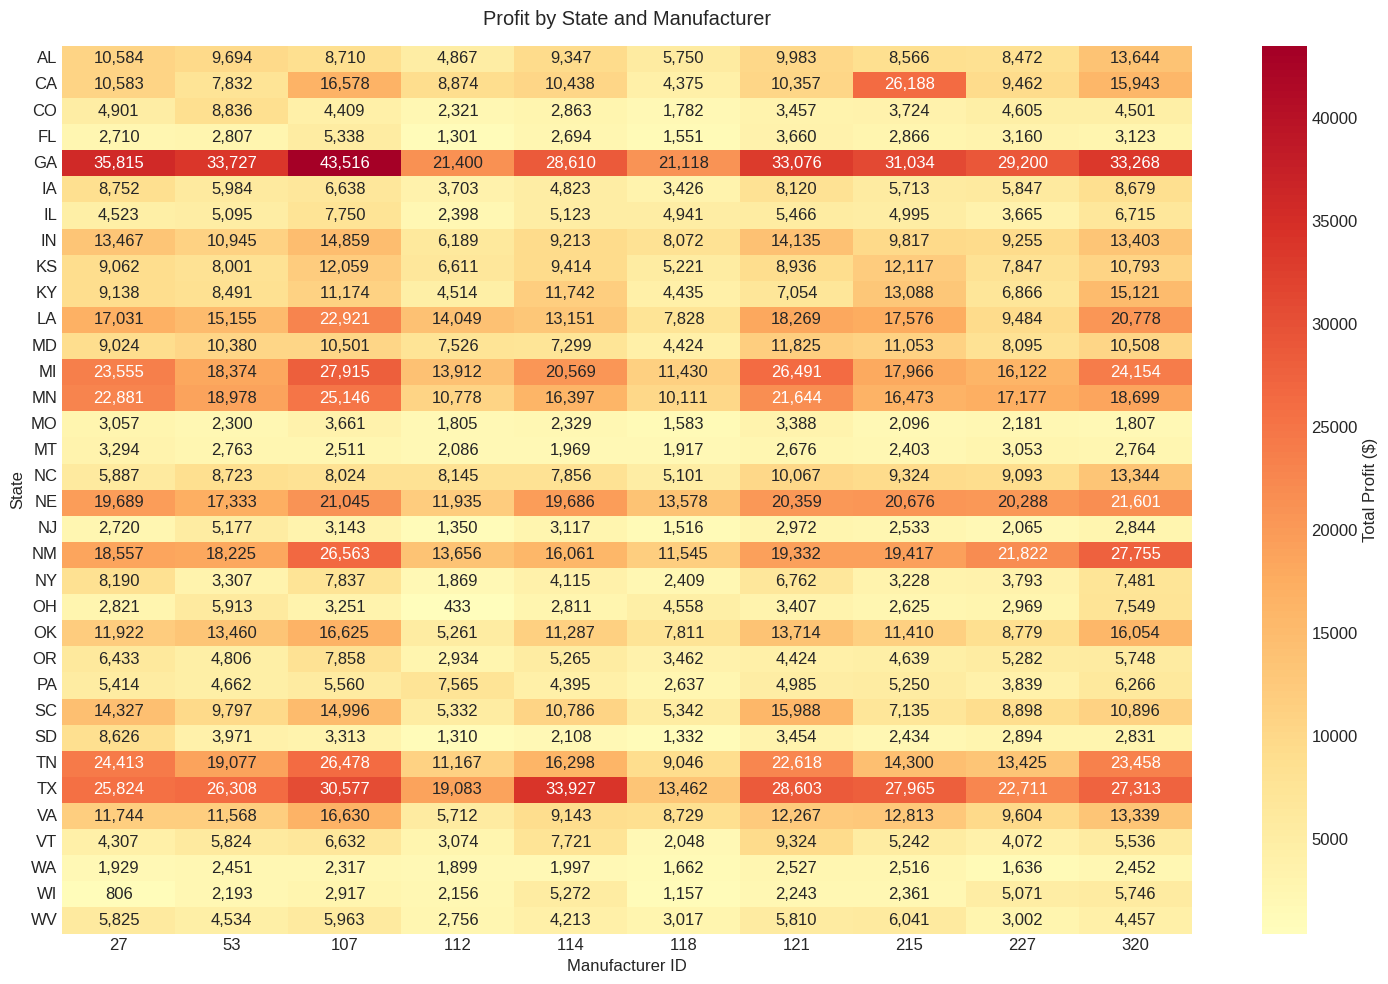

<Figure size 1500x800 with 0 Axes>

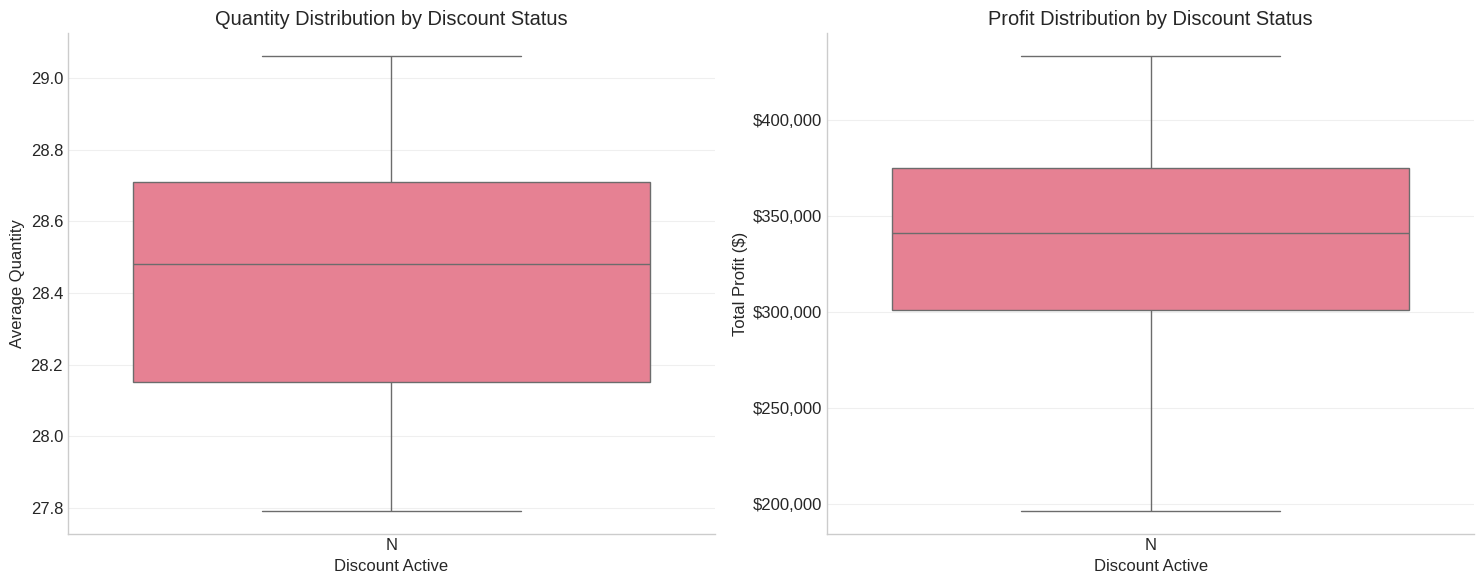

In [21]:
df_with_temporal = add_temporal_features(cleaned_df)
analysis_results = analyze_product_manufacturer_performance(df_with_temporal)
visualize_product_manufacturer_analysis(analysis_results)

Comment:
This above two chunks of code visualize the performance of product-manufacturer combinations using a combination of temporal, pricing, and state-level metrics. It integrates temporal and holiday features. The holiday periods, such as Christmas, Thanksgiving, and July 4th, are identified and used to calculate metrics like total quantity sold, average price, and profit during these times. Price sensitivity analysis evaluates how changes in price affect demand by calculating correlations between sales price and quantity.

The state performance analysis provides insights into how profit and sales are distributed across states and manufacturers, helping identify regional strengths and weaknesses. Discount analysis evaluates the impact of active promotions on average quantity sold and total profit, providing insights into the effectiveness of discounts. Moving averages for price and quantity over different time windows (7-day, 30-day, and 60-day) are calculated to analyze trends and smooth out fluctuations in sales data.

The visualizations include bar plots for profit and quantity by holiday period, scatter plots to show price sensitivity and its correlation with profit and quantity, heatmaps for state-level performance across manufacturers, and box plots to examine the impact of discounts.


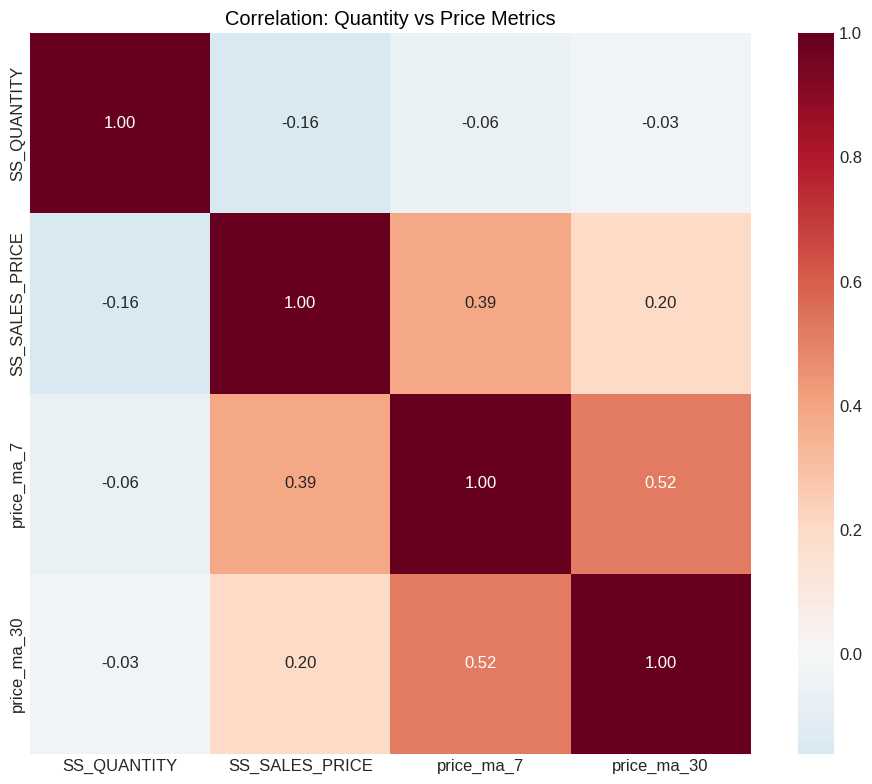


Key Price Correlations with Quantity:
SS_QUANTITY       1.000000
price_ma_30      -0.033846
price_ma_7       -0.064977
SS_SALES_PRICE   -0.161370
Name: SS_QUANTITY, dtype: float64


In [22]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, lag, col, when
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True

def create_price_correlations(df):
    """Correlation analysis for quantity and price metrics"""
    # Create window specs for moving averages
    window_7 = Window.orderBy('DATE_COLUMN').rowsBetween(-6, 0)
    window_30 = Window.orderBy('DATE_COLUMN').rowsBetween(-29, 0)

    # Calculate moving averages
    price_df = df.select(
        'SS_QUANTITY',
        'SS_SALES_PRICE',
        col('DATE_COLUMN')
    ).withColumn(
        'price_ma_7',
        avg('SS_SALES_PRICE').over(window_7)
    ).withColumn(
        'price_ma_30',
        avg('SS_SALES_PRICE').over(window_30)
    )

    # Convert to pandas
    price_corr_df = price_df.select(
        'SS_QUANTITY',
        'SS_SALES_PRICE',
        'price_ma_7',
        'price_ma_30'
    ).toPandas()

    # Calculate correlation matrix
    corr_matrix = price_corr_df.corr()

    # Plot with transparent background
    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_alpha(0)
    ax = plt.gca()
    ax.patch.set_alpha(0)

    sns.heatmap(corr_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8})

    plt.title('Correlation: Quantity vs Price Metrics', color='black')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def create_promo_correlations(df):
    """Correlation analysis for quantity and promotions"""
    # Convert promotion channels to numeric
    promo_df = df.select(
        'SS_QUANTITY',
        'SS_COUPON_AMT',
    )

    # Convert to pandas
    promo_corr_df = promo_df.toPandas()

    # Calculate correlation matrix
    corr_matrix = promo_corr_df.corr()

    # Plot with transparent background
    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_alpha(0)
    ax = plt.gca()
    ax.patch.set_alpha(0)

    sns.heatmap(corr_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8})

    plt.title('Correlation: Quantity vs Discount', color='black')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def create_comprehensive_correlations(df):
    """Comprehensive correlation analysis"""
    window_7 = Window.orderBy('DATE_COLUMN').rowsBetween(-6, 0)
    window_30 = Window.orderBy('DATE_COLUMN').rowsBetween(-29, 0)

    # Select and prepare all relevant columns
    comp_df = df.select(
        'SS_QUANTITY',
        'SS_SALES_PRICE',
        'CD_GENDER',
        'CD_MARITAL_STATUS',
        'CD_EDUCATION_STATUS',
        #'HD_INCOME_BAND',
        #'HD_BUY_POTENTIAL',
        col('DATE_COLUMN')
    ).withColumn(
        'price_ma_7',
        avg('SS_SALES_PRICE').over(window_7)
    ).withColumn(
        'price_ma_30',
        avg('SS_SALES_PRICE').over(window_30)
    )

    # Convert to pandas
    comp_corr_df = comp_df.select(
        'SS_QUANTITY',
        'SS_SALES_PRICE',
        'price_ma_7',
        'price_ma_30',
       'CD_GENDER',
        'CD_MARITAL_STATUS',
        'CD_EDUCATION_STATUS',
        #'HD_INCOME_BAND',
        #'HD_BUY_POTENTIAL'
    ).toPandas()

    # Calculate correlation matrix
    corr_matrix = comp_corr_df.corr()

    # Plot with transparent background
    fig = plt.figure(figsize=(15, 12))
    fig.patch.set_alpha(0)
    ax = plt.gca()
    ax.patch.set_alpha(0)

    mask = np.triu(np.ones_like(corr_matrix))

    sns.heatmap(corr_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                mask=mask,
                cbar_kws={'alpha': 0.8})

    plt.title('Comprehensive Correlation Analysis', color='black')
    ax.set_facecolor('none')
    plt.xticks(rotation=45, color='black')
    plt.yticks(rotation=0, color='black')
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Run all correlation analyses
price_correlations = create_price_correlations(cleaned_df)
#promo_correlations = create_promo_correlations(cleaned_df)
#comprehensive_correlations = create_comprehensive_correlations(cleaned_df)

print("\nKey Price Correlations with Quantity:")
print(price_correlations['SS_QUANTITY'].sort_values(ascending=False))

#print("\nKey Promotion Correlations with Quantity:")
#print(promo_correlations['SS_QUANTITY'].sort_values(ascending=False))

#print("\nTop 5 Correlations with Quantity from Comprehensive Analysis:")
#print(comprehensive_correlations['SS_QUANTITY'].sort_values(ascending=False).head())

Comment: The above line generates a correlation matrix between quantity, and temporal features of sales price to look for patterns between demand and time based price.

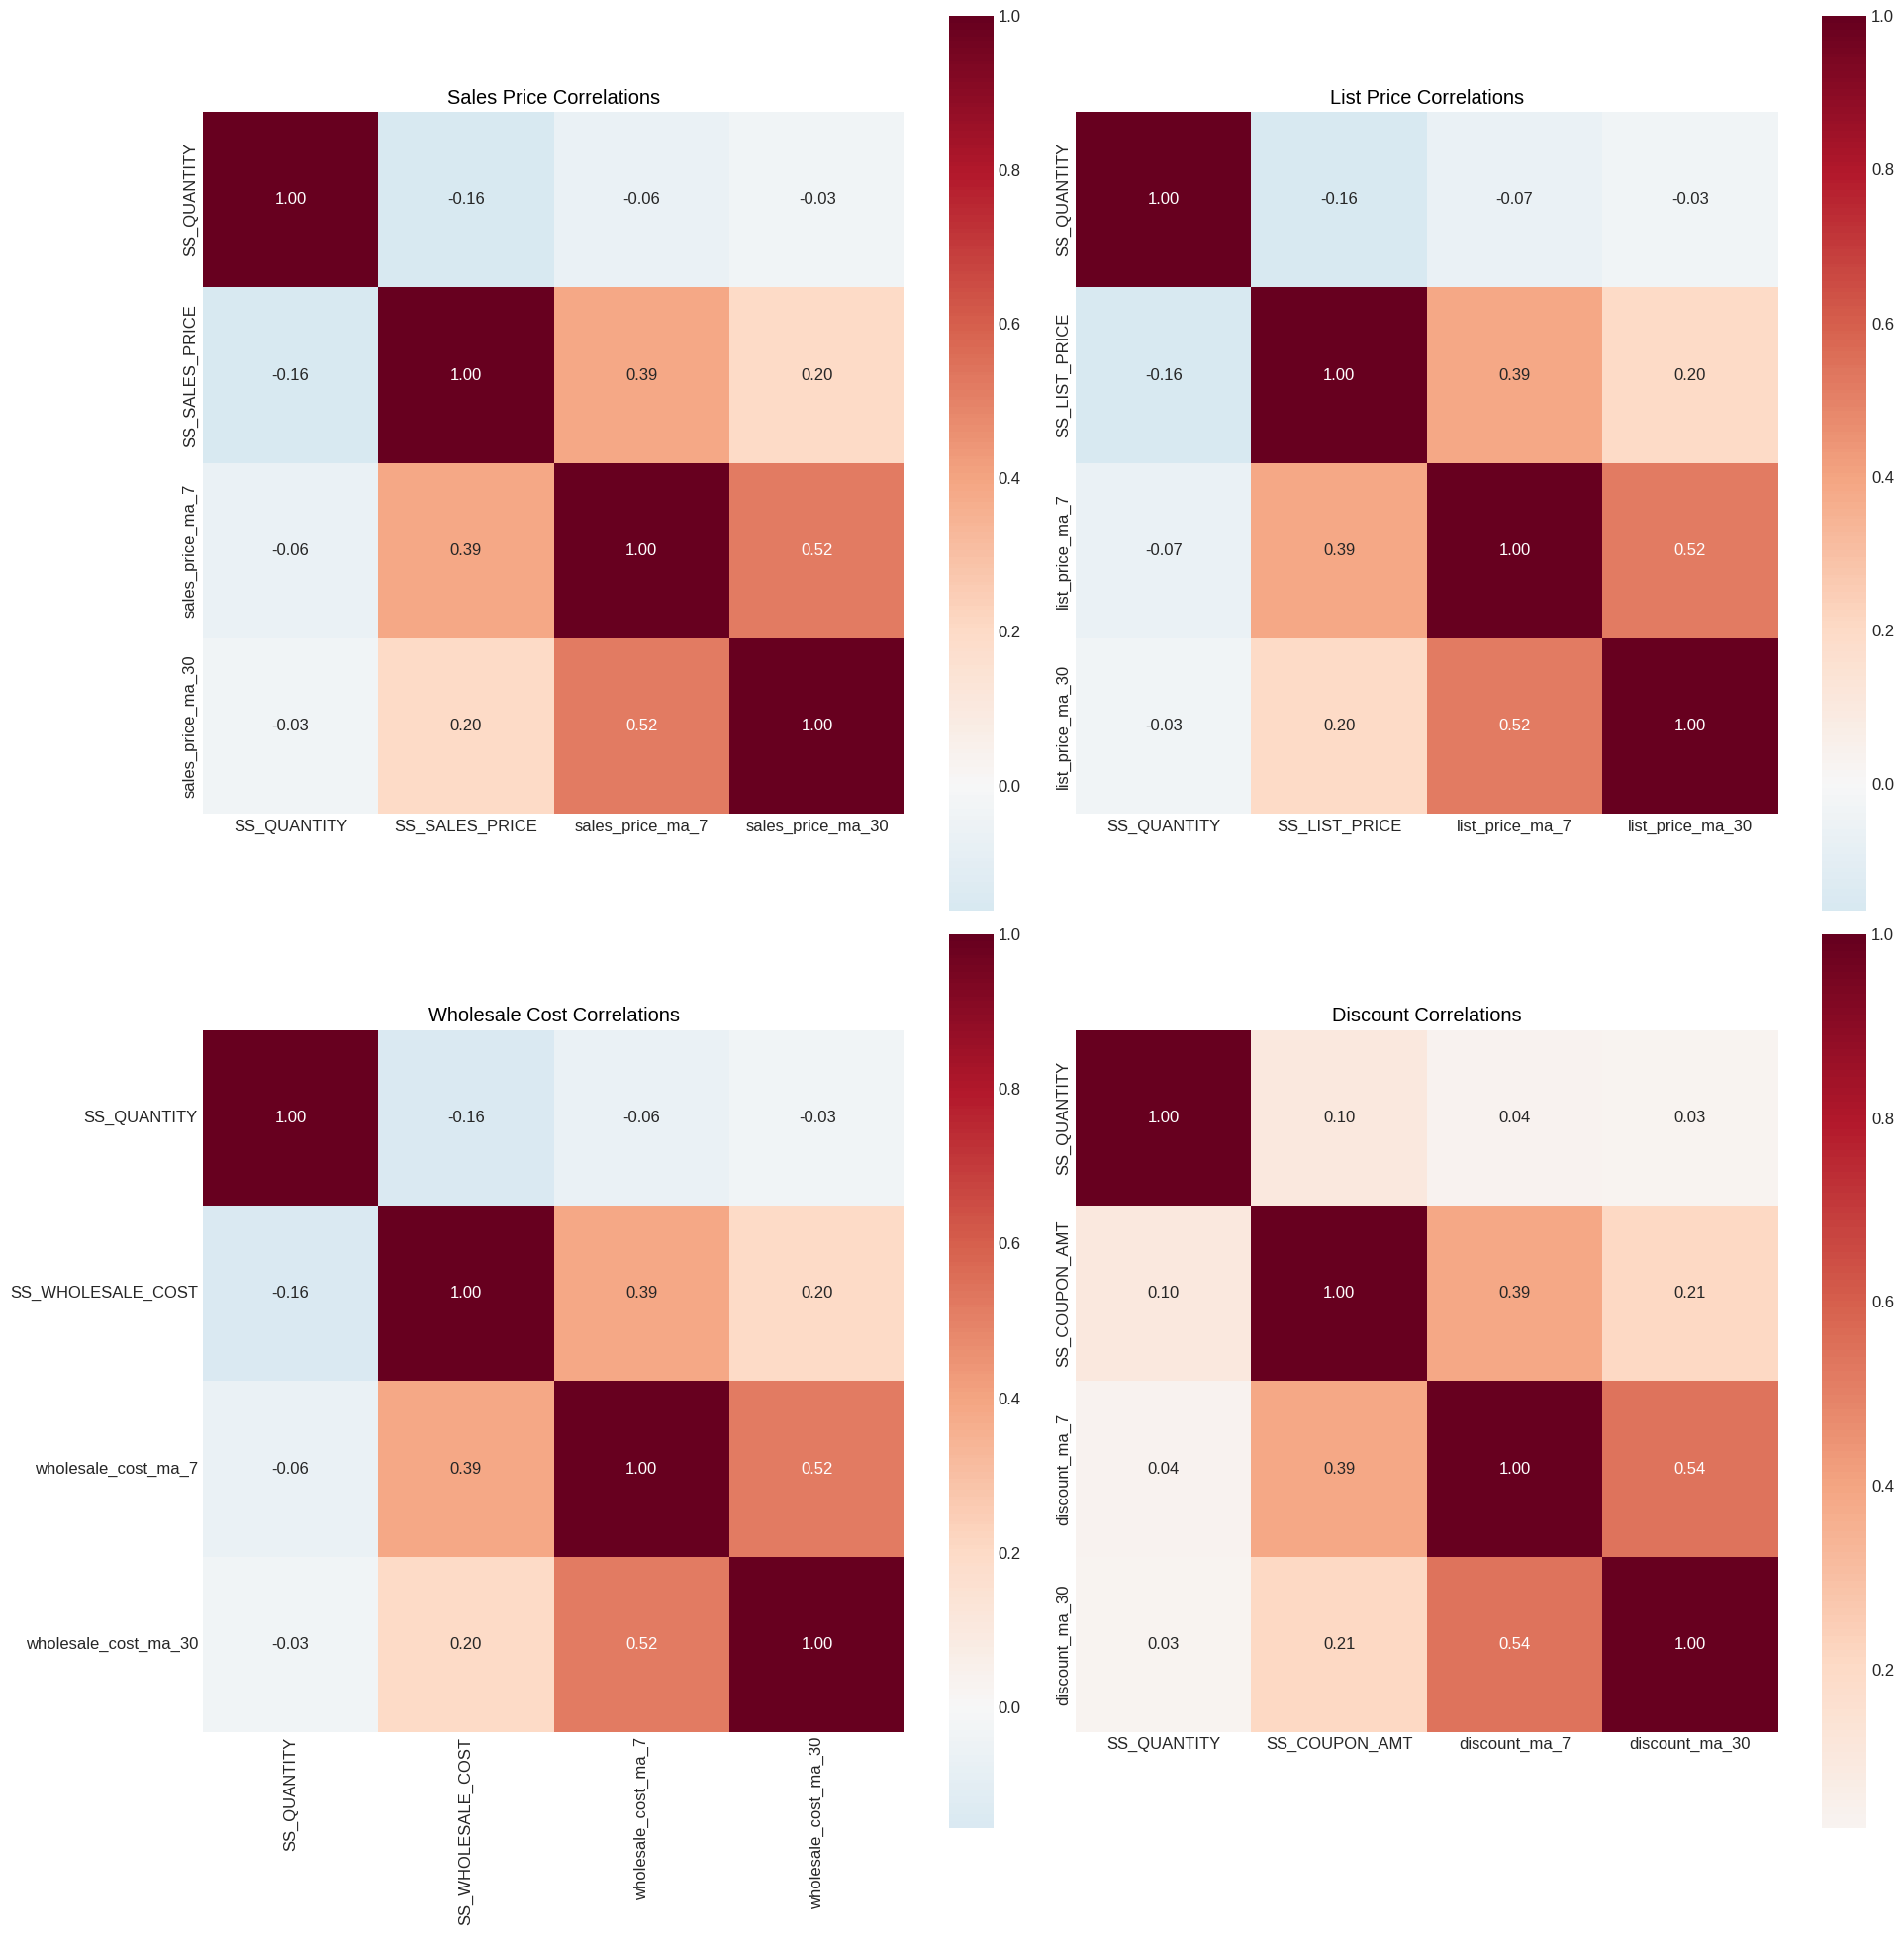

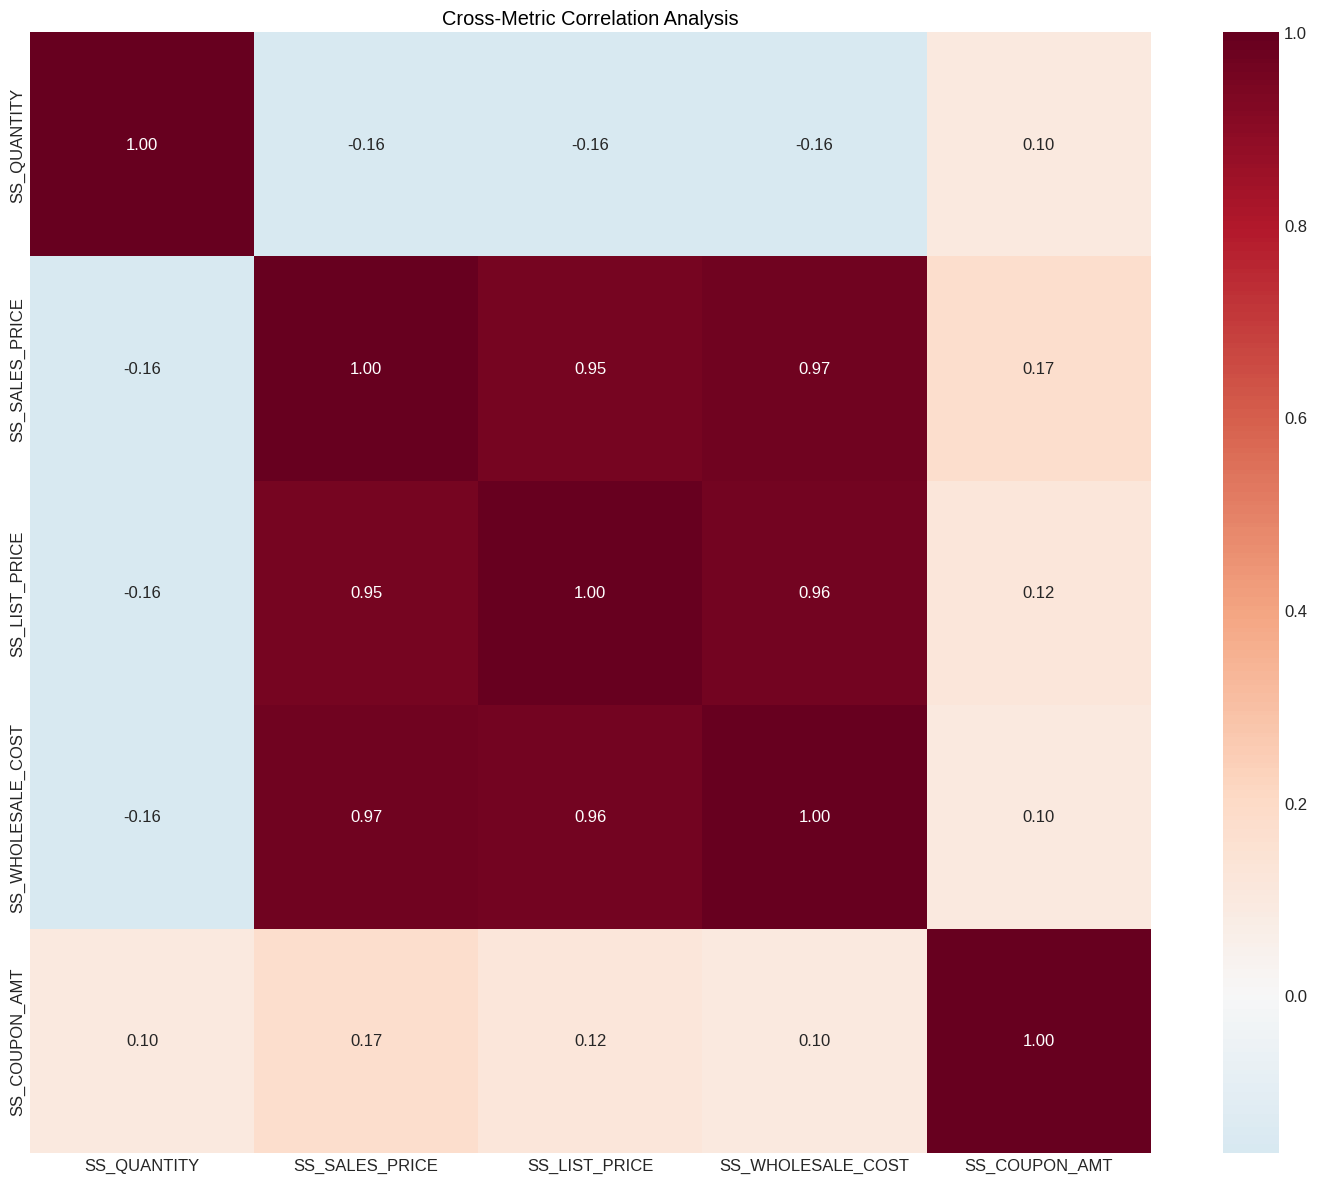


Key Correlations with Quantity:
SS_COUPON_AMT           0.104228
discount_ma_7           0.042186
discount_ma_30          0.027599
wholesale_cost_ma_30   -0.033404
list_price_ma_30       -0.033483
sales_price_ma_30      -0.033846
wholesale_cost_ma_7    -0.062383
sales_price_ma_7       -0.064977
list_price_ma_7        -0.065858
SS_WHOLESALE_COST      -0.156047
Name: SS_QUANTITY, dtype: float64


In [23]:
def create_extended_price_correlations(df):
    """Extended correlation analysis for all price metrics and their moving averages"""

    # Create window specs for moving averages
    window_7 = Window.partitionBy().orderBy('DATE_COLUMN').rowsBetween(-6, 0)
    window_30 = Window.partitionBy().orderBy('DATE_COLUMN').rowsBetween(-29, 0)

    # Calculate moving averages for all price metrics
    price_df = df.select(
        'SS_QUANTITY',
        'SS_SALES_PRICE',
        'SS_LIST_PRICE',
        'SS_WHOLESALE_COST',
        'SS_COUPON_AMT',
        'DATE_COLUMN'
    ).withColumns({
        # Sales Price moving averages
        'sales_price_ma_7': avg('SS_SALES_PRICE').over(window_7),
        'sales_price_ma_30': avg('SS_SALES_PRICE').over(window_30),

        # List Price moving averages
        'list_price_ma_7': avg('SS_LIST_PRICE').over(window_7),
        'list_price_ma_30': avg('SS_LIST_PRICE').over(window_30),

        # Wholesale Cost moving averages
        'wholesale_cost_ma_7': avg('SS_WHOLESALE_COST').over(window_7),
        'wholesale_cost_ma_30': avg('SS_WHOLESALE_COST').over(window_30),

        # Discount moving averages
        'discount_ma_7': avg('SS_COUPON_AMT').over(window_7),
        'discount_ma_30': avg('SS_COUPON_AMT').over(window_30)
    })

    # Convert to pandas, dropping the date column before correlation
    price_corr_df = price_df.drop('DATE_COLUMN').toPandas()

    # Calculate correlation matrix
    corr_matrix = price_corr_df.corr()

    # Create multiple correlation heatmaps for better readability
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.patch.set_alpha(0)

    # Sales Price subplot
    sales_cols = ['SS_QUANTITY', 'SS_SALES_PRICE', 'sales_price_ma_7', 'sales_price_ma_30']
    sales_corr = corr_matrix.loc[sales_cols, sales_cols]

    ax = axes[0,0]
    ax.patch.set_alpha(0)
    sns.heatmap(sales_corr,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8},
                ax=ax)
    ax.set_title('Sales Price Correlations', color='black')

    # List Price subplot
    list_cols = ['SS_QUANTITY', 'SS_LIST_PRICE', 'list_price_ma_7', 'list_price_ma_30']
    list_corr = corr_matrix.loc[list_cols, list_cols]

    ax = axes[0,1]
    ax.patch.set_alpha(0)
    sns.heatmap(list_corr,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8},
                ax=ax)
    ax.set_title('List Price Correlations', color='black')

    # Wholesale Cost subplot
    wholesale_cols = ['SS_QUANTITY', 'SS_WHOLESALE_COST', 'wholesale_cost_ma_7', 'wholesale_cost_ma_30']
    wholesale_corr = corr_matrix.loc[wholesale_cols, wholesale_cols]

    ax = axes[1,0]
    ax.patch.set_alpha(0)
    sns.heatmap(wholesale_corr,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8},
                ax=ax)
    ax.set_title('Wholesale Cost Correlations', color='black')

    # Discount subplot
    discount_cols = ['SS_QUANTITY', 'SS_COUPON_AMT', 'discount_ma_7', 'discount_ma_30']  # Changed from SS_EXT_DISCOUNT_AMT
    discount_corr = corr_matrix.loc[discount_cols, discount_cols]

    ax = axes[1,1]
    ax.patch.set_alpha(0)
    sns.heatmap(discount_corr,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8},
                ax=ax)
    ax.set_title('Discount Correlations', color='black')

    plt.tight_layout()
    plt.show()

    # Create a second visualization for cross-metric correlations
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    ax.patch.set_alpha(0)

    # Select main metrics for cross-correlation
    cross_cols = ['SS_QUANTITY', 'SS_SALES_PRICE', 'SS_LIST_PRICE',
                 'SS_WHOLESALE_COST', 'SS_COUPON_AMT']  # Changed from SS_EXT_DISCOUNT_AMT
    cross_corr = corr_matrix.loc[cross_cols, cross_cols]

    sns.heatmap(cross_corr,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'alpha': 0.8})

    plt.title('Cross-Metric Correlation Analysis', color='black')
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Run analysis
extended_correlations = create_extended_price_correlations(cleaned_df)

# Print key insights
print("\nKey Correlations with Quantity:")
quantity_corrs = extended_correlations['SS_QUANTITY'].sort_values(ascending=False)
print(quantity_corrs[quantity_corrs != 1.0].head(10))


Comment: The above chunk of code looks for correlations between moving averages of pricing metrics and quantity to check more in depth from the above chunk when it comes to relationship between demand and pricing


Sample of temporal features:
+-----------+-----------+-----+----+----------+
|DATE_COLUMN|day_of_week|month|year|is_weekend|
+-----------+-----------+-----+----+----------+
| 2002-12-24|          3|   12|2002|         0|
| 2002-06-16|          1|    6|2002|         1|
| 2002-04-05|          6|    4|2002|         0|
| 2002-08-07|          4|    8|2002|         0|
| 2002-12-20|          6|   12|2002|         0|
+-----------+-----------+-----+----+----------+
only showing top 5 rows


Shape of day of week pandas DataFrame: (7, 4)

Day of week data:
   day_of_week  avg_quantity  std_quantity  transaction_count
0            1     28.580005     27.309853              24036
1            2     27.453888     26.787925              23096
2            3     28.461787     27.250172              24180
3            4     28.802139     27.867291              25240
4            5     28.494533     27.421830              23232
5            6     28.652355     27.683336              22825
6            

<ipython-input-24-98c968985619>:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


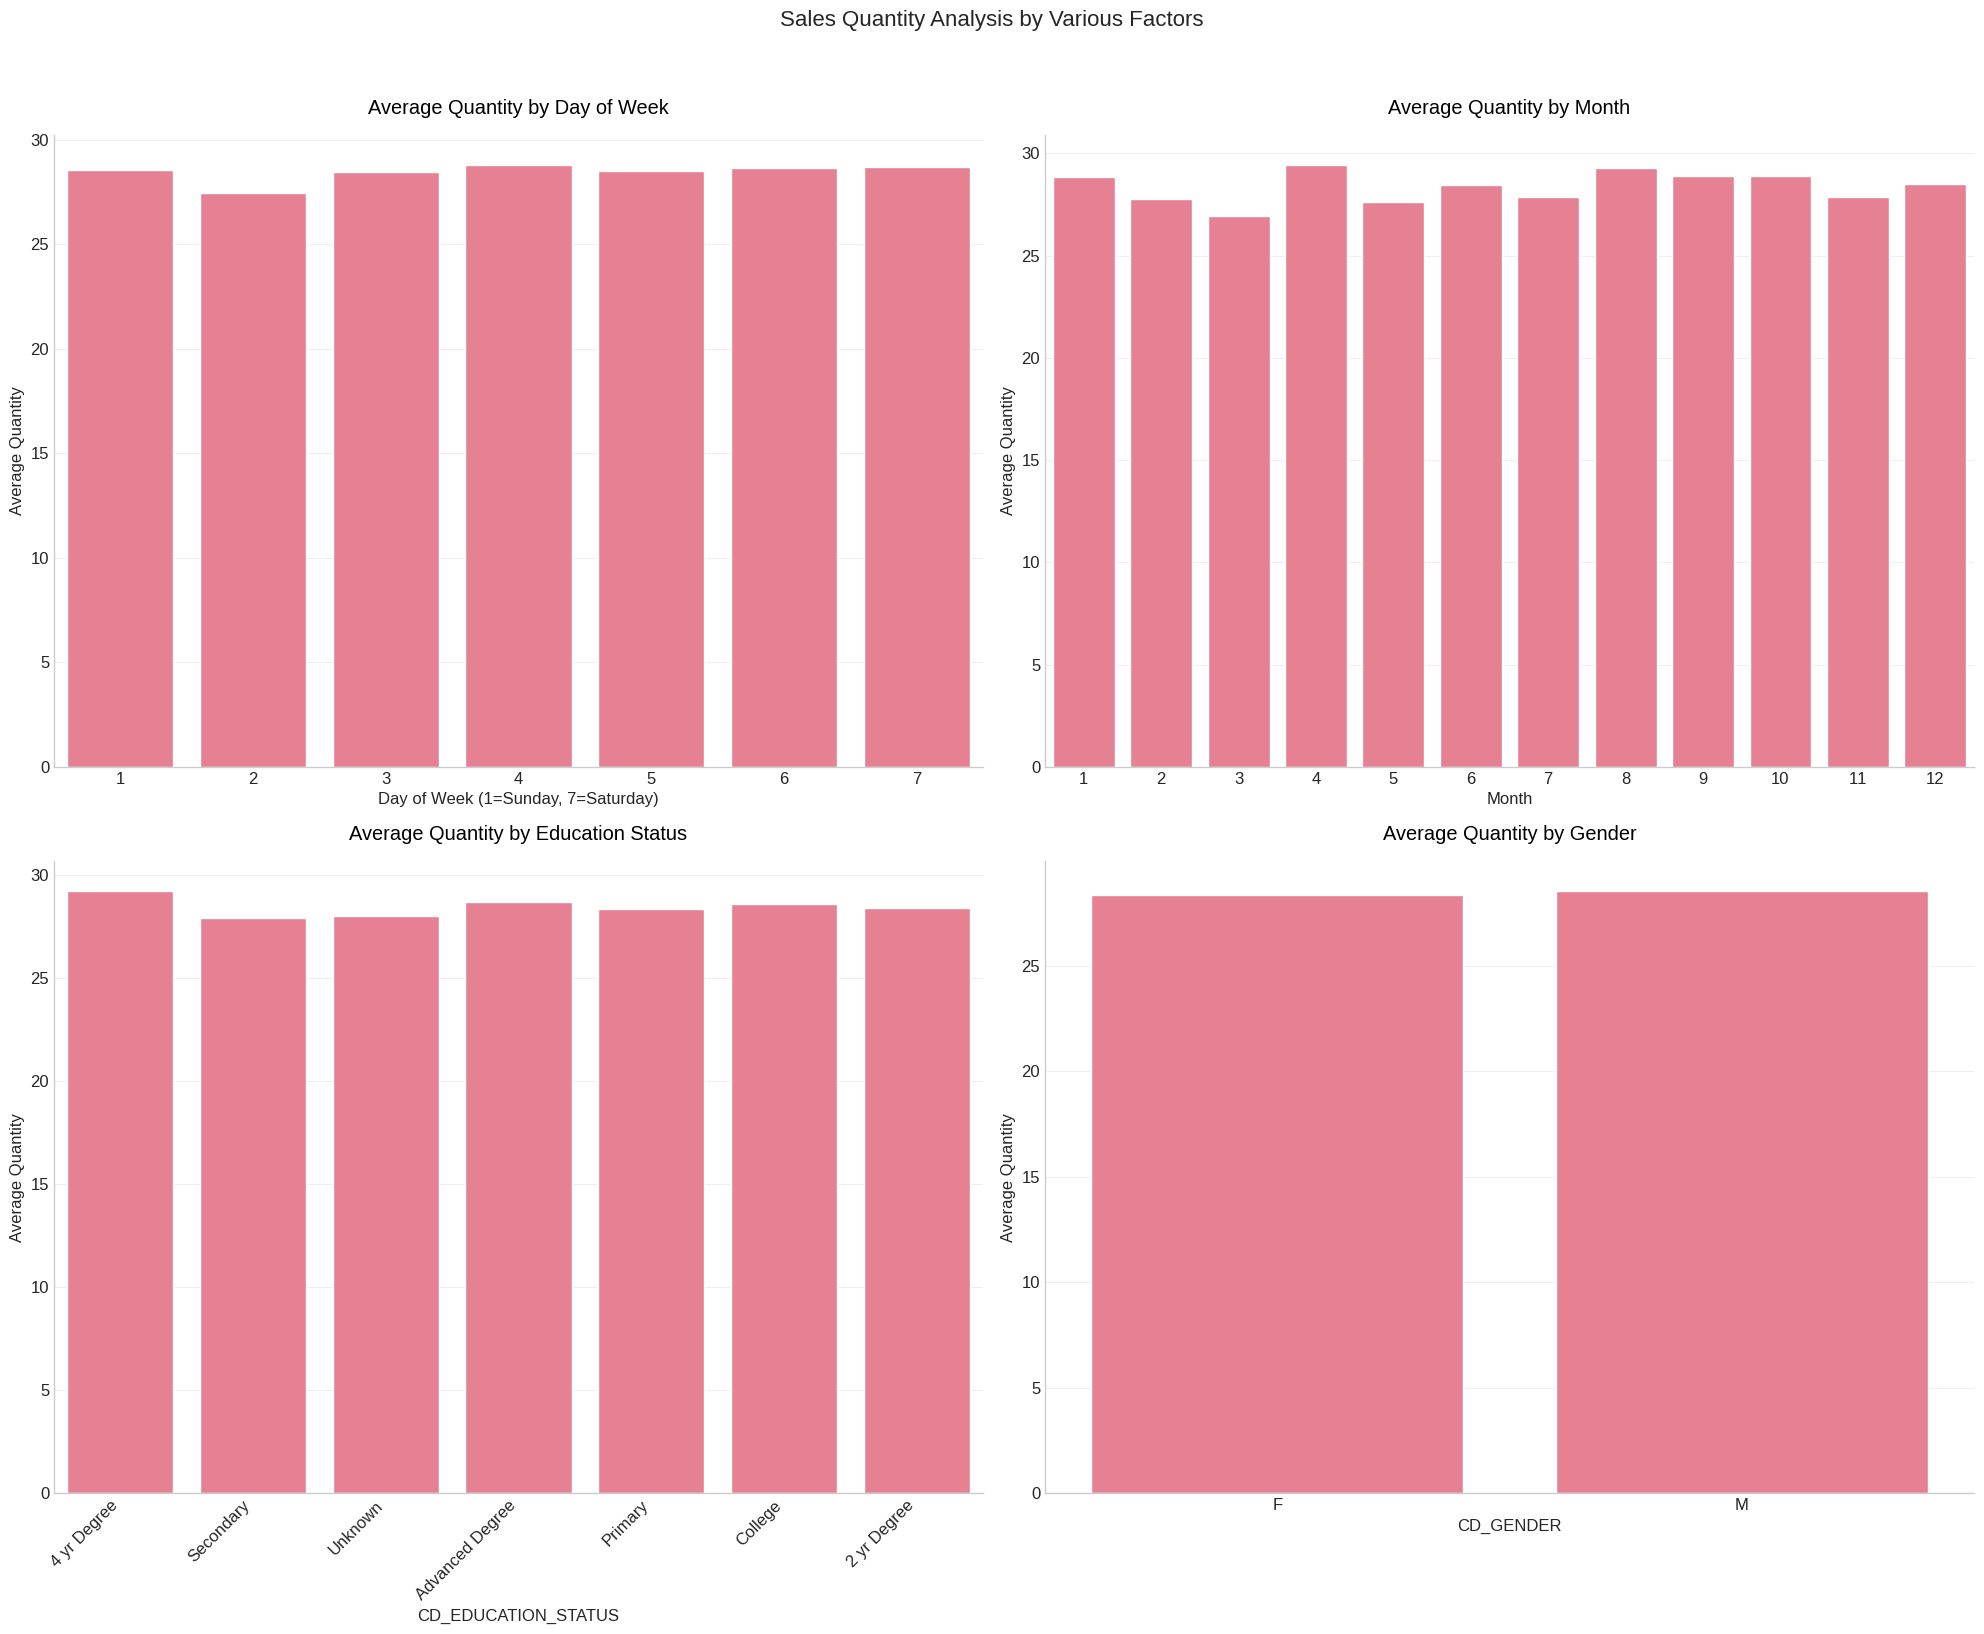

<ipython-input-24-98c968985619>:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


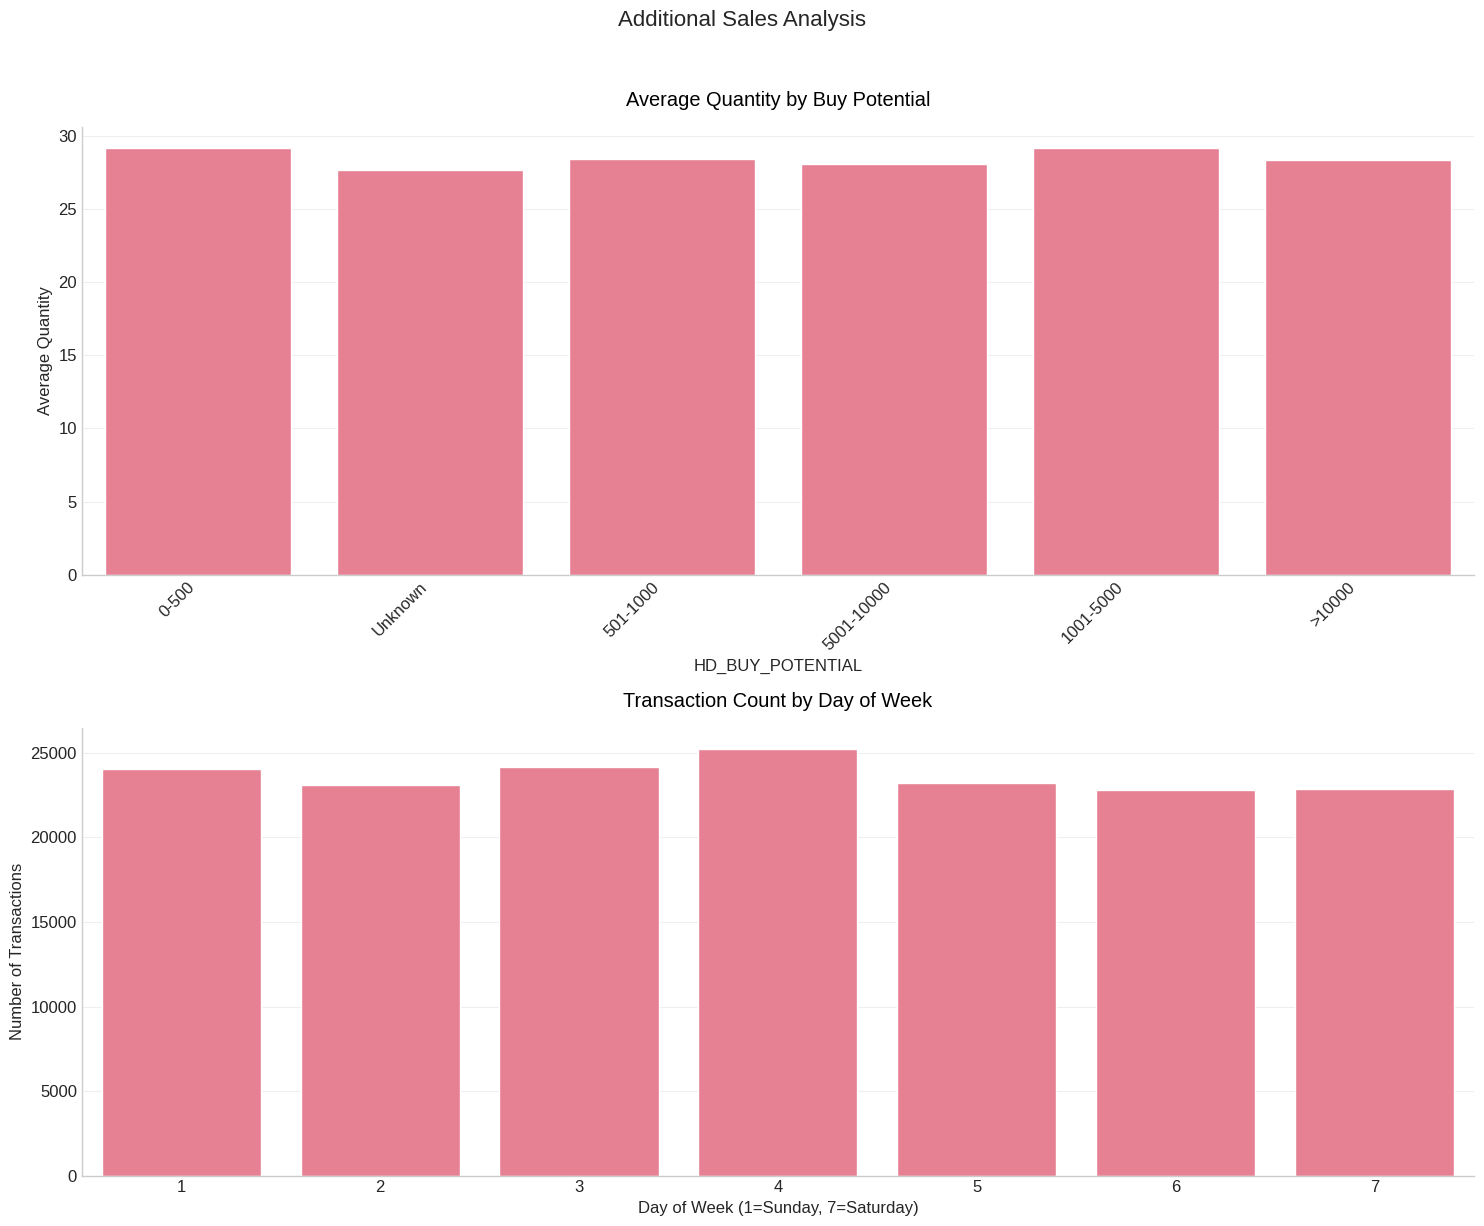


Variation Analysis:
--------------------------------------------------
Day of Week     variation ratio: 0.05
Month           variation ratio: 0.09
Education       variation ratio: 0.05
Credit Rating   variation ratio: 0.01
Buy Potential   variation ratio: 0.05


In [24]:
from pyspark.sql.functions import (dayofweek, month, year, when, avg, count,
                                 sum, stddev, col, to_date, date_format, expr)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_categorical_relationships(df):
    """
    Analyze relationship between quantity and categorical variables
    """

    # 1. Add temporal features directly using DATE_COLUMN
    df_temporal = df.withColumns({
        'day_of_week': dayofweek('DATE_COLUMN'),  # 1=Sunday, 7=Saturday
        'month': month('DATE_COLUMN'),
        'year': year('DATE_COLUMN'),
        'is_weekend': when(dayofweek('DATE_COLUMN').isin([1, 7]), 1).otherwise(0)
    })

    # Verify temporal features
    print("\nSample of temporal features:")
    df_temporal.select('DATE_COLUMN', 'day_of_week', 'month', 'year', 'is_weekend').show(5)

    # Cache the DataFrame
    df_temporal.cache()

    # 2. Temporal Analysis
    # Average quantity by day of week
    dow_analysis = df_temporal.groupBy('day_of_week').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count')
    ).orderBy('day_of_week')

    # Monthly patterns
    month_analysis = df_temporal.groupBy('month').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count')
    ).orderBy('month')

    # 3. Demographic Analysis
    # Education Status
    edu_analysis = df.groupBy('CD_EDUCATION_STATUS').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count')
    )

    # Credit Rating
    credit_analysis = df.groupBy('CD_GENDER').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count')
    )

    # Buy Potential
    potential_analysis = df.groupBy('HD_BUY_POTENTIAL').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count')
    )

    # Convert to pandas for visualization
    dow_pd = dow_analysis.toPandas()
    month_pd = month_analysis.toPandas()
    edu_pd = edu_analysis.toPandas()
    credit_pd = credit_analysis.toPandas()
    potential_pd = potential_analysis.toPandas()

    # Print shape of dow_pd to verify data
    print(f"\nShape of day of week pandas DataFrame: {dow_pd.shape}")
    print("\nDay of week data:")
    print(dow_pd)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Sales Quantity Analysis by Various Factors', fontsize=16, y=1.02)
    fig.patch.set_alpha(0)

    # Day of Week Plot
    ax = axes[0,0]
    ax.patch.set_alpha(0)
    sns.barplot(data=dow_pd, x='day_of_week', y='avg_quantity', ax=ax)
    ax.set_title('Average Quantity by Day of Week', color='black', pad=15)
    ax.set_xlabel('Day of Week (1=Sunday, 7=Saturday)')
    ax.set_ylabel('Average Quantity')

    # Month Plot
    ax = axes[0,1]
    ax.patch.set_alpha(0)
    sns.barplot(data=month_pd, x='month', y='avg_quantity', ax=ax)
    ax.set_title('Average Quantity by Month', color='black', pad=15)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Quantity')

    # Education Status Plot
    ax = axes[1,0]
    ax.patch.set_alpha(0)
    sns.barplot(data=edu_pd, x='CD_EDUCATION_STATUS', y='avg_quantity', ax=ax)
    ax.set_title('Average Quantity by Education Status', color='black', pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Quantity')

    # Credit Rating Plot
    ax = axes[1,1]
    ax.patch.set_alpha(0)
    sns.barplot(data=credit_pd, x='CD_GENDER', y='avg_quantity', ax=ax)
    ax.set_title('Average Quantity by Gender', color='black', pad=15)
    ax.set_ylabel('Average Quantity')

    plt.tight_layout()
    plt.show()

    # Additional plots
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    fig.suptitle('Additional Sales Analysis', fontsize=16, y=1.02)
    fig.patch.set_alpha(0)

    # Buy Potential Plot
    ax = axes[0]
    ax.patch.set_alpha(0)
    sns.barplot(data=potential_pd, x='HD_BUY_POTENTIAL', y='avg_quantity', ax=ax)
    ax.set_title('Average Quantity by Buy Potential', color='black', pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Quantity')

    # Transaction Count Distribution
    ax = axes[1]
    ax.patch.set_alpha(0)
    sns.barplot(data=dow_pd, x='day_of_week', y='transaction_count', ax=ax)
    ax.set_title('Transaction Count by Day of Week', color='black', pad=15)
    ax.set_xlabel('Day of Week (1=Sunday, 7=Saturday)')
    ax.set_ylabel('Number of Transactions')

    plt.tight_layout()
    plt.show()

    print("\nVariation Analysis:")
    print("-" * 50)
    for df_name, df_pd in [("Day of Week", dow_pd),
                          ("Month", month_pd),
                          ("Education", edu_pd),
                          ("Credit Rating", credit_pd),
                          ("Buy Potential", potential_pd)]:
        variation = (df_pd['avg_quantity'].max() - df_pd['avg_quantity'].min()) / df_pd['avg_quantity'].mean()
        print(f"{df_name:15} variation ratio: {variation:.2f}")

    df_temporal.unpersist()

    return {
        'dow_analysis': dow_pd,
        'month_analysis': month_pd,
        'edu_analysis': edu_pd,
        'credit_analysis': credit_pd,
        'potential_analysis': potential_pd
    }

categorical_results = analyze_categorical_relationships(cleaned_df)


Comment: We analyze how sales quantities vary across different days and months. It calculates the average sales quantity, standard deviation, and transaction count for each day of the week and each month to understand temporal trend. Demographic analysis explores how education status, gender, and buying potential influence sales quantities. By grouping the data based on these variables, the script calculates metrics such as average quantity, standard deviation, and transaction count. These insights help identify customer segments with distinct purchasing behaviors.We calculate variation ratios for each categorical variable to quantify how much the average quantity varies across categories.



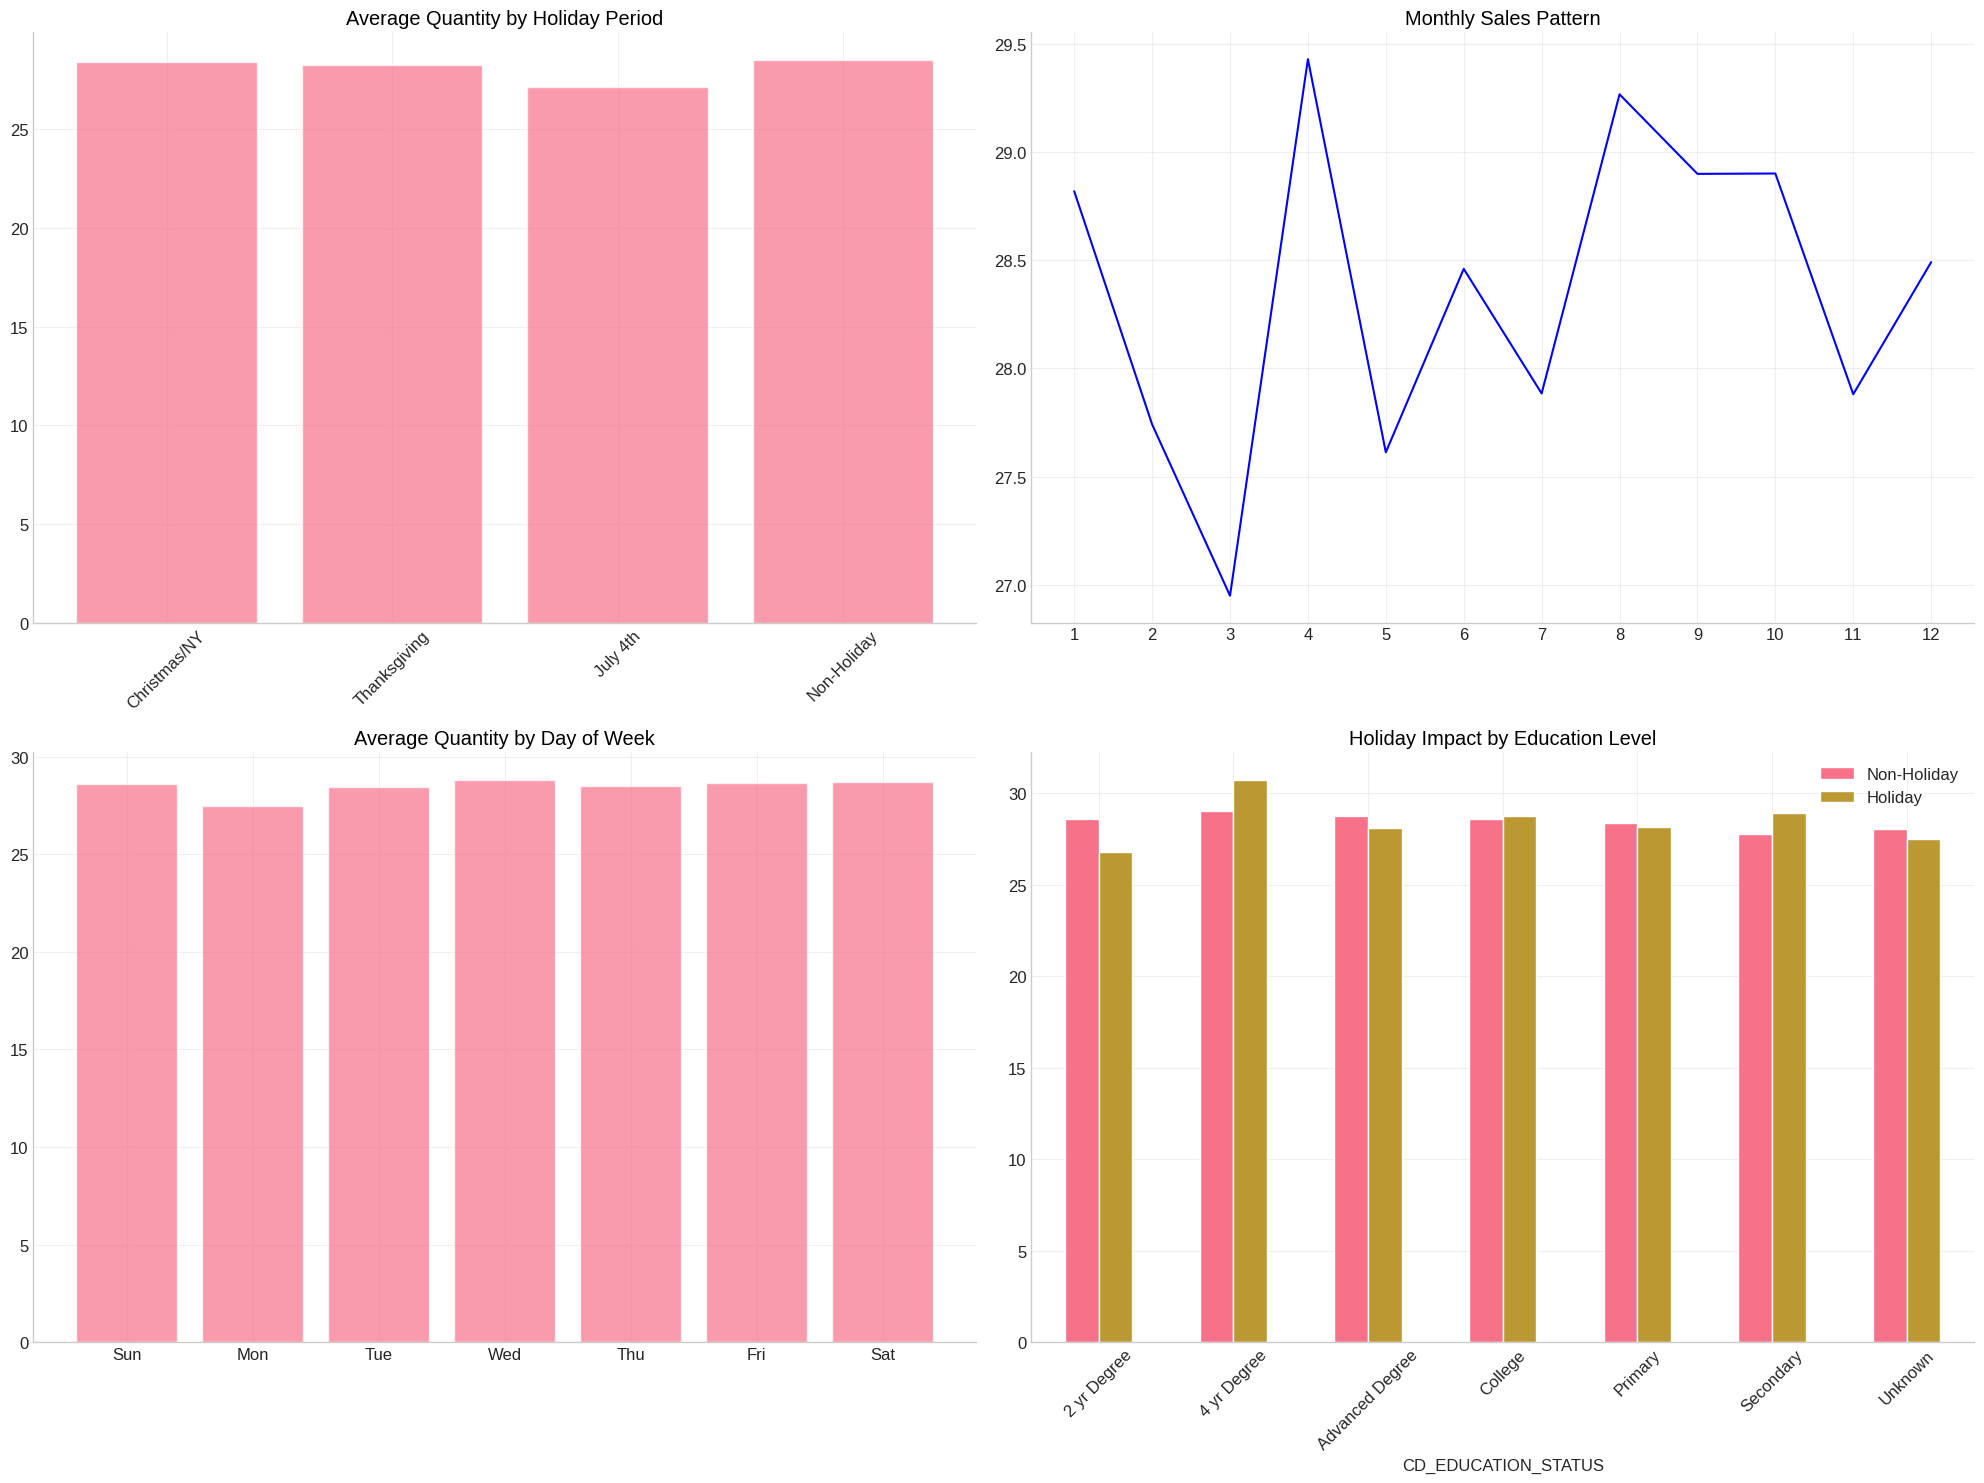


Holiday Impact Analysis:
Christmas/NY: -0.2% change in average quantity
Thanksgiving: -0.7% change in average quantity
July 4th: -4.6% change in average quantity


In [25]:
from pyspark.sql.functions import (dayofweek, month, year, when, avg, count,
                                 sum, stddev, col, to_date, dayofmonth)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_seasonal_and_categorical_relationships(df):
    """Analyze relationship between quantity and categorical/seasonal variables"""

    df_with_date = df.withColumn(
        'date',
        to_date(col('DATE_COLUMN'))
    )

    # Add temporal and holiday features
    df_temporal = df_with_date.withColumns({
        'day_of_week': dayofweek('date'),
        'month': month('date'),
        'year': year('date'),
        'day': dayofmonth('date'),
        'is_weekend': when(dayofweek('date').isin([1, 7]), 1).otherwise(0),
        'is_christmas_ny': when(
            ((month('date') == 12) & (dayofmonth('date') >= 15)) |
            ((month('date') == 1) & (dayofmonth('date') <= 1)),
            1
        ).otherwise(0),
        'is_thanksgiving': when(
            ((month('date') == 11) & (dayofmonth('date') >= 15)) |
            ((month('date') == 12) & (dayofmonth('date') <= 5)),
            1
        ).otherwise(0),
        'is_july4': when(
            (month('date') == 7) &
            (dayofmonth('date').between(1, 4)),
            1
        ).otherwise(0)
    })

    # Basic holiday metrics
    holiday_analysis = df_temporal.groupBy(
        'is_christmas_ny',
        'is_thanksgiving',
        'is_july4'
    ).agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        stddev('SS_QUANTITY').alias('std_quantity'),
        count('*').alias('transaction_count'),
        avg('SS_SALES_PRICE').alias('avg_price')
    )

    # Monthly pattern analysis
    monthly_analysis = df_temporal.groupBy('month').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        count('*').alias('transaction_count')
    ).orderBy('month')

    # Day of week analysis
    dow_analysis = df_temporal.groupBy('day_of_week').agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        count('*').alias('transaction_count')
    ).orderBy('day_of_week')

    # Education and holiday interaction
    edu_holiday_analysis = df_temporal.groupBy(
        'CD_EDUCATION_STATUS',
        'is_christmas_ny'
    ).agg(
        avg('SS_QUANTITY').alias('avg_quantity'),
        count('*').alias('transaction_count')
    )

    holiday_pd = holiday_analysis.toPandas()
    monthly_pd = monthly_analysis.toPandas()
    dow_pd = dow_analysis.toPandas()
    edu_holiday_pd = edu_holiday_analysis.toPandas()

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.patch.set_alpha(0)

    # 1. Holiday Impact
    ax = axes[0,0]
    ax.patch.set_alpha(0)
    holiday_means = [
        holiday_pd[holiday_pd['is_christmas_ny'] == 1]['avg_quantity'].iloc[0],
        holiday_pd[holiday_pd['is_thanksgiving'] == 1]['avg_quantity'].iloc[0],
        holiday_pd[holiday_pd['is_july4'] == 1]['avg_quantity'].iloc[0],
        holiday_pd[(holiday_pd['is_christmas_ny'] == 0) &
                  (holiday_pd['is_thanksgiving'] == 0) &
                  (holiday_pd['is_july4'] == 0)]['avg_quantity'].iloc[0]
    ]
    ax.bar(['Christmas/NY', 'Thanksgiving', 'July 4th', 'Non-Holiday'],
           holiday_means, alpha=0.7)
    ax.set_title('Average Quantity by Holiday Period', color='black')
    ax.tick_params(axis='x', rotation=45)

    # 2. Monthly Pattern
    ax = axes[0,1]
    ax.patch.set_alpha(0)
    ax.plot(monthly_pd['month'], monthly_pd['avg_quantity'], 'b-')
    ax.set_title('Monthly Sales Pattern', color='black')
    ax.set_xticks(range(1, 13))

    # 3. Day of Week Pattern
    ax = axes[1,0]
    ax.patch.set_alpha(0)
    ax.bar(dow_pd['day_of_week'], dow_pd['avg_quantity'], alpha=0.7)
    ax.set_title('Average Quantity by Day of Week', color='black')
    ax.set_xticks(range(1, 8))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

    # 4. Education-Holiday Interaction
    ax = axes[1,1]
    ax.patch.set_alpha(0)
    pivot_edu = edu_holiday_pd.pivot(
        index='CD_EDUCATION_STATUS',
        columns='is_christmas_ny',
        values='avg_quantity'
    )
    pivot_edu.plot(kind='bar', ax=ax)
    ax.set_title('Holiday Impact by Education Level', color='black')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(['Non-Holiday', 'Holiday'])

    plt.tight_layout()
    plt.show()

    # Print insights
    print("\nHoliday Impact Analysis:")
    baseline = holiday_pd[(holiday_pd['is_christmas_ny'] == 0) &
                         (holiday_pd['is_thanksgiving'] == 0) &
                         (holiday_pd['is_july4'] == 0)]['avg_quantity'].iloc[0]

    for period, flag in [('Christmas/NY', 'is_christmas_ny'),
                        ('Thanksgiving', 'is_thanksgiving'),
                        ('July 4th', 'is_july4')]:
        holiday_avg = holiday_pd[holiday_pd[flag] == 1]['avg_quantity'].iloc[0]
        change = ((holiday_avg - baseline) / baseline) * 100
        print(f"{period}: {change:+.1f}% change in average quantity")

    return {
        'holiday_analysis': holiday_pd,
        'monthly_analysis': monthly_pd,
        'dow_analysis': dow_pd,
        'edu_holiday_analysis': edu_holiday_pd
    }

# Run the analysis
results = analyze_seasonal_and_categorical_relationships(cleaned_df)

Comment: In the above line of code, we try to analyze if there is a relationship between the purchasing of products by demographic groups over the most prominent holiday periods in the US.


Initial Data Check:
Total Shoes Records: 165505
Records for Manufacturer 227: 20236

Daily Metrics Summary:
       SS_SOLD_DATE_SK   own_price  own_quantity  competitor_price  \
count     3.660000e+02  366.000000    366.000000        366.000000   
mean      2.452459e+06   32.159361   1573.286885         31.414063   
std       1.060374e+02    6.999120   1046.371705          3.599530   
min       2.452276e+06   12.391528    228.000000         23.278080   
25%       2.452368e+06   28.354699    799.750000         29.281364   
50%       2.452460e+06   31.929440   1125.500000         31.013043   
75%       2.452551e+06   35.240274   2146.750000         33.205627   
max       2.452642e+06   83.991538   8263.000000         47.840125   

       competitor_quantity  
count           366.000000  
mean          11294.081967  
std            6475.637107  
min            4451.000000  
25%            6020.250000  
50%            7512.000000  
75%           15987.750000  
max           32505.000000  

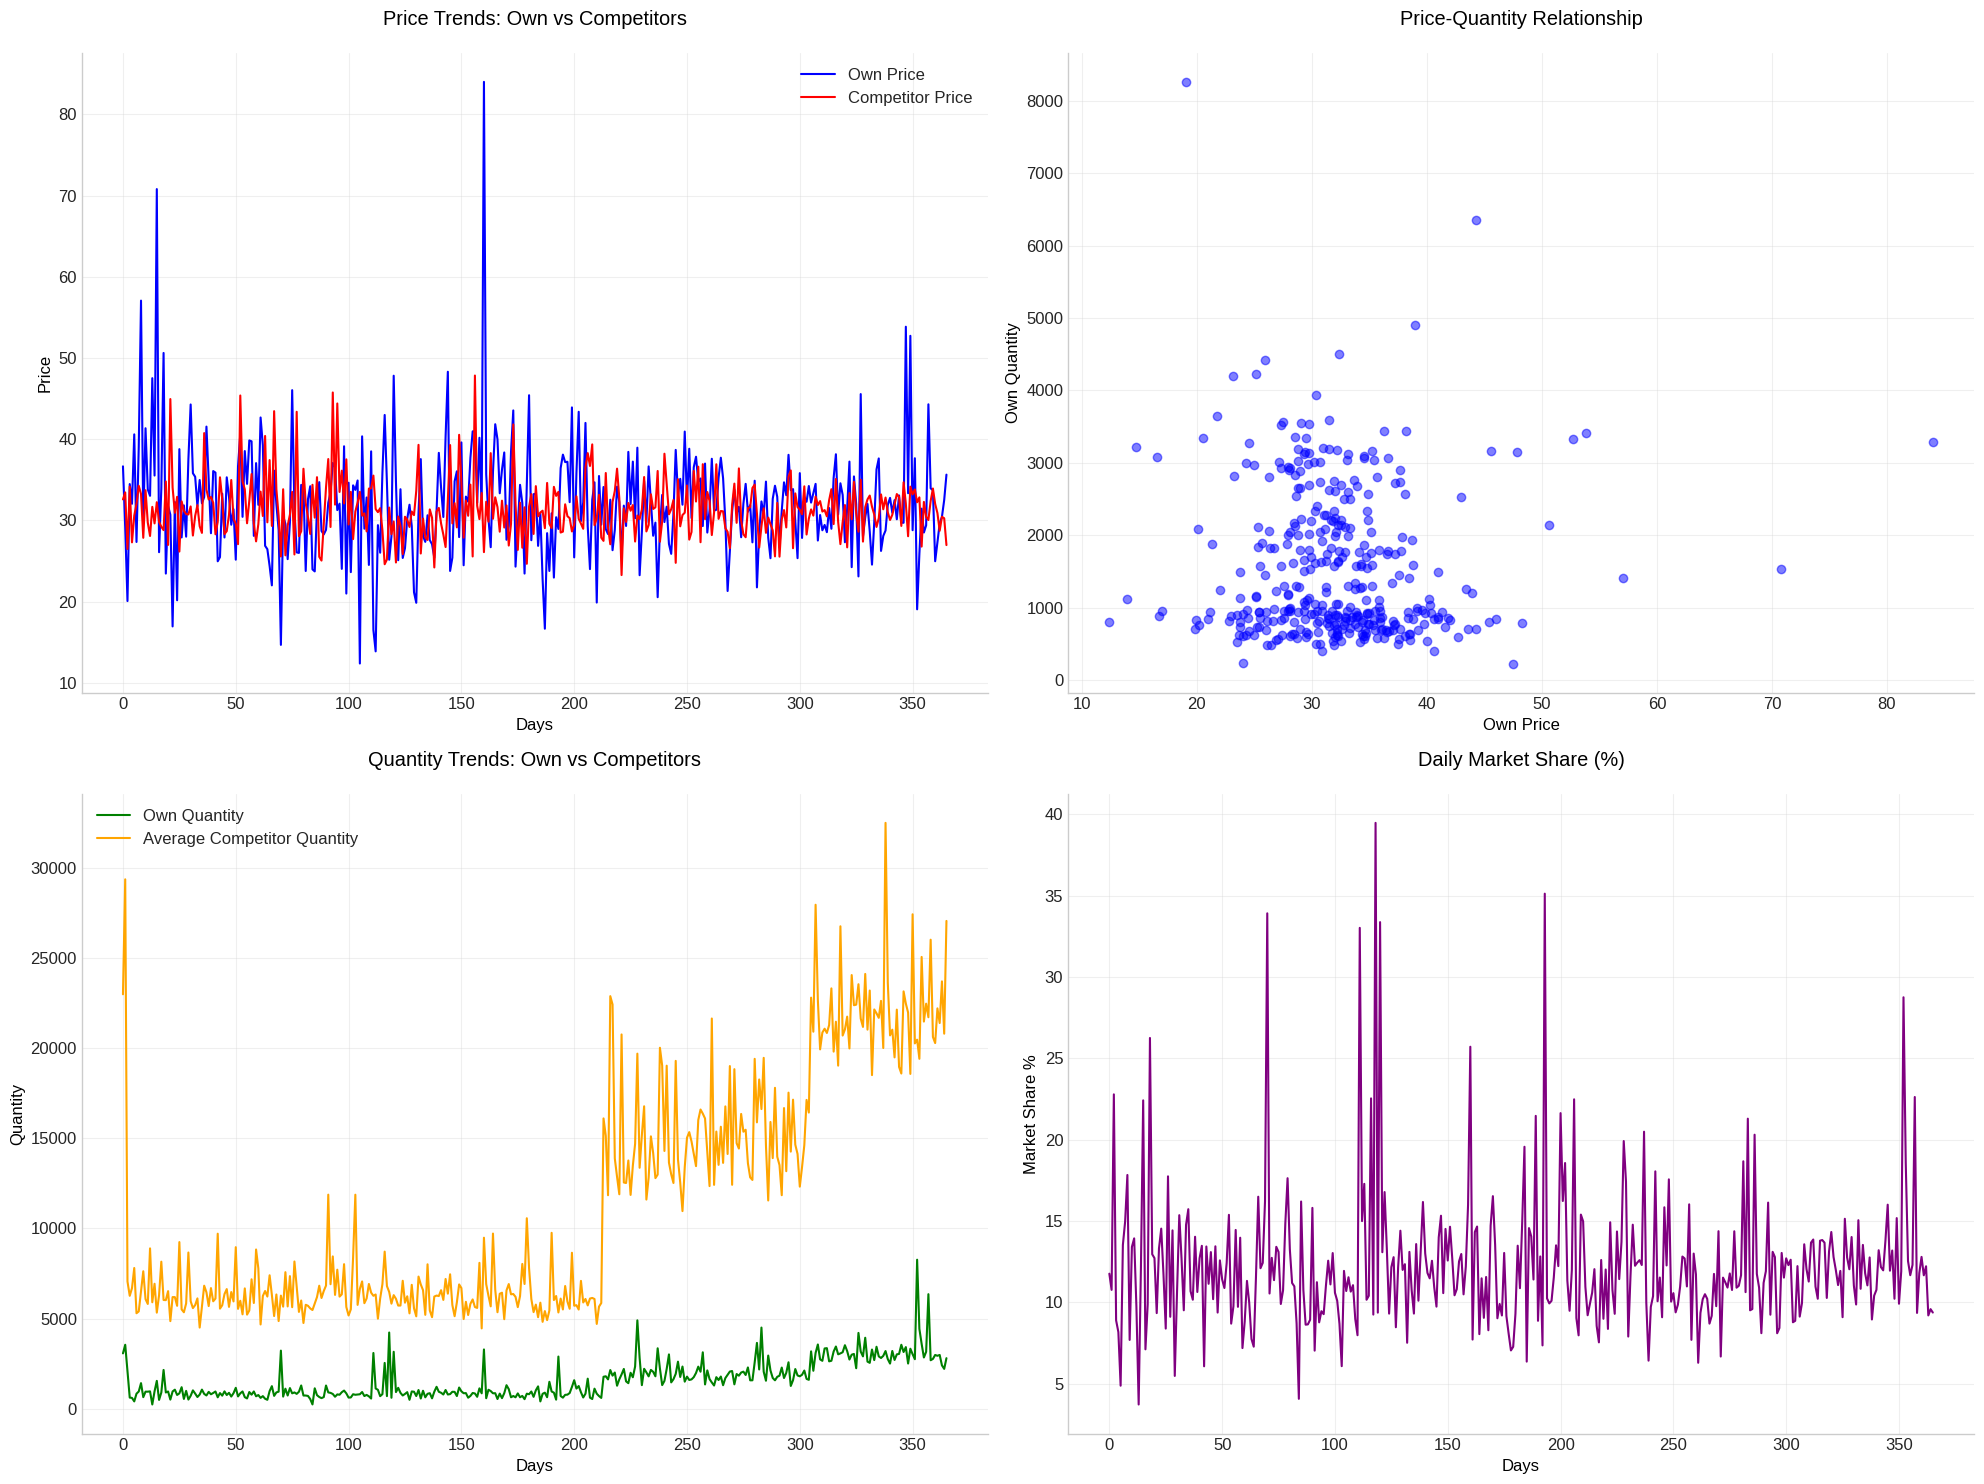


Elasticity Analysis:
Own Price Elasticity: -0.027
Cross Price Elasticity: -0.020

Summary Statistics:
Average Own Price: $32.16
Average Competitor Price: $31.41
Average Daily Quantity (Own): 1573.3
Average Market Share: 12.3%


In [26]:
def analyze_shoes_elasticity(df):
    """Analyze price elasticity for books from manufacturer 193"""

    # 1. First let's verify the data
    print("\nInitial Data Check:")
    print("Total Shoes Records:", df.count())
    print("Records for Manufacturer 227:",
          df.filter((col('I_MANUFACT_ID') == 320)).count())

    # 2. Filter and create base metrics
    shoes_df = cleaned_df

    # 3. Calculate daily metrics
    daily_metrics = shoes_df.groupBy('SS_SOLD_DATE_SK').agg(
        # Own metrics (Manufacturer 193)
        avg(when(col('I_MANUFACT_ID') == 320, col('SS_SALES_PRICE')).otherwise(None))
            .alias('own_price'),
        sum(when(col('I_MANUFACT_ID') == 320, col('SS_QUANTITY')).otherwise(0))
            .alias('own_quantity'),
        # Competitor metrics
        avg(when(col('I_MANUFACT_ID') != 320, col('SS_SALES_PRICE')).otherwise(None))
            .alias('competitor_price'),
        sum(when(col('I_MANUFACT_ID') != 320, col('SS_QUANTITY')).otherwise(0))
            .alias('competitor_quantity')
    ).orderBy('SS_SOLD_DATE_SK')

    metrics_pd = daily_metrics.toPandas()

    print("\nDaily Metrics Summary:")
    print(metrics_pd.describe())

    # Create visualizations only if we have valid data
    if not metrics_pd.empty and metrics_pd['own_price'].notna().any():
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.patch.set_alpha(0)

        # 1. Price Trends
        ax = axes[0,0]
        ax.patch.set_alpha(0)
        ax.plot(range(len(metrics_pd)), metrics_pd['own_price'], label='Own Price', color='blue')
        ax.plot(range(len(metrics_pd)), metrics_pd['competitor_price'],
                label='Competitor Price', color='red')
        ax.set_title('Price Trends: Own vs Competitors', color='black', pad=20)
        ax.set_xlabel('Days', color='black')
        ax.set_ylabel('Price', color='black')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Quantity vs Price
        ax = axes[0,1]
        ax.patch.set_alpha(0)
        ax.scatter(metrics_pd['own_price'], metrics_pd['own_quantity'],
                  alpha=0.5, color='blue')
        ax.set_xlabel('Own Price', color='black')
        ax.set_ylabel('Own Quantity', color='black')
        ax.set_title('Price-Quantity Relationship', color='black', pad=20)
        ax.grid(True, alpha=0.3)

        # 3. Daily Quantities
        ax = axes[1,0]
        ax.patch.set_alpha(0)
        ax.plot(range(len(metrics_pd)), metrics_pd['own_quantity'],
                label='Own Quantity', color='green')
        ax.plot(range(len(metrics_pd)), metrics_pd['competitor_quantity'],
                label='Average Competitor Quantity', color='orange')
        ax.set_title('Quantity Trends: Own vs Competitors', color='black', pad=20)
        ax.set_xlabel('Days', color='black')
        ax.set_ylabel('Quantity', color='black')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 4. Market Share
        ax = axes[1,1]
        ax.patch.set_alpha(0)
        total_quantity = metrics_pd['own_quantity'] + metrics_pd['competitor_quantity']
        market_share = metrics_pd['own_quantity'] / total_quantity * 100
        ax.plot(range(len(metrics_pd)), market_share, color='purple')
        ax.set_title('Daily Market Share (%)', color='black', pad=20)
        ax.set_xlabel('Days', color='black')
        ax.set_ylabel('Market Share %', color='black')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # calculate elasticities
        print("\nElasticity Analysis:")
        metrics_pd['own_price_pct_change'] = metrics_pd['own_price'].pct_change()
        metrics_pd['own_quantity_pct_change'] = metrics_pd['own_quantity'].pct_change()
        metrics_pd['competitor_price_pct_change'] = metrics_pd['competitor_price'].pct_change()

        # remove infinite values
        metrics_pd = metrics_pd.replace([np.inf, -np.inf], np.nan)

        # Own price elasticity
        own_elasticity = metrics_pd['own_quantity_pct_change'].corr(
            metrics_pd['own_price_pct_change']
        )
        print(f"Own Price Elasticity: {own_elasticity:.3f}")

        # cross price elasticity
        cross_elasticity = metrics_pd['own_quantity_pct_change'].corr(
            metrics_pd['competitor_price_pct_change']
        )
        print(f"Cross Price Elasticity: {cross_elasticity:.3f}")

        # statistics
        print("\nSummary Statistics:")
        print(f"Average Own Price: ${metrics_pd['own_price'].mean():.2f}")
        print(f"Average Competitor Price: ${metrics_pd['competitor_price'].mean():.2f}")
        print(f"Average Daily Quantity (Own): {metrics_pd['own_quantity'].mean():.1f}")
        print(f"Average Market Share: {market_share.mean():.1f}%")

    else:
        print("Warning: Insufficient data for visualization")

    return metrics_pd

elasticity_results = analyze_shoes_elasticity(cleaned_df)

Comment: The above code analyzes our chosen Manufacturer 320 and visualizes its market share, sales volume etc, comparing with the competitors.

# *DATA PREPROCESSING, FEATURE ENGINEERING, MODELLING*

In [27]:

req_columns = [
    #     'SS_SOLD_DATE_SK', 'SS_SOLD_TIME_SK',
    "SS_ITEM_SK",
    #  'SS_CUSTOMER_SK',
    #    'SS_CDEMO_SK', 'SS_HDEMO_SK', 'SS_ADDR_SK', 'SS_STORE_SK',
    #    'SS_PROMO_SK',
    #    'SS_TICKET_NUMBER',
    "SS_QUANTITY",
    "SS_WHOLESALE_COST",
    "SS_LIST_PRICE",
    "SS_SALES_PRICE",
    "SS_EXT_DISCOUNT_AMT",
    "SS_EXT_SALES_PRICE",
    "SS_EXT_WHOLESALE_COST",
    "SS_EXT_LIST_PRICE",
    "SS_EXT_TAX",
    "SS_COUPON_AMT",
    "SS_NET_PAID",
    "SS_NET_PAID_INC_TAX",
    "SS_NET_PROFIT",
    "S_STORE_SK",
    "S_STORE_ID",
    "S_REC_START_DATE",
    "S_REC_END_DATE",
    "S_CLOSED_DATE_SK",
    "S_STORE_NAME",
    "S_HOURS",
    #    'S_MANAGER', 'S_MARKET_ID', ' S_GEOGRAPHY_CLASS', 'S_MARKET_DESC',
    #    'S_COMPANY_ID', 'S_COMPANY_NAME', 'S_STREET_NUMBER', 'S_STREET_NAME',
    #    'S_STREET_TYPE', 'S_SUITE_NUMBER',
    "S_CITY",
    "S_COUNTY",
    "S_STATE",
    "S_ZIP",
    "S_COUNTRY",
    "S_GMT_OFFSET",
    "S_TAX_PRECENTAGE",
    "DATE_COLUMN",
    "YEAR_COLUMN",
    "CD_DEMO_SK",
    "CD_GENDER",
    "CD_MARITAL_STATUS",
    "CD_EDUCATION_STATUS",
    "CD_PURCHASE_ESTIMATE",
    "CD_CREDIT_RATING",
    "CD_DEP_COUNT",
    "CD_DEP_EMPLOYED_COUNT",
    "CD_DEP_COLLEGE_COUNT",
    "HD_DEMO_SK",
    "HD_INCOME_BAND_SK",
    "HD_BUY_POTENTIAL",
    "HD_DEP_COUNT",
    "HD_VEHICLE_COUNT",
    "I_ITEM_SK",
    "I_ITEM_ID",
    "I_ITEM_DESC",
    "I_BRAND_ID",
    "I_BRAND",
    "I_CLASS_ID",
    "I_CLASS",
    "I_CATEGORY_ID",
    "I_CATEGORY",
    "I_MANUFACT_ID",
    "I_MANUFACT",
    "I_SIZE",
    "I_FORMULATION",
    "I_COLOR",
    "I_UNITS",
    "I_MANAGER_ID",
    "I_PRODUCT_NAME",
    #      'P_PROMO_SK',
    #    'P_PROMO_ID', 'P_START_DATE_SK', 'P_END_DATE_SK', 'P_ITEM_SK', 'P_COST',
    #    'P_PROMO_NAME',
    "P_DISCOUNT_ACTIVE",
]

print(len(req_columns))

62


In [28]:


spark_df = raw_df.withColumn("I_CATEGORY", F.lit("Women's Shoes"))
spark_df= spark_df.dropna()
n = 500_000
spark_df = spark_df.orderBy(F.rand()).limit(n)
# spark_df = spark_df.select(req_columns)


spark_df = spark_df.drop('CD_DEMO_SK',
 'HD_BUY_POTENTIAL',
 'HD_DEMO_SK',
 'I_MANUFACT',
 'I_PRODUCT_NAME',
 'SS_COUPON_AMT',
 'SS_ITEM_SK',
 'SS_NET_PAID',
 'SS_SOLD_DATE_SK',
 'SS_SOLD_TIME_SK',)
spark_df.show(5)

# spark_df

+-----------+-----------+-----------+-----------------+-------------+--------------+-------------+----------+----------------+-------+---------+-----------------+-------------------+--------------------+-----------------+---------+----------+----------------+-------------+-----------------+-------------+
|DATE_COLUMN|YEAR_COLUMN|SS_QUANTITY|SS_WHOLESALE_COST|SS_LIST_PRICE|SS_SALES_PRICE|SS_NET_PROFIT|S_STORE_SK|      S_STORE_ID|S_STATE|CD_GENDER|CD_MARITAL_STATUS|CD_EDUCATION_STATUS|CD_PURCHASE_ESTIMATE|HD_INCOME_BAND_SK|I_ITEM_SK|I_BRAND_ID|         I_BRAND|I_MANUFACT_ID|P_DISCOUNT_ACTIVE|   I_CATEGORY|
+-----------+-----------+-----------+-----------------+-------------+--------------+-------------+----------+----------------+-------+---------+-----------------+-------------------+--------------------+-----------------+---------+----------+----------------+-------------+-----------------+-------------+
| 2002-06-23|       2002|          1|             48.1|        65.41|         53.6

## Feature Engineering

Key Functions:

1. `add_price_positioning`:

Tells us how a product's price compares to others in its category

Calculates things like price gaps and price ranks percentile-wise


2. `add_competitor_metrics`:

Analyzes the competitive landscape around our products

Shows how far our price is from premium products

Tells how spread out competitor prices are


3. `add_historical_features`:

Tracks how prices change over time

Shows average prices over 30, 60, and 90 days


4. `add_promotional_features`:

Analyzes discounting patterns

Shows how deep discounts are compared to others

Tracks how often promotions are run



5. `add_regional_features`:

Looks at how market conditions vary by region

Considers things like store density and local income levels




![image.png](attachment:image.png)

In [29]:
from pyspark.sql import Window
import pyspark.sql.functions as F

def add_price_positioning(df):
    """Adding price positioning features to dataframe"""
    # Define column names
    PRICE_COL = "SS_SALES_PRICE"
    CATEGORY_COL = "I_CATEGORY"


    PRICE_GAP_COL = "price_gap_category"
    PRICE_INDEX_COL = "relative_price_index"
    PRICE_PERCENTILE_COL = "price_percentile"

    category_window = Window.partitionBy(CATEGORY_COL)

    # price gap
    df = df.withColumn(
        PRICE_GAP_COL,
        F.col(PRICE_COL) - F.avg(PRICE_COL).over(category_window)
    )

    # relative price index
    df = df.withColumn(
        PRICE_INDEX_COL,
        F.col(PRICE_COL) / F.avg(PRICE_COL).over(category_window)
    )

    # price percentile
    df = df.withColumn(
        PRICE_PERCENTILE_COL,
        F.percent_rank().over(category_window.orderBy(PRICE_COL))
    )

    return df

def add_competitor_metrics(df):
    """Adding competitor metrics to dataframe"""
    # Define column names
    PRICE_COL = "SS_SALES_PRICE"
    CATEGORY_COL = "I_CATEGORY"
    MANUFACTURER_COL = "I_MANUFACT_ID"


    COMPETITORS_BAND_COL = "competitors_in_band"
    PREMIUM_DISTANCE_COL = "premium_distance"
    PRICE_DISPERSION_COL = "price_dispersion"
    SHARE_ABOVE_COL = "share_above"


    category_window = Window.partitionBy(CATEGORY_COL)
    manufacturer_window = Window.partitionBy(MANUFACTURER_COL)
    price_band_window = category_window.orderBy(PRICE_COL)

    # Add competitors in price band
    # price_band_df = df.withColumn(
    #     "price_band_lower",
    #     F.col(PRICE_COL) - F.col(PRICE_COL) * 0.1
    # ).withColumn(
    #     "price_band_upper",
    #     F.col(PRICE_COL) + F.col(PRICE_COL) * 0.1
    # )

    # df = df.join(
    #     price_band_df,
    #     on=category_window,
    #     how="left"
    # ).filter(
    #     (F.col(PRICE_COL) >= F.col("price_band_lower")) &
    #     (F.col(PRICE_COL) <= F.col("price_band_upper"))
    # )

    # Add competitors in price band
    # df = df.withColumn(
    #     COMPETITORS_BAND_COL,
    #     F.count("*").over(category_window)
    # )

    # premium price distance
    df = df.withColumn(
        PREMIUM_DISTANCE_COL,
        F.max(PRICE_COL).over(manufacturer_window) - F.col(PRICE_COL)
    )

    # price dispersion
    df = df.withColumn(
        PRICE_DISPERSION_COL,
        F.stddev(PRICE_COL).over(manufacturer_window)
    )

    # share above current price
    df = df.withColumn(
        SHARE_ABOVE_COL,
        F.count(F.when(F.col(PRICE_COL) > F.col(PRICE_COL), 1)).over(manufacturer_window) /
        F.count("*").over(manufacturer_window)
    )

    return df

def add_historical_features(df):
    """Adding historical price features to dataframe"""
    # Define column names
    PRICE_COL = "SS_SALES_PRICE"
    PRODUCT_COL = "I_ITEM_SK"
    DATE_COL = "DATE_COLUMN"


    PRICE_CHANGE_COL = "price_change"
    PRICE_AVG_30D_COL = "price_avg_30d"
    PRICE_AVG_60D_COL = "price_avg_60d"
    PRICE_AVG_90D_COL = "price_avg_90d"


    product_time_window = Window.partitionBy(PRODUCT_COL).orderBy(DATE_COL)

    # price change
    df = df.withColumn(
        PRICE_CHANGE_COL,
        (F.col(PRICE_COL) - F.lag(PRICE_COL, 1).over(product_time_window)) /
        F.lag(PRICE_COL, 1).over(product_time_window)
    )



    # 30-day moving average
    df = df.withColumn(
        PRICE_AVG_30D_COL,
        F.avg(PRICE_COL).over(
            product_time_window.rowsBetween(-30, 0)
        )
    )

    # 60-day moving average
    df = df.withColumn(
        PRICE_AVG_60D_COL,
        F.avg(PRICE_COL).over(
            product_time_window.rowsBetween(-60, 0)
        )
    )

    # 90-day moving average
    df = df.withColumn(
        PRICE_AVG_90D_COL,
        F.avg(PRICE_COL).over(
            product_time_window.rowsBetween(-90, 0)
        )
    )

    return df

def add_promotional_features(df):
    """Adding promotional features to dataframe"""
    # Define column names
    LIST_PRICE_COL = "SS_LIST_PRICE"
    SALES_PRICE_COL = "SS_SALES_PRICE"
    DISCOUNT_COL = "P_DISCOUNT_ACTIVE"
    CATEGORY_COL = "I_CATEGORY"
    PRODUCT_COL = "I_ITEM_SK"
    DATE_COL = "DATE_COLUMN"


    DISCOUNT_DEPTH_COL = "discount_depth"
    REL_DISCOUNT_COL = "relative_discount"
    PROMO_FREQ_COL = "promo_frequency"


    category_window = Window.partitionBy(CATEGORY_COL)
    promo_window = Window.partitionBy(PRODUCT_COL).orderBy(DATE_COL).rowsBetween(-90, 0)

    # discount depth
    df = df.withColumn(
        DISCOUNT_DEPTH_COL,
        (F.col(LIST_PRICE_COL) - F.col(SALES_PRICE_COL)) / F.col(LIST_PRICE_COL)
    )

    # relative discount
    df = df.withColumn(
        REL_DISCOUNT_COL,
        F.col(DISCOUNT_DEPTH_COL) / F.avg(DISCOUNT_DEPTH_COL).over(category_window)
    )

    # promotional frequency
    df = df.withColumn(
        PROMO_FREQ_COL,
        F.count(F.when(F.col(DISCOUNT_COL) == 1, 1)).over(promo_window) / 90
    )

    return df

def add_regional_features(df):
    """Adding regional features to dataframe"""
    # Define column names
    STORE_ID_COL = "S_STORE_ID"
    REGION_COL = "S_STATE"  # Using state as region
    CATEGORY_COL = "I_CATEGORY"
    MANUFACTURER_COL = "I_MANUFACT_ID"
    INCOME_BAND_COL = "HD_INCOME_BAND_SK"


    STORE_DENSITY_COL = "store_density"
    REGIONAL_COMPETITION_COL = "regional_competition"
    REGION_INCOME_COL = "region_income"


    region_window = Window.partitionBy(REGION_COL)
    region_category_window = Window.partitionBy(REGION_COL, CATEGORY_COL)

    # store density
    df = df.withColumn(
        STORE_DENSITY_COL,
        F.count(STORE_ID_COL).over(region_window)
    )

    # regional competition
    df = df.withColumn(
        REGIONAL_COMPETITION_COL,
        F.count(MANUFACTURER_COL).over(region_category_window) /
        F.count(STORE_ID_COL).over(region_window)
    )

    # region income
    df = df.withColumn(
        REGION_INCOME_COL,
        F.avg(INCOME_BAND_COL).over(region_window)
    )

    return df




df1 = add_price_positioning(spark_df)
# df1.show()
df2 = add_competitor_metrics(df1)
# df2.show()
df3 = add_historical_features(df2)
# df3.show()
df4 = add_promotional_features(df3)
# df4.show()
final_df = add_regional_features(df4)
final_df.show(5)


+-----------+-----------+-----------+-----------------+-------------+--------------+-------------+----------+----------------+-------+---------+-----------------+-------------------+--------------------+-----------------+---------+----------+----------------+-------------+-----------------+-------------+-------------------+--------------------+------------------+----------------+-----------------+-----------+--------------------+------------------+------------------+------------------+-------------------+-------------------+---------------+-------------+--------------------+------------------+
|DATE_COLUMN|YEAR_COLUMN|SS_QUANTITY|SS_WHOLESALE_COST|SS_LIST_PRICE|SS_SALES_PRICE|SS_NET_PROFIT|S_STORE_SK|      S_STORE_ID|S_STATE|CD_GENDER|CD_MARITAL_STATUS|CD_EDUCATION_STATUS|CD_PURCHASE_ESTIMATE|HD_INCOME_BAND_SK|I_ITEM_SK|I_BRAND_ID|         I_BRAND|I_MANUFACT_ID|P_DISCOUNT_ACTIVE|   I_CATEGORY| price_gap_category|relative_price_index|  price_percentile|premium_distance| price_dispersion

## Define columns to be used later on in code

In [30]:
# Key identifiers
id_cols = [
    'I_ITEM_SK',
    'I_MANUFACT_ID',
    'DATE_COLUMN',
    'S_STATE'
]

# Target/Response variables
target_cols = [
    'SS_QUANTITY',
    'SS_SALES_PRICE'
]

# Product attributes
product_cols = [
    'I_CATEGORY',
    'I_BRAND'
]

# Engineered features
feature_cols = [
'price_gap_category',
 'relative_price_index',
 'price_percentile',
 'premium_distance',
 'price_dispersion',
 'share_above',
 'price_change',
 'price_avg_30d',
 'price_avg_60d',
 'price_avg_90d',
 'discount_depth',
 'relative_discount',
 'promo_frequency',
 'store_density',
 'regional_competition',
 'region_income',
 'HD_INCOME_BAND_SK',
 'SS_LIST_PRICE',
 'CD_PURCHASE_ESTIMATE'
]

# Financial metrics
financial_cols = [
    'SS_NET_PROFIT',
    'SS_WHOLESALE_COST' ]

cat_columns= ['CD_EDUCATION_STATUS',
 'CD_GENDER',
 'CD_MARITAL_STATUS',
 'I_BRAND_ID',
 'P_DISCOUNT_ACTIVE',
 'S_STORE_ID']

# Combine all columns
selected_columns = (
    id_cols +
    target_cols +
    product_cols +
    feature_cols +
    financial_cols+ cat_columns
)



# Convert ctegorical col dtypes
final_df2 = final_df.select(selected_columns)

def cat_cols_dtype_conversion(df, categorical_columns):

    for col in categorical_columns:
        col_type = type(df.schema[col].dataType)
        print(f"Column {col} has type: {col_type}")

        # Convert any non-string type to string
        if not isinstance(df.schema[col].dataType, StringType):
            df = df.withColumn(
                col,
                F.when(F.col(col).isNull(), None)
                .otherwise(F.col(col).cast("string"))
            )

        # Handle nulls
        df = df.withColumn(
            col,
            F.coalesce(F.col(col), F.lit("MISSING"))
        )


    return df


final_df2 = cat_cols_dtype_conversion(final_df2, cat_columns)

Column CD_EDUCATION_STATUS has type: <class 'pyspark.sql.types.StringType'>
Column CD_GENDER has type: <class 'pyspark.sql.types.StringType'>
Column CD_MARITAL_STATUS has type: <class 'pyspark.sql.types.StringType'>
Column I_BRAND_ID has type: <class 'pyspark.sql.types.IntegerType'>
Column P_DISCOUNT_ACTIVE has type: <class 'pyspark.sql.types.StringType'>
Column S_STORE_ID has type: <class 'pyspark.sql.types.StringType'>


## Pre-modelling Data Prereprocessing

Key Functions:

`preprocess_for_elasticity`:


Filters data for specific manufacturers

Handles missing values

Removes statistical outliers (3 standard deviations)

Cleans data for price elasticity analysis


`one_hot_encode_categories`:


Converts categorical variables into numerical format

Uses string indexing and one-hot encoding


`time_based_split_explicit`:


Splits data into training and test sets based on time

Maintains temporal order of data



`calculate_metrics`:


Evaluates model performance

Calculates standard metrics (RMSE, MAE)

Includes business-relevant metrics (MAPE, MedAPE)

`prepare_features`:


Creates the final feature vector pre ML
Handles two types of features:

Numeric features (price gaps, discounts, etc.)
Encoded categorical features (education, gender, etc.)


![image.png](attachment:image.png)

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.regression import (
    GBTRegressor,
    RandomForestRegressor,
    DecisionTreeRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator


def preprocess_for_elasticity(df, manufacturer_id_list:list = None, remove_outliers=True):

    if manufacturer_id_list is not None:
        # Filter specific manufacturer if needed
        df = df.withColumn(
        "is_target_manufacturer",
        F.when(
            F.col("I_MANUFACT_ID").isin(manufacturer_id_list),
            1
        ).otherwise(0)
    )

    # Handle nulls
    df = df.dropna(subset=["SS_QUANTITY", "SS_SALES_PRICE"])
    # df = df.dropna()

    if remove_outliers:
        # Remove outliers
        for col in ["SS_QUANTITY", "SS_SALES_PRICE", "SS_NET_PROFIT"]:
            stats = df.select(
                F.mean(col).alias("mean"),
                F.stddev(col).alias("stddev")
            ).collect()[0]
            df = df.filter(
                (F.col(col) <= stats.mean + 3 * stats.stddev) &
                (F.col(col) >= stats.mean - 3 * stats.stddev)
            )

    return df


def one_hot_encode_categories(df, categorical_columns: List[str], drop_originals: bool = True):
    """
    One-hot encodes multiple categorical columns in a PySpark DataFrame.

    Returns the transformed DataFrame with one-hot encoded columns
    """
    indexers = [
        StringIndexer(
            inputCol=col,
            outputCol=f"{col}_indexed",
            handleInvalid="keep"
        )
        for col in categorical_columns
    ]

    # Create one-hot encoders
    encoders = [
        OneHotEncoder(
            inputCol=f"{col}_indexed",
            outputCol=f"{col}_encoded",
            dropLast=True
        )
        for col in categorical_columns
    ]


    pipeline = Pipeline(stages=indexers + encoders)
    model = pipeline.fit(df)
    encoded_df = model.transform(df)

    # Drop intermediate indexed columns
    columns_to_drop = [f"{col}_indexed" for col in categorical_columns]

    # Optionally drop original categorical columns
    if drop_originals:
        columns_to_drop.extend(categorical_columns)

    encoded_df = encoded_df.drop(*columns_to_drop)

    return encoded_df

def time_based_split_explicit(df, date_col="DATE_COLUMN", train_ratio=0.8):
    # Order by date and get min/max dates
    min_date = df.agg(F.min(date_col)).collect()[0][0]
    max_date = df.agg(F.max(date_col)).collect()[0][0]

    # Calculate cutoff date
    date_range = max_date - min_date
    cutoff_date = min_date + (date_range * train_ratio)

    # Split
    train = df.filter(F.col(date_col) <= F.lit(cutoff_date))
    test = df.filter(F.col(date_col) > F.lit(cutoff_date))


    return train, test

def calculate_metrics(predictions_df):
    """Calculate all regression metrics including NRMSE, MAPE, MedAPE"""

    # Standard metrics using evaluator
    evaluator = RegressionEvaluator(
        labelCol="SS_QUANTITY",
        predictionCol="prediction"
    )

    rmse = evaluator.setMetricName("rmse").evaluate(predictions_df)
    mae = evaluator.setMetricName("mae").evaluate(predictions_df)

    # Calculate additional metrics
    metrics_df = predictions_df.select(
        "SS_QUANTITY",
        "prediction"
    ).agg(
        # For NRMSE
        F.stddev("SS_QUANTITY").alias("y_std"),
        F.mean("SS_QUANTITY").alias("y_mean"),

        # For MAPE and MedAPE
        F.mean(F.abs((F.col("SS_QUANTITY") - F.col("prediction")) / F.col("SS_QUANTITY"))).alias("mape"),
        F.expr("percentile_approx(abs((SS_QUANTITY - prediction) / SS_QUANTITY), 0.5)").alias("medape")
    ).collect()[0]

    # Calculate NRMSE
    nrmse = rmse / metrics_df.y_std

    # Compile all metrics
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'median_error_percentage': float(metrics_df.medape)*100
    }

    # print("Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

    return metrics

In [32]:
final_df3 = preprocess_for_elasticity(final_df2,[320])
final_df3 = one_hot_encode_categories(final_df3, cat_columns)
# final_df3.show(5)
train_df, test_df = time_based_split_explicit(final_df3)
# print(f"Train set size: {train_df.count()}")
# print(f"Test set size: {test_df.count()}")
train_df.show(5)
# test_df.show(5)


+---------+-------------+-----------+-------+-----------+--------------+-------------+----------------+-------------------+--------------------+------------------+----------------+-----------------+-----------+--------------------+------------------+------------------+------------------+-------------------+-------------------+---------------+-------------+--------------------+------------------+-----------------+-------------+--------------------+-------------+-----------------+----------------------+---------------------------+-----------------+-------------------------+------------------+-------------------------+------------------+
|I_ITEM_SK|I_MANUFACT_ID|DATE_COLUMN|S_STATE|SS_QUANTITY|SS_SALES_PRICE|   I_CATEGORY|         I_BRAND| price_gap_category|relative_price_index|  price_percentile|premium_distance| price_dispersion|share_above|        price_change|     price_avg_30d|     price_avg_60d|     price_avg_90d|     discount_depth|  relative_discount|promo_frequency|store_density

In [33]:


def prepare_features(df):
    """Prepare feature vector for modeling"""
    feature_columns = [
        'price_gap_category', 'relative_price_index', 'price_percentile',
        'premium_distance', 'price_dispersion', 'share_above',
        'price_change', 'price_avg_30d', 'price_avg_60d', 'price_avg_90d',
        'discount_depth', 'relative_discount', 'promo_frequency',
        'store_density', 'regional_competition', 'region_income',
        'SS_SALES_PRICE',
        'CD_EDUCATION_STATUS_encoded',
        'CD_GENDER_encoded',
        'CD_MARITAL_STATUS_encoded',
        # 'DATE_COLUMN',
        'I_BRAND_ID_encoded',
        'P_DISCOUNT_ACTIVE_encoded',
        'S_STORE_ID_encoded'
    ]
    numeric_cols = [col for col in feature_columns if not col.endswith('_encoded')]

    # Handle nulls in feature columns
    for col in feature_columns:
        if col  in numeric_cols:
            df = df.withColumn(
                col,
                F.coalesce(F.col(col), F.lit(0.0))  # Replace nulls with 0
            )

    # Check for any remaining nulls
    print("Null counts after handling:")
    # df.select([
    #     F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    #     for c in feature_columns
    # ]).show()


    assembler = VectorAssembler(
        inputCols=feature_columns,
        outputCol="features"
    )

    return assembler.transform(df).select("features", "SS_QUANTITY")



## Model training:

Training 3 models - Random Forest, Gradient Boosted Tree, and Decision Tree

In [34]:
def train_random_forest(train_df, test_df):
    """Train Random Forest model with enhanced metrics"""
    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)

    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY",
        numTrees=50,
        maxDepth=5,
        seed=42
    )

    model = rf.fit(train_data)
    predictions = model.transform(test_data)
    predictions_train = model.transform(train_data)
    print(f"predicitions ready - {type(predictions)}")
    print("Test Metrics: ...")
    metrics = calculate_metrics(predictions)

    print("Train Metrics: ...")
    train_metrics = calculate_metrics(predictions_train)

    return model, predictions, metrics, predictions_train


def tune_random_forest(train_df, test_df):
    """
    Train Random Forest model with hyperparameter tuning using cross validation
    Returns the best model, predictions, and metrics for both train and test sets
    """
    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)


    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY",
        seed=42
    )


    parameter_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100, 200]) \
        .addGrid(rf.maxDepth, [5, 7, 10]) \
        .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
        .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2']) \
        .build()


    evaluator = RegressionEvaluator(
        labelCol="SS_QUANTITY",
        predictionCol="prediction",
        metricName="rmse"
    )


    crossval_object = CrossValidator(
        estimator=rf,
        estimatorParamMaps=parameter_grid,
        evaluator=evaluator,
        numFolds=3,
        seed=42
    )


    print("Starting cross-validation...")
    crossval_model = crossval_object.fit(train_data)


    best_model = crossval_model.bestModel


    predictions_test = best_model.transform(test_data)
    predictions_train = best_model.transform(train_data)

    # Calculate metrics
    print("\nTest Metrics:")
    test_metrics = calculate_metrics(predictions_test)

    print("\nTrain Metrics:")
    train_metrics = calculate_metrics(predictions_train)

    return best_model, predictions_test, test_metrics, predictions_train, train_metrics


rf_model, rf_preds, rf_metrics, rf_preds_train = train_random_forest(train_df, test_df)

Null counts after handling:
Null counts after handling:
predicitions ready - <class 'pyspark.sql.dataframe.DataFrame'>
Test Metrics: ...
rmse: 25.485841686764985
mae: 20.426771441633612
median_error_percentage: 68.20169471843425
Train Metrics: ...
rmse: 25.48149020859064
mae: 20.579818073063127
median_error_percentage: 66.76293952352911


In [35]:
def train_gbt(train_df, test_df):
    """Train Gradient Boosted Trees model with enhanced metrics"""
    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)

    gbt = GBTRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY",
        maxIter=10,
        maxDepth=5,
        stepSize=0.1
    )

    model = gbt.fit(train_data)
    predictions = model.transform(test_data)
    print("Test Metrics: ...")
    metrics = calculate_metrics(predictions)

    return model, predictions, metrics

def tune_gbt(train_df, test_df):
    """Tune GBT model with cross validation"""

    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)


    gbt = GBTRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY"
    )


    parameter_grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 7]) \
        .addGrid(gbt.maxIter, [10, 20]) \
        .addGrid(gbt.stepSize, [0.05, 0.1, 0.15]) \
        .build()


    evaluator = RegressionEvaluator(
        labelCol="SS_QUANTITY",
        predictionCol="prediction",
        metricName="rmse"
    )

    crossval_object = CrossValidator(
        estimator=gbt,
        estimatorParamMaps=parameter_grid,
        evaluator=evaluator,
        numFolds=3
    )

    crossval_model = crossval_object.fit(train_data)


    best_model = crossval_model.bestModel

    predictions = best_model.transform(test_data)
    metrics = calculate_metrics(predictions)

    return best_model, predictions, metrics

gbt_model, gbt_preds, gbt_metrics = train_gbt(train_df, test_df)

Null counts after handling:
Null counts after handling:
Test Metrics: ...


In [36]:
def train_decision_tree(train_df, test_df):
    """Train Decision Tree model with enhanced metrics"""
    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)

    dt = DecisionTreeRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY",
        maxDepth=5
    )

    model = dt.fit(train_data)
    predictions = model.transform(test_data)
    print("Test Metrics: ...")
    metrics = calculate_metrics(predictions)

    return model, predictions, metrics

def tune_decision_tree(train_df, test_df):
    """
    Train Decision Tree model with hyperparameter tuning using cross validation
    Returns the best model, predictions, and metrics for both train and test sets
    """

    train_data = prepare_features(train_df)
    test_data = prepare_features(test_df)


    dt = DecisionTreeRegressor(
        featuresCol="features",
        labelCol="SS_QUANTITY",
        seed=42
    )


    parameter_grid = ParamGridBuilder() \
        .addGrid(dt.maxDepth, [5, 7, 10, 15]) \
        .addGrid(dt.minInstancesPerNode, [1, 2, 4, 8]) \
        .addGrid(dt.maxBins, [32, 64, 128]) \
        .addGrid(dt.impurity, ['variance', 'mse']) \
        .build()


    evaluator = RegressionEvaluator(
        labelCol="SS_QUANTITY",
        predictionCol="prediction",
        metricName="rmse"
    )

    crossval_object = CrossValidator(
        estimator=dt,
        estimatorParamMaps=parameter_grid,
        evaluator=evaluator,
        numFolds=3,
        seed=42
    )

    print("Starting cross-validation...")
    crossval_model = crossval_object.fit(train_data)


    best_model = crossval_model.bestModel


    predictions_test = best_model.transform(test_data)
    predictions_train = best_model.transform(train_data)

    print("\nTest Metrics:")
    test_metrics = calculate_metrics(predictions_test)

    print("\nTrain Metrics:")
    train_metrics = calculate_metrics(predictions_train)

    return best_model, predictions_test, test_metrics, predictions_train, train_metrics

dt_model, dt_preds, dt_metrics = train_decision_tree(train_df, test_df)

Null counts after handling:
Null counts after handling:
Test Metrics: ...
rmse: 25.516910965199486
mae: 20.384823595232838
median_error_percentage: 67.51354345770682


Comment: In the above lines of code, we run our model with our desired features after EDA. All of our three models give similar results.

## Optimizer

1.`create_price_grid` & `create_price_scenario`:

•	Creates range of price multipliers (0.7 to 1.3)

•	Applies price changes only to target products

•	Tests different pricing scenarios

2.`recalculate_price_features`:

•	Updates price-dependent features after price changes

•	Recalculates category-level metrics

•	Handles price gaps and relative indices

3.`predict_quantities`:

•	Makes predictions using trained model

•	Handles missing values in features

•	Assembles feature vector for prediction

•	Returns DataFrame with quantity predictions

4.`calculate_total_quantity` & `quantity_constraint` :

•	Calculates total quantity for target products

•	Enforces minimum quantity increase constraint

•	Returns percentage change in quantities

•	Used in optimization constraints

5.`get_dynamic_bounds`:

•	Calculates price bounds based on category averages

•	Sets lower/upper limits for price changes

•	Includes fallback to default bounds

•	Ensures valid bound ranges

6.`objective_function` & `Optimization`:

•	Maximizes revenue through price optimization

•	Uses scipy.optimize.minimize

•	Tests different price multipliers

•	Finds optimal price point

•	Includes constraints and bounds

Reports optimization results


![image.png](attachment:image.png)

In [37]:
#Prepare dataset

feat_cols = [
        'price_gap_category', 'relative_price_index', 'price_percentile',
        'premium_distance', 'price_dispersion', 'share_above',
        'price_change', 'price_avg_30d', 'price_avg_60d', 'price_avg_90d',
        'discount_depth', 'relative_discount', 'promo_frequency',
        'store_density', 'regional_competition', 'region_income',
        'SS_SALES_PRICE',
        'CD_EDUCATION_STATUS_encoded',
        'CD_GENDER_encoded',
        'CD_MARITAL_STATUS_encoded',
        # 'DATE_COLUMN',
        'I_BRAND_ID_encoded',
        'P_DISCOUNT_ACTIVE_encoded',
        'S_STORE_ID_encoded'
    ]



train_df2 = train_df.withColumn("row_index", F.monotonically_increasing_id())
rf_preds_train2 = rf_preds_train.select("*")
print(f"rf preds train count {rf_preds_train2.count()}")
rf_preds_train2 = rf_preds_train2.withColumn("row_index", F.monotonically_increasing_id())
rf_preds_train2 = rf_preds_train2.withColumn(
    "error_percentage",
    F.abs(F.col("SS_QUANTITY") - F.col("prediction")) / F.col("SS_QUANTITY") * 100
)

rf_preds_train2 = rf_preds_train2.where((F.col("error_percentage")<30)&(F.col("error_percentage")>0))

filtered_train_data = train_df2.join(
    rf_preds_train2.select("row_index"),
    on="row_index",
    how="inner"
).drop("row_index")



rf preds train count 102529


In [38]:
def create_price_grid(start=0.7, end=1.3, steps=10):
    """Create array of price multipliers"""
    return np.linspace(start, end, steps)

def create_price_scenario(df, price_multiplier):
    """
    Create new scenario with modified prices for target products
    """
    return df.withColumn(
        "SS_SALES_PRICE",
        F.when(
            F.col("is_target_manufacturer") == 1,
            F.col("SS_SALES_PRICE") * price_multiplier
        ).otherwise(F.col("SS_SALES_PRICE"))
    )

# Create price grid
multipliers = create_price_grid(0.7, 1.3, 7)
print("Price multipliers:", multipliers)

# Test first price scenario
test_scenario = create_price_scenario(filtered_train_data, multipliers[5])
print("\nOriginal vs New Prices for target products:")
test_scenario.filter(F.col("is_target_manufacturer") == 1).select(
    "I_ITEM_SK",
    "SS_SALES_PRICE"
).show(5)

Price multipliers: [0.7 0.8 0.9 1.  1.1 1.2 1.3]

Original vs New Prices for target products:
+---------+------------------+
|I_ITEM_SK|    SS_SALES_PRICE|
+---------+------------------+
|    54163|0.9360000000000002|
|   362919| 91.51200000000001|
|    90819|20.736000000000004|
|   253203|            64.284|
|   367927|11.064000000000002|
+---------+------------------+
only showing top 5 rows



In [39]:
def recalculate_price_features(df):
    """
    Recalculate price-dependent features after price changes
    """

    category_window = Window.partitionBy("I_CATEGORY")

    # Recalculate features
    return df.withColumn(
        "price_gap_category",
        F.col("SS_SALES_PRICE") - F.avg("SS_SALES_PRICE").over(category_window)
    ).withColumn(
        "relative_price_index",
        F.col("SS_SALES_PRICE") / F.avg("SS_SALES_PRICE").over(category_window)
    )


def predict_quantities(df,feature_columns, model = rf_model):
    """
    Make predictions using the bes model

    """
    # Handle nulls in feature columns
    numeric_cols = [col for col in feature_columns if not col.endswith('_encoded')]
    print(df.dtypes)
    for col in feature_columns:
        if col in numeric_cols:
            df = df.withColumn(
                col,
                F.coalesce(F.col(col), F.lit(0.0))
            )

    # feature vector
    assembler = VectorAssembler(
        inputCols=feature_columns,
        outputCol="features"
    )

    #  predictions
    df_assembled = assembler.transform(df)
    predictions = model.transform(df_assembled)

    return predictions

# Test the full pipeline for one price multiplier
test_multiplier = multipliers[0]

scenario_df = create_price_scenario(filtered_train_data, test_multiplier)


scenario_df = recalculate_price_features(scenario_df)

predictions = predict_quantities(df = scenario_df,model = rf_model, feature_columns = feat_cols)

# Show sample results for target products
print(f"\nResults for price multiplier {test_multiplier}:")
predictions.filter(F.col("is_target_manufacturer") == 1).select(
    "I_ITEM_SK",
    "SS_SALES_PRICE",
    "prediction"
).show(5)

[('I_ITEM_SK', 'int'), ('I_MANUFACT_ID', 'int'), ('DATE_COLUMN', 'date'), ('S_STATE', 'string'), ('SS_QUANTITY', 'int'), ('SS_SALES_PRICE', 'double'), ('I_CATEGORY', 'string'), ('I_BRAND', 'string'), ('price_gap_category', 'double'), ('relative_price_index', 'double'), ('price_percentile', 'double'), ('premium_distance', 'double'), ('price_dispersion', 'double'), ('share_above', 'double'), ('price_change', 'double'), ('price_avg_30d', 'double'), ('price_avg_60d', 'double'), ('price_avg_90d', 'double'), ('discount_depth', 'double'), ('relative_discount', 'double'), ('promo_frequency', 'double'), ('store_density', 'bigint'), ('regional_competition', 'double'), ('region_income', 'double'), ('HD_INCOME_BAND_SK', 'int'), ('SS_LIST_PRICE', 'double'), ('CD_PURCHASE_ESTIMATE', 'int'), ('SS_NET_PROFIT', 'double'), ('SS_WHOLESALE_COST', 'double'), ('is_target_manufacturer', 'int'), ('CD_EDUCATION_STATUS_encoded', 'vector'), ('CD_GENDER_encoded', 'vector'), ('CD_MARITAL_STATUS_encoded', 'vector')

In [40]:
def calculate_total_quantity(df, is_prediction=False):
    """Calculate total quantity for target manufacturer"""
    quantity_col = "prediction" if is_prediction else "SS_QUANTITY"
    return df.filter(F.col("is_target_manufacturer") == 1) \
        .select(F.sum(quantity_col)).collect()[0][0]

def quantity_constraint(multiplier, original_df, rf_model = rf_model, feature_columns = feat_cols, min_increase=5.0):
    """
    Constraint function to ensure quantity increases by at least min_increase percent
    Returns positive value when constraint is satisfied
    """
    original_quantity = calculate_total_quantity(original_df, is_prediction=False)

    # Create scenario and get predicted quantity
    scenario_df = create_price_scenario(original_df, multiplier[0])
    scenario_df = recalculate_price_features(scenario_df)
    predictions = predict_quantities(scenario_df, rf_model, feature_columns)
    new_quantity = calculate_total_quantity(predictions, is_prediction=True)

    # Calculate percentage change
    pct_change = ((new_quantity - original_quantity) / original_quantity) * 100

    # Return positive value if constraint is satisfied
    return pct_change - min_increase

def get_dynamic_bounds(df):
    """
    Calculate dynamic bounds based on category averages
    Returns a tuple of (lower_bound, upper_bound) for optimization
    """
    # Calculate category average prices
    category_avg = df.groupBy("I_CATEGORY").agg(
        F.avg("SS_SALES_PRICE").alias("category_avg_price")
    )

    # Join back to get each product's category average
    df_with_avg = df.join(category_avg, "I_CATEGORY")

    # Calculate bounds - ensure lower_bound is always less than upper_bound
    bounds_df = df_with_avg.filter(F.col("is_target_manufacturer") == 1).withColumn(
        "lower_bound",
        F.least(  # Use least for lower bound
            F.col("SS_SALES_PRICE") * 0.7,
            F.col("category_avg_price") * 0.6
        ) / F.col("SS_SALES_PRICE")
    ).withColumn(
        "upper_bound",
        F.greatest(  # Use greatest for upper bound
            F.col("SS_SALES_PRICE") * 1.3,
            F.col("category_avg_price") * 1.5
        ) / F.col("SS_SALES_PRICE")
    )

    # Get the bounds row and convert to tuple
    bounds_row = bounds_df.select("lower_bound", "upper_bound").collect()[0]
    bounds_tuple = (float(bounds_row["lower_bound"]), float(bounds_row["upper_bound"]))

    # Verify bounds are valid
    if bounds_tuple[0] >= bounds_tuple[1]:
        print(f"Warning: Invalid bounds detected: {bounds_tuple}")
        # Fallback to default bounds if dynamic bounds are invalid
        bounds_tuple = (0.7, 1.3)

    print("Created bounds tuple:", bounds_tuple)
    return bounds_tuple


In [41]:
from scipy.optimize import minimize
def objective_function(multiplier, original_df, rf_model, feature_columns):
    """
    Objective function for scipy optimize - maximizes revenue
    """
    print(f"Trying multiplier: {multiplier[0]}")

    scenario_df = create_price_scenario(original_df, multiplier[0])
    scenario_df = recalculate_price_features(scenario_df)
    print(scenario_df.dtypes)
    predictions = predict_quantities(scenario_df, rf_model, feature_columns)


    total_revenue = predictions.filter(F.col("is_target_manufacturer") == 1).select(
        F.sum(F.col("SS_SALES_PRICE") * F.col("prediction"))
    ).collect()[0][0]
    # total_revenue = predictions.filter(F.col("is_target_manufacturer") == 1) \
    #     .select(F.sum("prediction")).collect()[0][0]


    print(f"Revenue for multiplier {multiplier[0]}: {total_revenue}")
    return -total_revenue

APPROACH = 'L-BFGS-B'
APPROACH = 'SLSQP'

if APPROACH == 'L-BFGS-B':
    # Run optimization
    result = minimize(
        objective_function,
        x0=[1.0],  # start with current prices
        args=(filtered_train_data,feat_cols, rf_model, ),
        bounds=[(0.7, 1.3)],  # price multiplier bounds
        method='L-BFGS-B'
    )

    print("\nOptimization Results:")
    print(f"Optimal multiplier: {result.x[0]}")
    print(f"Number of iterations: {result.nit}")
    print(f"Message: {result.message}")

elif APPROACH == 'SLSQP':

    constraints = [
            {
                'type': 'ineq',
                'fun': quantity_constraint,
                'args': (filtered_train_data, feat_cols, rf_model, 5.0)
            }
        ]

    dynamic_bounds = get_dynamic_bounds(filtered_train_data)
        # Run optimization
    result = minimize(
            objective_function,
            x0=[1.0],
            args=(filtered_train_data, feat_cols, rf_model ),
            bounds=[dynamic_bounds],
            constraints=constraints,
            method='SLSQP',  # Changed to SLSQP as it handles nonlinear constraints
            options={'maxiter': 100, 'ftol': 1e-6}
        )

    # # Print results
    print("\nOptimization Results:")
    print(f"Message: {result.message}")
    print(f"Optimal multiplier: {result.x[0]}")


Created bounds tuple: (0.6999999999999998, 59.3494760412689)
[('I_ITEM_SK', 'int'), ('I_MANUFACT_ID', 'int'), ('DATE_COLUMN', 'date'), ('S_STATE', 'string'), ('SS_QUANTITY', 'int'), ('SS_SALES_PRICE', 'double'), ('I_CATEGORY', 'string'), ('I_BRAND', 'string'), ('price_gap_category', 'double'), ('relative_price_index', 'double'), ('price_percentile', 'double'), ('premium_distance', 'double'), ('price_dispersion', 'double'), ('share_above', 'double'), ('price_change', 'double'), ('price_avg_30d', 'double'), ('price_avg_60d', 'double'), ('price_avg_90d', 'double'), ('discount_depth', 'double'), ('relative_discount', 'double'), ('promo_frequency', 'double'), ('store_density', 'bigint'), ('regional_competition', 'double'), ('region_income', 'double'), ('HD_INCOME_BAND_SK', 'int'), ('SS_LIST_PRICE', 'double'), ('CD_PURCHASE_ESTIMATE', 'int'), ('SS_NET_PROFIT', 'double'), ('SS_WHOLESALE_COST', 'double'), ('is_target_manufacturer', 'int'), ('CD_EDUCATION_STATUS_encoded', 'vector'), ('CD_GENDER

In [42]:
# Get final results with optimal multiplier
final_scenario = create_price_scenario(filtered_train_data, result.x[0])
final_scenario = recalculate_price_features(final_scenario)
final_predictions = predict_quantities(final_scenario, feat_cols,rf_model)

final_predictions.count()

[('I_ITEM_SK', 'int'), ('I_MANUFACT_ID', 'int'), ('DATE_COLUMN', 'date'), ('S_STATE', 'string'), ('SS_QUANTITY', 'int'), ('SS_SALES_PRICE', 'double'), ('I_CATEGORY', 'string'), ('I_BRAND', 'string'), ('price_gap_category', 'double'), ('relative_price_index', 'double'), ('price_percentile', 'double'), ('premium_distance', 'double'), ('price_dispersion', 'double'), ('share_above', 'double'), ('price_change', 'double'), ('price_avg_30d', 'double'), ('price_avg_60d', 'double'), ('price_avg_90d', 'double'), ('discount_depth', 'double'), ('relative_discount', 'double'), ('promo_frequency', 'double'), ('store_density', 'bigint'), ('regional_competition', 'double'), ('region_income', 'double'), ('HD_INCOME_BAND_SK', 'int'), ('SS_LIST_PRICE', 'double'), ('CD_PURCHASE_ESTIMATE', 'int'), ('SS_NET_PROFIT', 'double'), ('SS_WHOLESALE_COST', 'double'), ('is_target_manufacturer', 'int'), ('CD_EDUCATION_STATUS_encoded', 'vector'), ('CD_GENDER_encoded', 'vector'), ('CD_MARITAL_STATUS_encoded', 'vector')

19959

In [43]:
#final_predictions.show(5)


Comment: We do our optimization process using `scipy.optimize.minimize` to adjust a multiplier for prices, which is then used to simulate new price scenarios, predict sales quantities, and calculate the resulting revenue. Two optimization methods, 'L-BFGS-B' and 'SLSQP,' are used with each offering unique features for constraints and bounds handling.

The `objective_function`, which takes a multiplier as input, adjusts the prices in the dataset using `create_price_scenario`, recalculates price-related features, and uses `rf_model` to predict quantities. The total revenue is computed for a our manufacturer by summing the product of predicted quantities and adjusted sales prices. The objective function minimizes the negative of this revenue, effectively maximizing it.

The 'L-BFGS-B' method is used for bounded optimization, ensuring the multiplier remains within the specified range. Alternatively, the 'SLSQP' method handles additional constraints, ensuring predicted quantities do not exceed a specified threshold (`quantity_constraint`). It also dynamically adjust bounds for the multiplier (`get_dynamic_bounds`).



In [44]:
# Get the optimal multiplier as a float
optimal_multiplier = float(result.x[0])

# Analysis of results
final_predictions2 = final_predictions.filter(F.col("is_target_manufacturer") == 1).select(
    "I_ITEM_SK",
    F.col("SS_SALES_PRICE").alias("new_price"),
    (F.col("SS_SALES_PRICE")/optimal_multiplier).alias("original_price"),
    F.col("prediction").alias("predicted_quantity"),
    F.col("SS_QUANTITY").alias("original_quantity"),
    (F.col("SS_SALES_PRICE") * F.col("prediction")).alias("predicted_revenue"),
    (F.col("SS_SALES_PRICE")/optimal_multiplier * F.col("SS_QUANTITY")).alias("original_revenue")
).withColumn(
    "quantity_change_pct",
    (F.col("predicted_quantity") - F.col("original_quantity"))/F.col("original_quantity") * 100
).withColumn(
    "revenue_change_pct",
    (F.col("predicted_revenue") - F.col("original_revenue"))/F.col("original_revenue") * 100
)

In [45]:
final_predictions2.where(F.col("quantity_change_pct") > 1).show(10)

+---------+------------------+--------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+
|I_ITEM_SK|         new_price|original_price|predicted_quantity|original_quantity| predicted_revenue| original_revenue|quantity_change_pct|revenue_change_pct|
+---------+------------------+--------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+
|   175728|1369.1924122720736|         23.07|25.584783759806975|               24| 35030.49179354948|553.6800000000001|  6.603265665862394| 6226.847961557123|
|   302505|3859.4964269637167|         65.03|19.552246474753144|               18| 75461.82540842368|          1170.54|  8.623591526406354| 6346.753242813034|
|   310981| 6876.823788901827|        115.87|  16.2959120135426|               16|112064.11539658083|          1853.92| 1.8494500846412576| 5944.711497614829|
|   310981| 661.7466578601483|         11.15|2

In [46]:
filtered_predictions = final_predictions2.filter(
   (F.col("is_target_manufacturer") == 1)
     &
   (F.col("quantity_change_pct").between(0, 10))
)

# Calculate summary for filtered products
filtered_summary = filtered_predictions.agg(
   F.sum("original_quantity").alias("total_original_quantity"),
   F.sum("predicted_quantity").alias("total_predicted_quantity")
).withColumn(
   "quantity_change_pct",
   (F.col("total_predicted_quantity") - F.col("total_original_quantity")) /
   F.col("total_original_quantity") * 100
)

# Show results
print("Summary for products")
filtered_summary.show()

Summary for products
+-----------------------+------------------------+-------------------+
|total_original_quantity|total_predicted_quantity|quantity_change_pct|
+-----------------------+------------------------+-------------------+
|                   3496|      3631.7085263520044|  3.881822836155731|
+-----------------------+------------------------+-------------------+



Comment: After our optimization, we see a 3.88% increase in quantity sold, thus showing the impact of our price elasticity model optimization.